## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


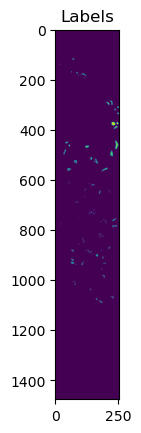

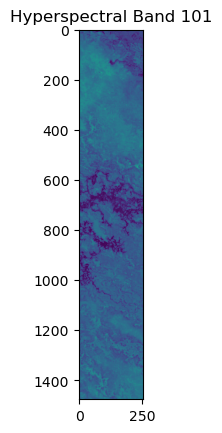

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
S


All datasets saved to the 'indices' folder.
(140, 5, 5, 145)
(70, 5, 5, 145)
(3038, 5, 5, 145)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 140
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2181, PSNR: -6.4245


Epoch [1/50] Training Loss: 0.2101, PSNR: -8.7511
	[Val]   Batch [1/11] Loss: 0.2033, PSNR: -6.1176
	[Val]   Batch [10/11] Loss: 0.2034, PSNR: -8.3564
Epoch [1/50] Validation Loss: 0.2033, PSNR: -8.0485

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1955, PSNR: -8.7513


Epoch [2/50] Training Loss: 0.1882, PSNR: -8.2032
	[Val]   Batch [1/11] Loss: 0.1754, PSNR: -5.4775
	[Val]   Batch [10/11] Loss: 0.1757, PSNR: -7.7206
Epoch [2/50] Validation Loss: 0.1753, PSNR: -7.4055

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1737, PSNR: -9.3679


Epoch [3/50] Training Loss: 0.1674, PSNR: -7.8528
	[Val]   Batch [1/11] Loss: 0.1536, PSNR: -4.9017
	[Val]   Batch [10/11] Loss: 0.1540, PSNR: -7.1469
Epoch [3/50] Validation Loss: 0.1535, PSNR: -6.8298

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1532, PSNR: -6.2050


Epoch [4/50] Training Loss: 0.1473, PSNR: -7.1455
	[Val]   Batch [1/11] Loss: 0.1307, PSNR: -4.1991
	[Val]   Batch [10/11] Loss: 0.1309, PSNR: -6.4427
Epoch [4/50] Validation Loss: 0.1305, PSNR: -6.1252

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1353, PSNR: -8.6818


Epoch [5/50] Training Loss: 0.1284, PSNR: -6.6288
	[Val]   Batch [1/11] Loss: 0.1142, PSNR: -3.6118
	[Val]   Batch [10/11] Loss: 0.1143, PSNR: -5.8539
Epoch [5/50] Validation Loss: 0.1141, PSNR: -5.5414

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1162, PSNR: -7.6216


Epoch [6/50] Training Loss: 0.1111, PSNR: -6.0256
	[Val]   Batch [1/11] Loss: 0.0979, PSNR: -2.9442
	[Val]   Batch [10/11] Loss: 0.0981, PSNR: -5.1887
Epoch [6/50] Validation Loss: 0.0979, PSNR: -4.8742

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.1002, PSNR: -6.9793


Epoch [7/50] Training Loss: 0.0957, PSNR: -5.2860
	[Val]   Batch [1/11] Loss: 0.0852, PSNR: -2.3427
	[Val]   Batch [10/11] Loss: 0.0854, PSNR: -4.5884
Epoch [7/50] Validation Loss: 0.0852, PSNR: -4.2731

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0862, PSNR: -6.6163


Epoch [8/50] Training Loss: 0.0824, PSNR: -4.6307
	[Val]   Batch [1/11] Loss: 0.0727, PSNR: -1.6500
	[Val]   Batch [10/11] Loss: 0.0728, PSNR: -3.8950
Epoch [8/50] Validation Loss: 0.0727, PSNR: -3.5811

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0758, PSNR: -3.4163


Epoch [9/50] Training Loss: 0.0710, PSNR: -4.1335
	[Val]   Batch [1/11] Loss: 0.0649, PSNR: -1.1628
	[Val]   Batch [10/11] Loss: 0.0650, PSNR: -3.4046
Epoch [9/50] Validation Loss: 0.0649, PSNR: -3.0925

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0651, PSNR: -3.1078


Epoch [10/50] Training Loss: 0.0615, PSNR: -3.4150
	[Val]   Batch [1/11] Loss: 0.0552, PSNR: -0.4559
	[Val]   Batch [10/11] Loss: 0.0553, PSNR: -2.6999
Epoch [10/50] Validation Loss: 0.0552, PSNR: -2.3844

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0558, PSNR: -4.7303


Epoch [11/50] Training Loss: 0.0535, PSNR: -2.6550
	[Val]   Batch [1/11] Loss: 0.0503, PSNR: -0.0550
	[Val]   Batch [10/11] Loss: 0.0504, PSNR: -2.2961
Epoch [11/50] Validation Loss: 0.0503, PSNR: -1.9836

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0497, PSNR: -3.9310


Epoch [12/50] Training Loss: 0.0469, PSNR: -2.0650
	[Val]   Batch [1/11] Loss: 0.0432, PSNR: 0.6093
	[Val]   Batch [10/11] Loss: 0.0432, PSNR: -1.6319
Epoch [12/50] Validation Loss: 0.0432, PSNR: -1.3186

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0445, PSNR: -3.7870


Epoch [13/50] Training Loss: 0.0414, PSNR: -1.5819
	[Val]   Batch [1/11] Loss: 0.0393, PSNR: 1.0178
	[Val]   Batch [10/11] Loss: 0.0393, PSNR: -1.2212
Epoch [13/50] Validation Loss: 0.0393, PSNR: -0.9100

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0378, PSNR: -1.6197


Epoch [14/50] Training Loss: 0.0368, PSNR: -1.1741
	[Val]   Batch [1/11] Loss: 0.0349, PSNR: 1.5378
	[Val]   Batch [10/11] Loss: 0.0349, PSNR: -0.7009
Epoch [14/50] Validation Loss: 0.0348, PSNR: -0.3886

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0344, PSNR: -0.3413


Epoch [15/50] Training Loss: 0.0328, PSNR: -0.7072
	[Val]   Batch [1/11] Loss: 0.0313, PSNR: 2.0045
	[Val]   Batch [10/11] Loss: 0.0313, PSNR: -0.2341
Epoch [15/50] Validation Loss: 0.0313, PSNR: 0.0781

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0312, PSNR: -2.4258


Epoch [16/50] Training Loss: 0.0296, PSNR: -0.0842
	[Val]   Batch [1/11] Loss: 0.0283, PSNR: 2.4402
	[Val]   Batch [10/11] Loss: 0.0284, PSNR: 0.2013
Epoch [16/50] Validation Loss: 0.0283, PSNR: 0.5134

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0277, PSNR: 2.5429


Epoch [17/50] Training Loss: 0.0268, PSNR: 0.2008
	[Val]   Batch [1/11] Loss: 0.0258, PSNR: 2.8385
	[Val]   Batch [10/11] Loss: 0.0259, PSNR: 0.5990
Epoch [17/50] Validation Loss: 0.0258, PSNR: 0.9119

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0252, PSNR: -0.9835


Epoch [18/50] Training Loss: 0.0243, PSNR: 0.7851
	[Val]   Batch [1/11] Loss: 0.0237, PSNR: 3.2151
	[Val]   Batch [10/11] Loss: 0.0237, PSNR: 0.9762
Epoch [18/50] Validation Loss: 0.0237, PSNR: 1.2886

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0229, PSNR: 0.3569


Epoch [19/50] Training Loss: 0.0222, PSNR: 0.8910
	[Val]   Batch [1/11] Loss: 0.0215, PSNR: 3.6308
	[Val]   Batch [10/11] Loss: 0.0216, PSNR: 1.3918
Epoch [19/50] Validation Loss: 0.0215, PSNR: 1.7043

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0210, PSNR: 0.8082


Epoch [20/50] Training Loss: 0.0204, PSNR: 1.3422
	[Val]   Batch [1/11] Loss: 0.0199, PSNR: 3.9794
	[Val]   Batch [10/11] Loss: 0.0199, PSNR: 1.7408
Epoch [20/50] Validation Loss: 0.0199, PSNR: 2.0531

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0193, PSNR: 0.3837


Epoch [21/50] Training Loss: 0.0187, PSNR: 1.9093
	[Val]   Batch [1/11] Loss: 0.0185, PSNR: 4.3000
	[Val]   Batch [10/11] Loss: 0.0185, PSNR: 2.0623
Epoch [21/50] Validation Loss: 0.0184, PSNR: 2.3738

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0176, PSNR: 1.5576


Epoch [22/50] Training Loss: 0.0173, PSNR: 2.2018
	[Val]   Batch [1/11] Loss: 0.0168, PSNR: 4.7002
	[Val]   Batch [10/11] Loss: 0.0169, PSNR: 2.4609
Epoch [22/50] Validation Loss: 0.0168, PSNR: 2.7740

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0164, PSNR: 1.3887


Epoch [23/50] Training Loss: 0.0160, PSNR: 2.3255
	[Val]   Batch [1/11] Loss: 0.0156, PSNR: 5.0208
	[Val]   Batch [10/11] Loss: 0.0157, PSNR: 2.7817
Epoch [23/50] Validation Loss: 0.0156, PSNR: 3.0947

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0148, PSNR: 2.3978


Epoch [24/50] Training Loss: 0.0149, PSNR: 2.7337
	[Val]   Batch [1/11] Loss: 0.0146, PSNR: 5.3268
	[Val]   Batch [10/11] Loss: 0.0146, PSNR: 3.0879
Epoch [24/50] Validation Loss: 0.0146, PSNR: 3.4005

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0142, PSNR: 5.4520


Epoch [25/50] Training Loss: 0.0139, PSNR: 3.1945
	[Val]   Batch [1/11] Loss: 0.0136, PSNR: 5.6146
	[Val]   Batch [10/11] Loss: 0.0136, PSNR: 3.3771
Epoch [25/50] Validation Loss: 0.0136, PSNR: 3.6884

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0134, PSNR: 2.8916


Epoch [26/50] Training Loss: 0.0129, PSNR: 3.4703
	[Val]   Batch [1/11] Loss: 0.0128, PSNR: 5.8995
	[Val]   Batch [10/11] Loss: 0.0128, PSNR: 3.6630
Epoch [26/50] Validation Loss: 0.0128, PSNR: 3.9745

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0122, PSNR: 3.1612


Epoch [27/50] Training Loss: 0.0121, PSNR: 3.4917
	[Val]   Batch [1/11] Loss: 0.0120, PSNR: 6.1786
	[Val]   Batch [10/11] Loss: 0.0120, PSNR: 3.9428
Epoch [27/50] Validation Loss: 0.0120, PSNR: 4.2548

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0114, PSNR: 6.3828


Epoch [28/50] Training Loss: 0.0114, PSNR: 4.0612
	[Val]   Batch [1/11] Loss: 0.0113, PSNR: 6.4360
	[Val]   Batch [10/11] Loss: 0.0113, PSNR: 4.2006
Epoch [28/50] Validation Loss: 0.0113, PSNR: 4.5124

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0108, PSNR: 5.0494


Epoch [29/50] Training Loss: 0.0107, PSNR: 4.2526
	[Val]   Batch [1/11] Loss: 0.0106, PSNR: 6.7076
	[Val]   Batch [10/11] Loss: 0.0106, PSNR: 4.4725
Epoch [29/50] Validation Loss: 0.0106, PSNR: 4.7841

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0107, PSNR: 2.4132


Epoch [30/50] Training Loss: 0.0101, PSNR: 4.4048
	[Val]   Batch [1/11] Loss: 0.0100, PSNR: 6.9763
	[Val]   Batch [10/11] Loss: 0.0100, PSNR: 4.7409
Epoch [30/50] Validation Loss: 0.0100, PSNR: 5.0533

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0096, PSNR: 3.7010


Epoch [31/50] Training Loss: 0.0095, PSNR: 4.7019
	[Val]   Batch [1/11] Loss: 0.0095, PSNR: 7.1963
	[Val]   Batch [10/11] Loss: 0.0095, PSNR: 4.9612
Epoch [31/50] Validation Loss: 0.0095, PSNR: 5.2733

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0093, PSNR: 2.8120


Epoch [32/50] Training Loss: 0.0090, PSNR: 4.9979
	[Val]   Batch [1/11] Loss: 0.0090, PSNR: 7.4403
	[Val]   Batch [10/11] Loss: 0.0090, PSNR: 5.2058
Epoch [32/50] Validation Loss: 0.0089, PSNR: 5.5173

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0085, PSNR: 3.2176


Epoch [33/50] Training Loss: 0.0085, PSNR: 5.2020
	[Val]   Batch [1/11] Loss: 0.0084, PSNR: 7.7189
	[Val]   Batch [10/11] Loss: 0.0084, PSNR: 5.4843
Epoch [33/50] Validation Loss: 0.0084, PSNR: 5.7960

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0085, PSNR: 3.4163


Epoch [34/50] Training Loss: 0.0080, PSNR: 5.6095
	[Val]   Batch [1/11] Loss: 0.0080, PSNR: 7.9275
	[Val]   Batch [10/11] Loss: 0.0080, PSNR: 5.6929
Epoch [34/50] Validation Loss: 0.0080, PSNR: 6.0051

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0078, PSNR: 5.0849


Epoch [35/50] Training Loss: 0.0076, PSNR: 5.6179
	[Val]   Batch [1/11] Loss: 0.0076, PSNR: 8.1314
	[Val]   Batch [10/11] Loss: 0.0076, PSNR: 5.8971
Epoch [35/50] Validation Loss: 0.0076, PSNR: 6.2095

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0075, PSNR: 5.3004


Epoch [36/50] Training Loss: 0.0072, PSNR: 6.0208
	[Val]   Batch [1/11] Loss: 0.0072, PSNR: 8.3861
	[Val]   Batch [10/11] Loss: 0.0072, PSNR: 6.1507
Epoch [36/50] Validation Loss: 0.0072, PSNR: 6.4648

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0069, PSNR: 7.2750


Epoch [37/50] Training Loss: 0.0069, PSNR: 6.1622
	[Val]   Batch [1/11] Loss: 0.0069, PSNR: 8.5690
	[Val]   Batch [10/11] Loss: 0.0069, PSNR: 6.3338
Epoch [37/50] Validation Loss: 0.0069, PSNR: 6.6475

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0066, PSNR: 5.8308


Epoch [38/50] Training Loss: 0.0066, PSNR: 6.3849
	[Val]   Batch [1/11] Loss: 0.0066, PSNR: 8.7758
	[Val]   Batch [10/11] Loss: 0.0066, PSNR: 6.5419
Epoch [38/50] Validation Loss: 0.0066, PSNR: 6.8541

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0062, PSNR: 6.2226


Epoch [39/50] Training Loss: 0.0063, PSNR: 6.5640
	[Val]   Batch [1/11] Loss: 0.0063, PSNR: 8.9842
	[Val]   Batch [10/11] Loss: 0.0063, PSNR: 6.7503
Epoch [39/50] Validation Loss: 0.0063, PSNR: 7.0626

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0062, PSNR: 6.6400


Epoch [40/50] Training Loss: 0.0060, PSNR: 6.7876
	[Val]   Batch [1/11] Loss: 0.0060, PSNR: 9.1796
	[Val]   Batch [10/11] Loss: 0.0060, PSNR: 6.9453
Epoch [40/50] Validation Loss: 0.0060, PSNR: 7.2582

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0057, PSNR: 6.3832


Epoch [41/50] Training Loss: 0.0057, PSNR: 6.9631
	[Val]   Batch [1/11] Loss: 0.0057, PSNR: 9.3682
	[Val]   Batch [10/11] Loss: 0.0057, PSNR: 7.1336
Epoch [41/50] Validation Loss: 0.0057, PSNR: 7.4466

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0056, PSNR: 7.8888


Epoch [42/50] Training Loss: 0.0055, PSNR: 7.0955
	[Val]   Batch [1/11] Loss: 0.0055, PSNR: 9.5603
	[Val]   Batch [10/11] Loss: 0.0055, PSNR: 7.3251
Epoch [42/50] Validation Loss: 0.0055, PSNR: 7.6388

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0054, PSNR: 5.4026


Epoch [43/50] Training Loss: 0.0053, PSNR: 7.2200
	[Val]   Batch [1/11] Loss: 0.0052, PSNR: 9.7762
	[Val]   Batch [10/11] Loss: 0.0052, PSNR: 7.5411
Epoch [43/50] Validation Loss: 0.0052, PSNR: 7.8549

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0051, PSNR: 9.8660


Epoch [44/50] Training Loss: 0.0050, PSNR: 7.3970
	[Val]   Batch [1/11] Loss: 0.0051, PSNR: 9.9158
	[Val]   Batch [10/11] Loss: 0.0051, PSNR: 7.6808
Epoch [44/50] Validation Loss: 0.0051, PSNR: 7.9947

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0049, PSNR: 6.6496


Epoch [45/50] Training Loss: 0.0048, PSNR: 7.5608
	[Val]   Batch [1/11] Loss: 0.0048, PSNR: 10.1418
	[Val]   Batch [10/11] Loss: 0.0048, PSNR: 7.9073
Epoch [45/50] Validation Loss: 0.0048, PSNR: 8.2215

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0045, PSNR: 9.1157


Epoch [46/50] Training Loss: 0.0047, PSNR: 7.9316
	[Val]   Batch [1/11] Loss: 0.0047, PSNR: 10.2865
	[Val]   Batch [10/11] Loss: 0.0046, PSNR: 8.0528
Epoch [46/50] Validation Loss: 0.0046, PSNR: 8.3666

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0047, PSNR: 6.4588


Epoch [47/50] Training Loss: 0.0045, PSNR: 8.0517
	[Val]   Batch [1/11] Loss: 0.0045, PSNR: 10.4635
	[Val]   Batch [10/11] Loss: 0.0045, PSNR: 8.2303
Epoch [47/50] Validation Loss: 0.0045, PSNR: 8.5438

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0044, PSNR: 8.6378


Epoch [48/50] Training Loss: 0.0043, PSNR: 8.3655
	[Val]   Batch [1/11] Loss: 0.0043, PSNR: 10.6130
	[Val]   Batch [10/11] Loss: 0.0043, PSNR: 8.3798
Epoch [48/50] Validation Loss: 0.0043, PSNR: 8.6940

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0042, PSNR: 9.1728


Epoch [49/50] Training Loss: 0.0041, PSNR: 8.3244
	[Val]   Batch [1/11] Loss: 0.0041, PSNR: 10.7990
	[Val]   Batch [10/11] Loss: 0.0041, PSNR: 8.5654
Epoch [49/50] Validation Loss: 0.0041, PSNR: 8.8806

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0040, PSNR: 8.1282


Epoch [50/50] Training Loss: 0.0040, PSNR: 8.5186
	[Val]   Batch [1/11] Loss: 0.0040, PSNR: 10.9600
	[Val]   Batch [10/11] Loss: 0.0040, PSNR: 8.7267
Epoch [50/50] Validation Loss: 0.0040, PSNR: 9.0418


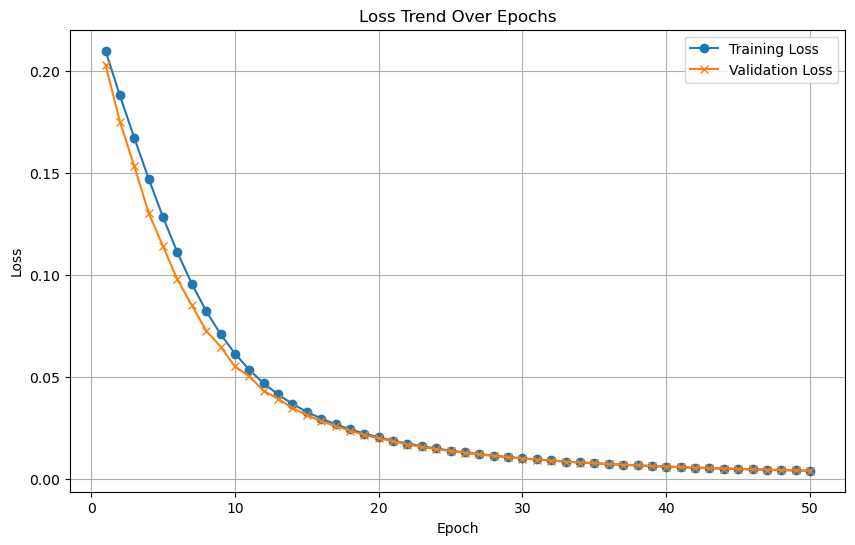

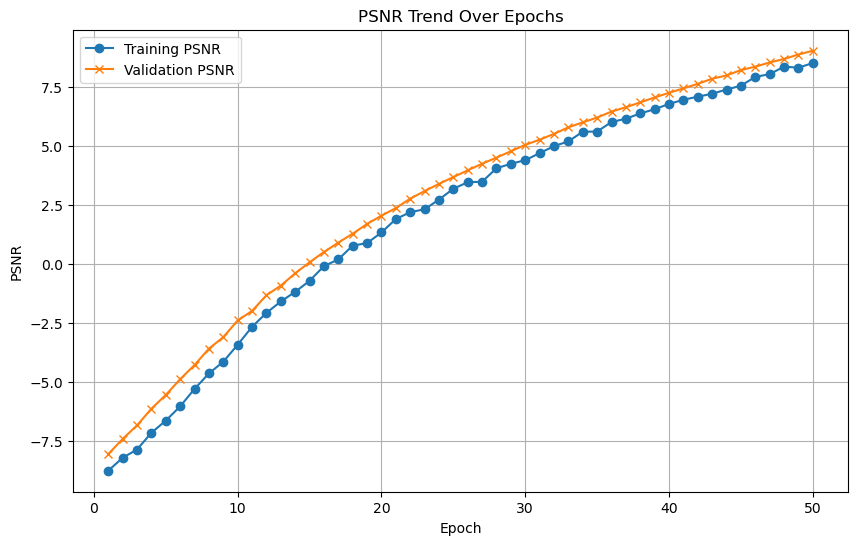

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/12 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6350
    Validation Batch [1/1], Loss: 2.6442
Validation Loss: 2.6442, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6442. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5904
    Validation Batch [1/1], Loss: 2.6442
Validation Loss: 2.6442, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5664
    Validation Batch [1/1], Loss: 2.6443
Validation Loss: 2.6443, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5411
    Validation Batch [1/1], Loss: 2.6444
Validation Loss: 2.6444, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Training Loss: 2.5240
    Validati

Epoch [17/1000] completed, Average Training Loss: 2.3703
    Validation Batch [1/1], Loss: 2.6447
Validation Loss: 2.6447, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.3561
    Validation Batch [1/1], Loss: 2.6447
Validation Loss: 2.6447, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.3358
    Validation Batch [1/1], Loss: 2.6447
Validation Loss: 2.6447, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.3150
    Validation Batch [1/1], Loss: 2.6448
Validation Loss: 2.6448, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.3198
    Validat

Epoch [29/1000] completed, Average Training Loss: 2.2350
    Validation Batch [1/1], Loss: 2.6454
Validation Loss: 2.6454, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [30/1000] - Training
Epoch [30/1000] completed, Average Training Loss: 2.2228
    Validation Batch [1/1], Loss: 2.6454
Validation Loss: 2.6454, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [31/1000] - Training
Epoch [31/1000] completed, Average Training Loss: 2.2124
    Validation Batch [1/1], Loss: 2.6455
Validation Loss: 2.6455, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 2.2088
    Validation Batch [1/1], Loss: 2.6455
Validation Loss: 2.6455, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 2.1950
    Validat

    Validation Batch [1/1], Loss: 2.6428
Validation Loss: 2.6428, Validation Accuracy: 7.14%
Validation loss improved from 2.6436 to 2.6428. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 2.0619
    Validation Batch [1/1], Loss: 2.6418
Validation Loss: 2.6418, Validation Accuracy: 7.14%
Validation loss improved from 2.6428 to 2.6418. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/1000] completed, Average Training Loss: 2.0429
    Validation Batch [1/1], Loss: 2.6410
Validation Loss: 2.6410, Validation Accuracy: 7.14%
Validation loss improved from 2.6418 to 2.6410. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 2.0364
    Validation Batch [1/1], Loss: 2.6400
Validation Loss: 2.6400, Validation Accuracy: 7.14%
Validation loss improved from 2.6410 to 2.6400. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 2.0289
    Validati

    Validation Batch [1/1], Loss: 2.6241
Validation Loss: 2.6241, Validation Accuracy: 8.57%
Validation loss improved from 2.6269 to 2.6241. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 1.9497
    Validation Batch [1/1], Loss: 2.6209
Validation Loss: 2.6209, Validation Accuracy: 8.57%
Validation loss improved from 2.6241 to 2.6209. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] completed, Average Training Loss: 1.9415
    Validation Batch [1/1], Loss: 2.6175
Validation Loss: 2.6175, Validation Accuracy: 8.57%
Validation loss improved from 2.6209 to 2.6175. Saving model...

LOG: Epoch [60/1000] - Training
Epoch [60/1000] completed, Average Training Loss: 1.9352
    Validation Batch [1/1], Loss: 2.6141
Validation Loss: 2.6141, Validation Accuracy: 12.86%
Validation loss improved from 2.6175 to 2.6141. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 1.9102
    Validat

Epoch [73/1000] completed, Average Training Loss: 1.8065
    Validation Batch [1/1], Loss: 2.4615
Validation Loss: 2.4615, Validation Accuracy: 38.57%
Validation loss improved from 2.4809 to 2.4615. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 1.7884
    Validation Batch [1/1], Loss: 2.4375
Validation Loss: 2.4375, Validation Accuracy: 42.86%
Validation loss improved from 2.4615 to 2.4375. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 1.7974
    Validation Batch [1/1], Loss: 2.4107
Validation Loss: 2.4107, Validation Accuracy: 47.14%
Validation loss improved from 2.4375 to 2.4107. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.7935
    Validation Batch [1/1], Loss: 2.3817
Validation Loss: 2.3817, Validation Accuracy: 47.14%
Validation loss improved from 2.4107 to 2.3817. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [7

    Validation Batch [1/1], Loss: 2.1208
Validation Loss: 2.1208, Validation Accuracy: 71.43%
Validation loss improved from 2.1517 to 2.1208. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 1.6715
    Validation Batch [1/1], Loss: 2.0937
Validation Loss: 2.0937, Validation Accuracy: 74.29%
Validation loss improved from 2.1208 to 2.0937. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.6758
    Validation Batch [1/1], Loss: 2.0678
Validation Loss: 2.0678, Validation Accuracy: 75.71%
Validation loss improved from 2.0937 to 2.0678. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.6695
    Validation Batch [1/1], Loss: 2.0381
Validation Loss: 2.0381, Validation Accuracy: 77.14%
Validation loss improved from 2.0678 to 2.0381. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.6791
    Vali

Epoch [103/1000] completed, Average Training Loss: 1.5421
    Validation Batch [1/1], Loss: 1.6846
Validation Loss: 1.6846, Validation Accuracy: 82.86%
Validation loss improved from 1.6978 to 1.6846. Saving model...

LOG: Epoch [104/1000] - Training
Epoch [104/1000] completed, Average Training Loss: 1.5160
    Validation Batch [1/1], Loss: 1.6767
Validation Loss: 1.6767, Validation Accuracy: 82.86%
Validation loss improved from 1.6846 to 1.6767. Saving model...

LOG: Epoch [105/1000] - Training
Epoch [105/1000] completed, Average Training Loss: 1.4962
    Validation Batch [1/1], Loss: 1.6778
Validation Loss: 1.6778, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Average Training Loss: 1.4949
    Validation Batch [1/1], Loss: 1.6711
Validation Loss: 1.6711, Validation Accuracy: 80.00%
Validation loss improved from 1.6767 to 1.6711. Saving model...

LOG: Epoch [107/1000] - Training
Epoch [107/1000

Epoch [113/1000] completed, Average Training Loss: 1.4687
    Validation Batch [1/1], Loss: 1.5723
Validation Loss: 1.5723, Validation Accuracy: 84.29%
Validation loss improved from 1.5903 to 1.5723. Saving model...

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training Loss: 1.4214
    Validation Batch [1/1], Loss: 1.5531
Validation Loss: 1.5531, Validation Accuracy: 84.29%
Validation loss improved from 1.5723 to 1.5531. Saving model...

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training Loss: 1.4423
    Validation Batch [1/1], Loss: 1.5463
Validation Loss: 1.5463, Validation Accuracy: 81.43%
Validation loss improved from 1.5531 to 1.5463. Saving model...

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 1.4144
    Validation Batch [1/1], Loss: 1.5322
Validation Loss: 1.5322, Validation Accuracy: 84.29%
Validation loss improved from 1.5463 to 1.5322. Saving model...

LOG: Epoch [117/1000] - Training


Epoch [131/1000] completed, Average Training Loss: 1.2740
    Validation Batch [1/1], Loss: 1.4171
Validation Loss: 1.4171, Validation Accuracy: 90.00%
Validation loss improved from 1.4281 to 1.4171. Saving model...

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 1.3007
    Validation Batch [1/1], Loss: 1.4124
Validation Loss: 1.4124, Validation Accuracy: 92.86%
Validation loss improved from 1.4171 to 1.4124. Saving model...

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 1.2659
    Validation Batch [1/1], Loss: 1.3918
Validation Loss: 1.3918, Validation Accuracy: 92.86%
Validation loss improved from 1.4124 to 1.3918. Saving model...

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Average Training Loss: 1.2698
    Validation Batch [1/1], Loss: 1.3767
Validation Loss: 1.3767, Validation Accuracy: 92.86%
Validation loss improved from 1.3918 to 1.3767. Saving model...

LOG: Epoch [135/1000] - Training


    Validation Batch [1/1], Loss: 1.3012
Validation Loss: 1.3012, Validation Accuracy: 91.43%
Validation loss improved from 1.3018 to 1.3012. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.2377
    Validation Batch [1/1], Loss: 1.3082
Validation Loss: 1.3082, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.1725
    Validation Batch [1/1], Loss: 1.3177
Validation Loss: 1.3177, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.1686
    Validation Batch [1/1], Loss: 1.3068
Validation Loss: 1.3068, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 1.1956
    Validation Batch [1/1], Loss: 1.2879
Vali

    Validation Batch [1/1], Loss: 1.1881
Validation Loss: 1.1881, Validation Accuracy: 95.71%
Validation loss improved from 1.2089 to 1.1881. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 1.0516
    Validation Batch [1/1], Loss: 1.1862
Validation Loss: 1.1862, Validation Accuracy: 92.86%
Validation loss improved from 1.1881 to 1.1862. Saving model...

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 1.0137
    Validation Batch [1/1], Loss: 1.1711
Validation Loss: 1.1711, Validation Accuracy: 95.71%
Validation loss improved from 1.1862 to 1.1711. Saving model...

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, Average Training Loss: 1.0525
    Validation Batch [1/1], Loss: 1.1679
Validation Loss: 1.1679, Validation Accuracy: 95.71%
Validation loss improved from 1.1711 to 1.1679. Saving model...

LOG: Epoch [161/1000] - Training
Epoch [161/1000] completed, Average Training Loss: 1.0509


Epoch [169/1000] completed, Average Training Loss: 1.0090
    Validation Batch [1/1], Loss: 1.1015
Validation Loss: 1.1015, Validation Accuracy: 92.86%
Validation loss improved from 1.1078 to 1.1015. Saving model...

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 0.9924
    Validation Batch [1/1], Loss: 1.0822
Validation Loss: 1.0822, Validation Accuracy: 95.71%
Validation loss improved from 1.1015 to 1.0822. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 1.0134
    Validation Batch [1/1], Loss: 1.0687
Validation Loss: 1.0687, Validation Accuracy: 94.29%
Validation loss improved from 1.0822 to 1.0687. Saving model...

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 0.9461
    Validation Batch [1/1], Loss: 1.0606
Validation Loss: 1.0606, Validation Accuracy: 97.14%
Validation loss improved from 1.0687 to 1.0606. Saving model...

LOG: Epoch [173/1000] - Training


Epoch [185/1000] completed, Average Training Loss: 0.8675
    Validation Batch [1/1], Loss: 0.9635
Validation Loss: 0.9635, Validation Accuracy: 95.71%
Validation loss improved from 0.9768 to 0.9635. Saving model...

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.8864
    Validation Batch [1/1], Loss: 0.9783
Validation Loss: 0.9783, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.8139
    Validation Batch [1/1], Loss: 0.9983
Validation Loss: 0.9983, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.8513
    Validation Batch [1/1], Loss: 0.9625
Validation Loss: 0.9625, Validation Accuracy: 97.14%
Validation loss improved from 0.9635 to 0.9625. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Av

    Validation Batch [1/1], Loss: 0.9014
Validation Loss: 0.9014, Validation Accuracy: 98.57%
Validation loss improved from 0.9194 to 0.9014. Saving model...

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 0.7513
    Validation Batch [1/1], Loss: 0.8874
Validation Loss: 0.8874, Validation Accuracy: 98.57%
Validation loss improved from 0.9014 to 0.8874. Saving model...

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.7265
    Validation Batch [1/1], Loss: 0.8895
Validation Loss: 0.8895, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.7602
    Validation Batch [1/1], Loss: 0.8846
Validation Loss: 0.8846, Validation Accuracy: 97.14%
Validation loss improved from 0.8874 to 0.8846. Saving model...

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 0.7894
    Validation 

    Validation Batch [1/1], Loss: 0.7970
Validation Loss: 0.7970, Validation Accuracy: 98.57%
Validation loss improved from 0.7978 to 0.7970. Saving model...

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.6685
    Validation Batch [1/1], Loss: 0.8011
Validation Loss: 0.8011, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.7106
    Validation Batch [1/1], Loss: 0.7833
Validation Loss: 0.7833, Validation Accuracy: 98.57%
Validation loss improved from 0.7970 to 0.7833. Saving model...

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.6600
    Validation Batch [1/1], Loss: 0.7647
Validation Loss: 0.7647, Validation Accuracy: 97.14%
Validation loss improved from 0.7833 to 0.7647. Saving model...

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.6242
    Validation 

Epoch [226/1000] completed, Average Training Loss: 0.6068
    Validation Batch [1/1], Loss: 0.7406
Validation Loss: 0.7406, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.5942
    Validation Batch [1/1], Loss: 0.7301
Validation Loss: 0.7301, Validation Accuracy: 97.14%
Validation loss improved from 0.7320 to 0.7301. Saving model...

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.6238
    Validation Batch [1/1], Loss: 0.7184
Validation Loss: 0.7184, Validation Accuracy: 97.14%
Validation loss improved from 0.7301 to 0.7184. Saving model...

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.5418
    Validation Batch [1/1], Loss: 0.7205
Validation Loss: 0.7205, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Av

Epoch [243/1000] completed, Average Training Loss: 0.4941
    Validation Batch [1/1], Loss: 0.6176
Validation Loss: 0.6176, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.5130
    Validation Batch [1/1], Loss: 0.6229
Validation Loss: 0.6229, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.5011
    Validation Batch [1/1], Loss: 0.6312
Validation Loss: 0.6312, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.4971
    Validation Batch [1/1], Loss: 0.6224
Validation Loss: 0.6224, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.4949
  

    Validation Batch [1/1], Loss: 0.5641
Validation Loss: 0.5641, Validation Accuracy: 98.57%
Validation loss improved from 0.5641 to 0.5641. Saving model...

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.4957
    Validation Batch [1/1], Loss: 0.5699
Validation Loss: 0.5699, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.4346
    Validation Batch [1/1], Loss: 0.5866
Validation Loss: 0.5866, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.4516
    Validation Batch [1/1], Loss: 0.6252
Validation Loss: 0.6252, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.4254
    Validation Batch [1/1], Loss: 0.5965
Vali

Epoch [269/1000] completed, Average Training Loss: 0.4174
    Validation Batch [1/1], Loss: 0.5180
Validation Loss: 0.5180, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.4107
    Validation Batch [1/1], Loss: 0.5189
Validation Loss: 0.5189, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.3989
    Validation Batch [1/1], Loss: 0.5157
Validation Loss: 0.5157, Validation Accuracy: 98.57%
Validation loss improved from 0.5179 to 0.5157. Saving model...

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.4041
    Validation Batch [1/1], Loss: 0.5174
Validation Loss: 0.5174, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training 

Epoch [284/1000] completed, Average Training Loss: 0.3594
    Validation Batch [1/1], Loss: 0.4710
Validation Loss: 0.4710, Validation Accuracy: 98.57%
Validation loss improved from 0.4757 to 0.4710. Saving model...

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.3882
    Validation Batch [1/1], Loss: 0.4540
Validation Loss: 0.4540, Validation Accuracy: 98.57%
Validation loss improved from 0.4710 to 0.4540. Saving model...

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.3335
    Validation Batch [1/1], Loss: 0.4554
Validation Loss: 0.4554, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.3782
    Validation Batch [1/1], Loss: 0.4474
Validation Loss: 0.4474, Validation Accuracy: 97.14%
Validation loss improved from 0.4540 to 0.4474. Saving model...

LOG: Epoch [288/1000] - Training
Epoch [288/1000

    Validation Batch [1/1], Loss: 0.4151
Validation Loss: 0.4151, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.2901
    Validation Batch [1/1], Loss: 0.4049
Validation Loss: 0.4049, Validation Accuracy: 98.57%
Validation loss improved from 0.4145 to 0.4049. Saving model...

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.3075
    Validation Batch [1/1], Loss: 0.4106
Validation Loss: 0.4106, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.3209
    Validation Batch [1/1], Loss: 0.4060
Validation Loss: 0.4060, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.2803
    Validation Batch [1/1], Loss: 0.3951
Vali

    Validation Batch [1/1], Loss: 0.3966
Validation Loss: 0.3966, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.2555
    Validation Batch [1/1], Loss: 0.3964
Validation Loss: 0.3964, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.3084
    Validation Batch [1/1], Loss: 0.3796
Validation Loss: 0.3796, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.2828
    Validation Batch [1/1], Loss: 0.3639
Validation Loss: 0.3639, Validation Accuracy: 98.57%
Validation loss improved from 0.3747 to 0.3639. Saving model...

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.2699
    Validation Batch [1/1], Loss: 0.3613
Vali

    Validation Batch [1/1], Loss: 0.3665
Validation Loss: 0.3665, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.2387
    Validation Batch [1/1], Loss: 0.3447
Validation Loss: 0.3447, Validation Accuracy: 98.57%
Validation loss improved from 0.3517 to 0.3447. Saving model...

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.2218
    Validation Batch [1/1], Loss: 0.3410
Validation Loss: 0.3410, Validation Accuracy: 98.57%
Validation loss improved from 0.3447 to 0.3410. Saving model...

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.2422
    Validation Batch [1/1], Loss: 0.3432
Validation Loss: 0.3432, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.2450
    Validation Batch [1/1], Lo

Epoch [341/1000] completed, Average Training Loss: 0.2591
    Validation Batch [1/1], Loss: 0.3184
Validation Loss: 0.3184, Validation Accuracy: 98.57%
Validation loss improved from 0.3222 to 0.3184. Saving model...

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.2212
    Validation Batch [1/1], Loss: 0.3035
Validation Loss: 0.3035, Validation Accuracy: 98.57%
Validation loss improved from 0.3184 to 0.3035. Saving model...

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.2482
    Validation Batch [1/1], Loss: 0.3034
Validation Loss: 0.3034, Validation Accuracy: 98.57%
Validation loss improved from 0.3035 to 0.3034. Saving model...

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.2141
    Validation Batch [1/1], Loss: 0.3034
Validation Loss: 0.3034, Validation Accuracy: 98.57%
Validation loss improved from 0.3034 to 0.3034. Saving model...

LOG: Epoch [345/1000] - Training


Epoch [353/1000] completed, Average Training Loss: 0.2198
    Validation Batch [1/1], Loss: 0.2837
Validation Loss: 0.2837, Validation Accuracy: 98.57%
Validation loss improved from 0.2877 to 0.2837. Saving model...

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.2203
    Validation Batch [1/1], Loss: 0.2847
Validation Loss: 0.2847, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.2176
    Validation Batch [1/1], Loss: 0.2847
Validation Loss: 0.2847, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.2130
    Validation Batch [1/1], Loss: 0.2922
Validation Loss: 0.2922, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training 

Epoch [368/1000] completed, Average Training Loss: 0.1770
    Validation Batch [1/1], Loss: 0.2571
Validation Loss: 0.2571, Validation Accuracy: 98.57%
Validation loss improved from 0.2625 to 0.2571. Saving model...

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.1787
    Validation Batch [1/1], Loss: 0.2549
Validation Loss: 0.2549, Validation Accuracy: 98.57%
Validation loss improved from 0.2571 to 0.2549. Saving model...

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training Loss: 0.1661
    Validation Batch [1/1], Loss: 0.2647
Validation Loss: 0.2647, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.1767
    Validation Batch [1/1], Loss: 0.2731
Validation Loss: 0.2731, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Av

Epoch [382/1000] completed, Average Training Loss: 0.1478
    Validation Batch [1/1], Loss: 0.2537
Validation Loss: 0.2537, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.1531
    Validation Batch [1/1], Loss: 0.2805
Validation Loss: 0.2805, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.1706
    Validation Batch [1/1], Loss: 0.2946
Validation Loss: 0.2946, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.1390
    Validation Batch [1/1], Loss: 0.2960
Validation Loss: 0.2960, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.1707
  

Epoch [397/1000] completed, Average Training Loss: 0.1559
    Validation Batch [1/1], Loss: 0.2411
Validation Loss: 0.2411, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.1486
    Validation Batch [1/1], Loss: 0.2401
Validation Loss: 0.2401, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.1390
    Validation Batch [1/1], Loss: 0.2457
Validation Loss: 0.2457, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.1287
    Validation Batch [1/1], Loss: 0.2495
Validation Loss: 0.2495, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.1297

Epoch [412/1000] completed, Average Training Loss: 0.1290
    Validation Batch [1/1], Loss: 0.2182
Validation Loss: 0.2182, Validation Accuracy: 98.57%
Validation loss improved from 0.2258 to 0.2182. Saving model...

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.1293
    Validation Batch [1/1], Loss: 0.2096
Validation Loss: 0.2096, Validation Accuracy: 100.00%
Validation loss improved from 0.2182 to 0.2096. Saving model...

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.1158
    Validation Batch [1/1], Loss: 0.2048
Validation Loss: 0.2048, Validation Accuracy: 98.57%
Validation loss improved from 0.2096 to 0.2048. Saving model...

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.1127
    Validation Batch [1/1], Loss: 0.2021
Validation Loss: 0.2021, Validation Accuracy: 98.57%
Validation loss improved from 0.2048 to 0.2021. Saving model...

LOG: Epoch [416/1000] - Training

Epoch [428/1000] completed, Average Training Loss: 0.1127
    Validation Batch [1/1], Loss: 0.2279
Validation Loss: 0.2279, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training Loss: 0.1415
    Validation Batch [1/1], Loss: 0.2183
Validation Loss: 0.2183, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [430/1000] - Training
Epoch [430/1000] completed, Average Training Loss: 0.1087
    Validation Batch [1/1], Loss: 0.2098
Validation Loss: 0.2098, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.1245
    Validation Batch [1/1], Loss: 0.2064
Validation Loss: 0.2064, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.136

Epoch [438/1000] completed, Average Training Loss: 0.1052
    Validation Batch [1/1], Loss: 0.2372
Validation Loss: 0.2372, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.1082
    Validation Batch [1/1], Loss: 0.2460
Validation Loss: 0.2460, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.0927
    Validation Batch [1/1], Loss: 0.2222
Validation Loss: 0.2222, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.1005
    Validation Batch [1/1], Loss: 0.2099
Validation Loss: 0.2099, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.1095
  

    Validation Batch [1/1], Loss: 0.1832
Validation Loss: 0.1832, Validation Accuracy: 98.57%
Validation loss improved from 0.1955 to 0.1832. Saving model...

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.1046
    Validation Batch [1/1], Loss: 0.1794
Validation Loss: 0.1794, Validation Accuracy: 98.57%
Validation loss improved from 0.1832 to 0.1794. Saving model...

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.1157
    Validation Batch [1/1], Loss: 0.1893
Validation Loss: 0.1893, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.0985
    Validation Batch [1/1], Loss: 0.1946
Validation Loss: 0.1946, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.1064
    Validation Batch [1/1], Lo

Epoch [469/1000] completed, Average Training Loss: 0.1016
    Validation Batch [1/1], Loss: 0.1910
Validation Loss: 0.1910, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.0811
    Validation Batch [1/1], Loss: 0.1971
Validation Loss: 0.1971, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.0844
    Validation Batch [1/1], Loss: 0.1991
Validation Loss: 0.1991, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.1041
    Validation Batch [1/1], Loss: 0.1944
Validation Loss: 0.1944, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.0792
  

Epoch [484/1000] completed, Average Training Loss: 0.0855
    Validation Batch [1/1], Loss: 0.1833
Validation Loss: 0.1833, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.0781
    Validation Batch [1/1], Loss: 0.1746
Validation Loss: 0.1746, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0.0803
    Validation Batch [1/1], Loss: 0.1629
Validation Loss: 0.1629, Validation Accuracy: 98.57%
Validation loss improved from 0.1735 to 0.1629. Saving model...

LOG: Epoch [487/1000] - Training
Epoch [487/1000] completed, Average Training Loss: 0.0914
    Validation Batch [1/1], Loss: 0.1574
Validation Loss: 0.1574, Validation Accuracy: 98.57%
Validation loss improved from 0.1629 to 0.1574. Saving model...

LOG: Epoch [488/1000] - Training
Epoch [488/1000] completed, 

Epoch [498/1000] completed, Average Training Loss: 0.0744
    Validation Batch [1/1], Loss: 0.2191
Validation Loss: 0.2191, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.0761
    Validation Batch [1/1], Loss: 0.2246
Validation Loss: 0.2246, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.0846
    Validation Batch [1/1], Loss: 0.1835
Validation Loss: 0.1835, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.1016
    Validation Batch [1/1], Loss: 0.1879
Validation Loss: 0.1879, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.081

    Validation Batch [1/1], Loss: 0.1546
Validation Loss: 0.1546, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.0763
    Validation Batch [1/1], Loss: 0.1509
Validation Loss: 0.1509, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.0843
    Validation Batch [1/1], Loss: 0.1484
Validation Loss: 0.1484, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.0832
    Validation Batch [1/1], Loss: 0.1450
Validation Loss: 0.1450, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.0651
    Validation Batch [1/1], Loss: 0.1456
Validation Loss: 0.

Epoch [529/1000] completed, Average Training Loss: 0.0813
    Validation Batch [1/1], Loss: 0.1460
Validation Loss: 0.1460, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.0680
    Validation Batch [1/1], Loss: 0.1436
Validation Loss: 0.1436, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.0715
    Validation Batch [1/1], Loss: 0.1410
Validation Loss: 0.1410, Validation Accuracy: 97.14%
Validation loss improved from 0.1424 to 0.1410. Saving model...

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0673
    Validation Batch [1/1], Loss: 0.1446
Validation Loss: 0.1446, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Trainin

    Validation Batch [1/1], Loss: 0.1459
Validation Loss: 0.1459, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0741
    Validation Batch [1/1], Loss: 0.1593
Validation Loss: 0.1593, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.0685
    Validation Batch [1/1], Loss: 0.1750
Validation Loss: 0.1750, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0728
    Validation Batch [1/1], Loss: 0.1810
Validation Loss: 0.1810, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.0602
    Validation Batch [1/1], Loss: 0.1821
Validation Loss: 0.

Epoch [559/1000] completed, Average Training Loss: 0.0564
    Validation Batch [1/1], Loss: 0.1406
Validation Loss: 0.1406, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0582
    Validation Batch [1/1], Loss: 0.1388
Validation Loss: 0.1388, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0502
    Validation Batch [1/1], Loss: 0.1399
Validation Loss: 0.1399, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.0611
    Validation Batch [1/1], Loss: 0.1361
Validation Loss: 0.1361, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [563/1000] - Training
Epoch [563/1000] completed, Average Training Loss: 0.0

Epoch [574/1000] completed, Average Training Loss: 0.0663
    Validation Batch [1/1], Loss: 0.1407
Validation Loss: 0.1407, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [575/1000] - Training
Epoch [575/1000] completed, Average Training Loss: 0.0651
    Validation Batch [1/1], Loss: 0.1447
Validation Loss: 0.1447, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [576/1000] - Training
Epoch [576/1000] completed, Average Training Loss: 0.0585
    Validation Batch [1/1], Loss: 0.1457
Validation Loss: 0.1457, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [577/1000] - Training
Epoch [577/1000] completed, Average Training Loss: 0.0497
    Validation Batch [1/1], Loss: 0.1457
Validation Loss: 0.1457, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [578/1000] - Training
Epoch [578/1000] completed, Average Training Loss: 0.065

Epoch [588/1000] completed, Average Training Loss: 0.0511
    Validation Batch [1/1], Loss: 0.1368
Validation Loss: 0.1368, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [589/1000] - Training
Epoch [589/1000] completed, Average Training Loss: 0.0532
    Validation Batch [1/1], Loss: 0.1332
Validation Loss: 0.1332, Validation Accuracy: 97.14%
Validation loss improved from 0.1338 to 0.1332. Saving model...

LOG: Epoch [590/1000] - Training
Epoch [590/1000] completed, Average Training Loss: 0.0475
    Validation Batch [1/1], Loss: 0.1355
Validation Loss: 0.1355, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [591/1000] - Training
Epoch [591/1000] completed, Average Training Loss: 0.0428
    Validation Batch [1/1], Loss: 0.1455
Validation Loss: 0.1455, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [592/1000] - Training
Epoch [592/1000] completed, Average Training

Epoch [602/1000] completed, Average Training Loss: 0.0631
    Validation Batch [1/1], Loss: 0.1263
Validation Loss: 0.1263, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [603/1000] - Training
Epoch [603/1000] completed, Average Training Loss: 0.0438
    Validation Batch [1/1], Loss: 0.1317
Validation Loss: 0.1317, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [604/1000] - Training
Epoch [604/1000] completed, Average Training Loss: 0.0611
    Validation Batch [1/1], Loss: 0.1374
Validation Loss: 0.1374, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [605/1000] - Training
Epoch [605/1000] completed, Average Training Loss: 0.0450
    Validation Batch [1/1], Loss: 0.1336
Validation Loss: 0.1336, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [606/1000] - Training
Epoch [606/1000] completed, Average Training Loss: 0.0571
  

    Validation Batch [1/1], Loss: 0.1448
Validation Loss: 0.1448, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [619/1000] - Training
Epoch [619/1000] completed, Average Training Loss: 0.0535
    Validation Batch [1/1], Loss: 0.1420
Validation Loss: 0.1420, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [620/1000] - Training
Epoch [620/1000] completed, Average Training Loss: 0.0592
    Validation Batch [1/1], Loss: 0.1351
Validation Loss: 0.1351, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [621/1000] - Training
Epoch [621/1000] completed, Average Training Loss: 0.0415
    Validation Batch [1/1], Loss: 0.1378
Validation Loss: 0.1378, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [622/1000] - Training
Epoch [622/1000] completed, Average Training Loss: 0.0481
    Validation Batch [1/1], Loss: 0.1447
Validation Loss

Epoch [631/1000] completed, Average Training Loss: 0.0444
    Validation Batch [1/1], Loss: 0.1446
Validation Loss: 0.1446, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [632/1000] - Training
Epoch [632/1000] completed, Average Training Loss: 0.0476
    Validation Batch [1/1], Loss: 0.1494
Validation Loss: 0.1494, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [633/1000] - Training
Epoch [633/1000] completed, Average Training Loss: 0.0522
    Validation Batch [1/1], Loss: 0.1492
Validation Loss: 0.1492, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [634/1000] - Training
Epoch [634/1000] completed, Average Training Loss: 0.0506
    Validation Batch [1/1], Loss: 0.1451
Validation Loss: 0.1451, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [635/1000] - Training
Epoch [635/1000] completed, Average Training Loss: 0.048

Epoch [648/1000] completed, Average Training Loss: 0.0395
    Validation Batch [1/1], Loss: 0.1098
Validation Loss: 0.1098, Validation Accuracy: 98.57%
Validation loss improved from 0.1148 to 0.1098. Saving model...

LOG: Epoch [649/1000] - Training
Epoch [649/1000] completed, Average Training Loss: 0.0455
    Validation Batch [1/1], Loss: 0.1122
Validation Loss: 0.1122, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [650/1000] - Training
Epoch [650/1000] completed, Average Training Loss: 0.0378
    Validation Batch [1/1], Loss: 0.1178
Validation Loss: 0.1178, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [651/1000] - Training
Epoch [651/1000] completed, Average Training Loss: 0.0585
    Validation Batch [1/1], Loss: 0.1235
Validation Loss: 0.1235, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [652/1000] - Training
Epoch [652/1000] completed, Average Training 

Epoch [660/1000] completed, Average Training Loss: 0.0435
    Validation Batch [1/1], Loss: 0.1329
Validation Loss: 0.1329, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [661/1000] - Training
Epoch [661/1000] completed, Average Training Loss: 0.0499
    Validation Batch [1/1], Loss: 0.1342
Validation Loss: 0.1342, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [662/1000] - Training
Epoch [662/1000] completed, Average Training Loss: 0.0445
    Validation Batch [1/1], Loss: 0.1387
Validation Loss: 0.1387, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [663/1000] - Training
Epoch [663/1000] completed, Average Training Loss: 0.0466
    Validation Batch [1/1], Loss: 0.1428
Validation Loss: 0.1428, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [664/1000] - Training
Epoch [664/1000] completed, Average Training Loss: 0.0389
  

    Validation Batch [1/1], Loss: 0.1336
Validation Loss: 0.1336, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [677/1000] - Training
Epoch [677/1000] completed, Average Training Loss: 0.0281
    Validation Batch [1/1], Loss: 0.1372
Validation Loss: 0.1372, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [678/1000] - Training
Epoch [678/1000] completed, Average Training Loss: 0.0436
    Validation Batch [1/1], Loss: 0.1351
Validation Loss: 0.1351, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [679/1000] - Training
Epoch [679/1000] completed, Average Training Loss: 0.0420
    Validation Batch [1/1], Loss: 0.1301
Validation Loss: 0.1301, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [680/1000] - Training
Epoch [680/1000] completed, Average Training Loss: 0.0483
    Validation Batch [1/1], Loss: 0.1267
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.1607
Validation Loss: 0.1607, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [689/1000] - Training
Epoch [689/1000] completed, Average Training Loss: 0.0372
    Validation Batch [1/1], Loss: 0.1552
Validation Loss: 0.1552, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [690/1000] - Training
Epoch [690/1000] completed, Average Training Loss: 0.0411
    Validation Batch [1/1], Loss: 0.1484
Validation Loss: 0.1484, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [691/1000] - Training
Epoch [691/1000] completed, Average Training Loss: 0.0408
    Validation Batch [1/1], Loss: 0.1371
Validation Loss: 0.1371, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [692/1000] - Training
Epoch [692/1000] completed, Average Training Loss: 0.0351
    Validation Batch [1/1], Loss: 0.1281
Validation Loss

    Validation Batch [1/1], Loss: 0.1188
Validation Loss: 0.1188, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [707/1000] - Training
Epoch [707/1000] completed, Average Training Loss: 0.0434
    Validation Batch [1/1], Loss: 0.1186
Validation Loss: 0.1186, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [708/1000] - Training
Epoch [708/1000] completed, Average Training Loss: 0.0396
    Validation Batch [1/1], Loss: 0.1082
Validation Loss: 0.1082, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [709/1000] - Training
Epoch [709/1000] completed, Average Training Loss: 0.0490
    Validation Batch [1/1], Loss: 0.1128
Validation Loss: 0.1128, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [710/1000] - Training
Epoch [710/1000] completed, Average Training Loss: 0.0357
    Validation Batch [1/1], Loss: 0.1248
Validation Loss:

Epoch [719/1000] completed, Average Training Loss: 0.0277
    Validation Batch [1/1], Loss: 0.1080
Validation Loss: 0.1080, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [720/1000] - Training
Epoch [720/1000] completed, Average Training Loss: 0.0282
    Validation Batch [1/1], Loss: 0.1070
Validation Loss: 0.1070, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [721/1000] - Training
Epoch [721/1000] completed, Average Training Loss: 0.0316
    Validation Batch [1/1], Loss: 0.1065
Validation Loss: 0.1065, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [722/1000] - Training
Epoch [722/1000] completed, Average Training Loss: 0.0259
    Validation Batch [1/1], Loss: 0.1069
Validation Loss: 0.1069, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [723/1000] - Training
Epoch [723/1000] completed, Average Training Loss: 0.030

Epoch [734/1000] completed, Average Training Loss: 0.0360
    Validation Batch [1/1], Loss: 0.1038
Validation Loss: 0.1038, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [735/1000] - Training
Epoch [735/1000] completed, Average Training Loss: 0.0389
    Validation Batch [1/1], Loss: 0.1239
Validation Loss: 0.1239, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [736/1000] - Training
Epoch [736/1000] completed, Average Training Loss: 0.0344
    Validation Batch [1/1], Loss: 0.1560
Validation Loss: 0.1560, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [737/1000] - Training
Epoch [737/1000] completed, Average Training Loss: 0.0349
    Validation Batch [1/1], Loss: 0.1745
Validation Loss: 0.1745, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [738/1000] - Training
Epoch [738/1000] completed, Average Training Loss: 0.032

Epoch [749/1000] completed, Average Training Loss: 0.0244
    Validation Batch [1/1], Loss: 0.0920
Validation Loss: 0.0920, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [750/1000] - Training
Epoch [750/1000] completed, Average Training Loss: 0.0188
    Validation Batch [1/1], Loss: 0.0888
Validation Loss: 0.0888, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [751/1000] - Training
Epoch [751/1000] completed, Average Training Loss: 0.0357
    Validation Batch [1/1], Loss: 0.0913
Validation Loss: 0.0913, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [752/1000] - Training
Epoch [752/1000] completed, Average Training Loss: 0.0305
    Validation Batch [1/1], Loss: 0.0960
Validation Loss: 0.0960, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [753/1000] - Training
Epoch [753/1000] completed, Average Training Loss: 0.026

    Validation Batch [1/1], Loss: 0.0957
Validation Loss: 0.0957, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [763/1000] - Training
Epoch [763/1000] completed, Average Training Loss: 0.0237
    Validation Batch [1/1], Loss: 0.0895
Validation Loss: 0.0895, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [764/1000] - Training
Epoch [764/1000] completed, Average Training Loss: 0.0306
    Validation Batch [1/1], Loss: 0.0866
Validation Loss: 0.0866, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [765/1000] - Training
Epoch [765/1000] completed, Average Training Loss: 0.0436
    Validation Batch [1/1], Loss: 0.0884
Validation Loss: 0.0884, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [766/1000] - Training
Epoch [766/1000] completed, Average Training Loss: 0.0259
    Validation Batch [1/1], Loss: 0.0975
Validation Loss

    Validation Batch [1/1], Loss: 0.1146
Validation Loss: 0.1146, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [779/1000] - Training
Epoch [779/1000] completed, Average Training Loss: 0.0301
    Validation Batch [1/1], Loss: 0.1247
Validation Loss: 0.1247, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [780/1000] - Training
Epoch [780/1000] completed, Average Training Loss: 0.0294
    Validation Batch [1/1], Loss: 0.1315
Validation Loss: 0.1315, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [781/1000] - Training
Epoch [781/1000] completed, Average Training Loss: 0.0260
    Validation Batch [1/1], Loss: 0.1320
Validation Loss: 0.1320, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [782/1000] - Training
Epoch [782/1000] completed, Average Training Loss: 0.0371
    Validation Batch [1/1], Loss: 0.1291
Validation Loss

Epoch [791/1000] completed, Average Training Loss: 0.0301
    Validation Batch [1/1], Loss: 0.0951
Validation Loss: 0.0951, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [792/1000] - Training
Epoch [792/1000] completed, Average Training Loss: 0.0341
    Validation Batch [1/1], Loss: 0.1014
Validation Loss: 0.1014, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [793/1000] - Training
Epoch [793/1000] completed, Average Training Loss: 0.0332
    Validation Batch [1/1], Loss: 0.1088
Validation Loss: 0.1088, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [794/1000] - Training
Epoch [794/1000] completed, Average Training Loss: 0.0244
    Validation Batch [1/1], Loss: 0.1189
Validation Loss: 0.1189, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [795/1000] - Training
Epoch [795/1000] completed, Average Training Loss: 0.034

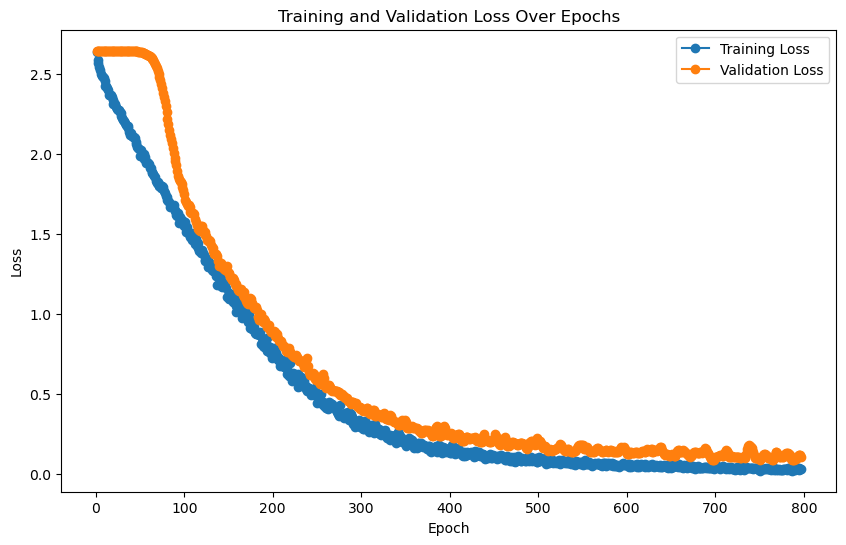

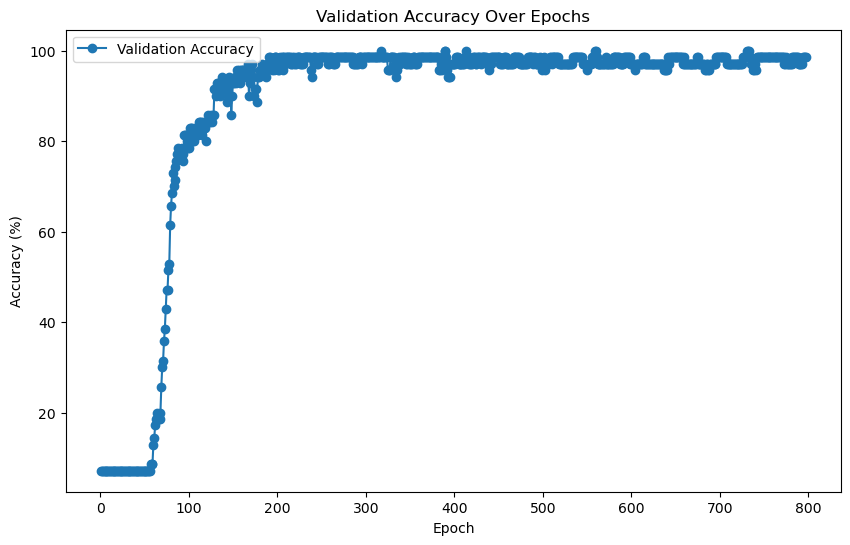


Evaluating on the test set...
    Test Batch [1/12], Loss: 0.0831

Final Test Loss: 0.1517, Test Accuracy: 95.59%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)

LOG: Training features shape: (140, 64), Training labels shape: (140,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (3038, 64), Test labels shape: (3038,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 78.57%

Validation Classification Report:
               precision    recall  f1

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)
Train reps shape: (140, 64)
Train labels shape: (140,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (3038, 64)
Test labels shape: (3038,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8647  |  Val Loss: 2.7294
Validation loss improved from inf to 2.7294.
[Epoch 2/1000] Train Loss: 2.6995  |  Val Loss: 2.6649
Validation loss improved from 2.7294 to 2.6649.
[Epoch 3/1000] Train Loss: 2.6536  |  Val Loss: 2.6427
Validation loss improved from 2.6649 to 2.6427.
[Epoch 4/1000] Train Loss: 2.6392  |  Val Loss: 2.6348
Validation loss improved from 2.6427 to 2.6348.
[Epoch 5/1000] Train Loss: 2.6311  |  Val Loss: 2.6181
Validation loss improved from 2.6348 to 2.6181.
[Epoch 6/1000] Train Loss: 2.6164  |  Val Loss: 2.6094
Validation loss improved from 2.6181 to 2.6094.
[Epoch 7/1000] Train Loss: 2.6051  |  Val Loss: 2.6036
Validation loss improved from 2.6094 to 2.6036.
[Epoch 8/1000] Train Loss: 2.5995  |  Val Loss: 2.6021
Validation loss improved from 2.6036 to 2.6021.
[Epoch 9/1000] Train Loss: 2.5972  |  Val Loss: 2.5991
Validation loss improved from 2.6021 to 2.5991.
[Epoch 10/1000] Train Loss: 2.5915  |  Val Loss: 2.5882
Validation loss impr

[Epoch 26/1000] Train Loss: 2.4488  |  Val Loss: 2.4529
Validation loss improved from 2.4654 to 2.4529.
[Epoch 27/1000] Train Loss: 2.4330  |  Val Loss: 2.4440
Validation loss improved from 2.4529 to 2.4440.
[Epoch 28/1000] Train Loss: 2.4240  |  Val Loss: 2.4328
Validation loss improved from 2.4440 to 2.4328.
[Epoch 29/1000] Train Loss: 2.4128  |  Val Loss: 2.4164
Validation loss improved from 2.4328 to 2.4164.
[Epoch 30/1000] Train Loss: 2.3979  |  Val Loss: 2.4008
Validation loss improved from 2.4164 to 2.4008.
[Epoch 31/1000] Train Loss: 2.3802  |  Val Loss: 2.3791
Validation loss improved from 2.4008 to 2.3791.
[Epoch 32/1000] Train Loss: 2.3596  |  Val Loss: 2.3754
Validation loss improved from 2.3791 to 2.3754.
[Epoch 33/1000] Train Loss: 2.3440  |  Val Loss: 2.3435
Validation loss improved from 2.3754 to 2.3435.
[Epoch 34/1000] Train Loss: 2.3299  |  Val Loss: 2.3323
Validation loss improved from 2.3435 to 2.3323.
[Epoch 35/1000] Train Loss: 2.3035  |  Val Loss: 2.3205
Validati

[Epoch 56/1000] Train Loss: 1.8957  |  Val Loss: 1.9223
Validation loss improved from 1.9299 to 1.9223.
[Epoch 57/1000] Train Loss: 1.8831  |  Val Loss: 1.9009
Validation loss improved from 1.9223 to 1.9009.
[Epoch 58/1000] Train Loss: 1.8638  |  Val Loss: 1.8836
Validation loss improved from 1.9009 to 1.8836.
[Epoch 59/1000] Train Loss: 1.8430  |  Val Loss: 1.8691
Validation loss improved from 1.8836 to 1.8691.
[Epoch 60/1000] Train Loss: 1.8267  |  Val Loss: 1.8569
Validation loss improved from 1.8691 to 1.8569.
[Epoch 61/1000] Train Loss: 1.8135  |  Val Loss: 1.8380
Validation loss improved from 1.8569 to 1.8380.
[Epoch 62/1000] Train Loss: 1.7936  |  Val Loss: 1.8212
Validation loss improved from 1.8380 to 1.8212.
[Epoch 63/1000] Train Loss: 1.7816  |  Val Loss: 1.8035
Validation loss improved from 1.8212 to 1.8035.
[Epoch 64/1000] Train Loss: 1.7625  |  Val Loss: 1.7885
Validation loss improved from 1.8035 to 1.7885.
[Epoch 65/1000] Train Loss: 1.7489  |  Val Loss: 1.7786
Validati

[Epoch 88/1000] Train Loss: 1.5340  |  Val Loss: 1.5828
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 89/1000] Train Loss: 1.5167  |  Val Loss: 1.5733
Validation loss improved from 1.5776 to 1.5733.
[Epoch 90/1000] Train Loss: 1.5094  |  Val Loss: 1.5819
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 91/1000] Train Loss: 1.4801  |  Val Loss: 1.6089
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 92/1000] Train Loss: 1.5290  |  Val Loss: 1.5397
Validation loss improved from 1.5733 to 1.5397.
[Epoch 93/1000] Train Loss: 1.4824  |  Val Loss: 1.5381
Validation loss improved from 1.5397 to 1.5381.
[Epoch 94/1000] Train Loss: 1.4938  |  Val Loss: 1.5525
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 95/1000] Train Loss: 1.4803  |  Val Loss: 1.5702
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 96/1000] Train Loss: 1.4708  |  Val Loss: 1.5405
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 97/1000] Train Loss: 

[Epoch 118/1000] Train Loss: 1.3307  |  Val Loss: 1.4336
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 119/1000] Train Loss: 1.3304  |  Val Loss: 1.4579
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 120/1000] Train Loss: 1.3540  |  Val Loss: 1.4249
Validation loss improved from 1.4287 to 1.4249.
[Epoch 121/1000] Train Loss: 1.3248  |  Val Loss: 1.4179
Validation loss improved from 1.4249 to 1.4179.
[Epoch 122/1000] Train Loss: 1.3287  |  Val Loss: 1.4285
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 123/1000] Train Loss: 1.3162  |  Val Loss: 1.4257
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 124/1000] Train Loss: 1.3131  |  Val Loss: 1.4345
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 125/1000] Train Loss: 1.3219  |  Val Loss: 1.4186
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 126/1000] Train Loss: 1.3135  |  Val Loss: 1.4072
Validation loss improved from 1.4179 to 1.4072.
[Epoch 127/1000] Tr

[Epoch 147/1000] Train Loss: 1.2806  |  Val Loss: 1.3607
Validation loss improved from 1.3624 to 1.3607.
[Epoch 148/1000] Train Loss: 1.2440  |  Val Loss: 1.3947
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 149/1000] Train Loss: 1.2618  |  Val Loss: 1.3701
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 150/1000] Train Loss: 1.2353  |  Val Loss: 1.3995
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 151/1000] Train Loss: 1.2662  |  Val Loss: 1.3769
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 152/1000] Train Loss: 1.2599  |  Val Loss: 1.3575
Validation loss improved from 1.3607 to 1.3575.
[Epoch 153/1000] Train Loss: 1.2529  |  Val Loss: 1.3579
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 154/1000] Train Loss: 1.2314  |  Val Loss: 1.3694
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 155/1000] Train Loss: 1.2406  |  Val Loss: 1.3651
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 156/10

[Epoch 179/1000] Train Loss: 1.1939  |  Val Loss: 1.3337
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 180/1000] Train Loss: 1.1885  |  Val Loss: 1.3207
Validation loss improved from 1.3326 to 1.3207.
[Epoch 181/1000] Train Loss: 1.1821  |  Val Loss: 1.3248
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 182/1000] Train Loss: 1.1842  |  Val Loss: 1.3163
Validation loss improved from 1.3207 to 1.3163.
[Epoch 183/1000] Train Loss: 1.1725  |  Val Loss: 1.3417
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 184/1000] Train Loss: 1.1988  |  Val Loss: 1.3194
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 185/1000] Train Loss: 1.1809  |  Val Loss: 1.3225
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 186/1000] Train Loss: 1.1763  |  Val Loss: 1.3240
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 187/1000] Train Loss: 1.1775  |  Val Loss: 1.3214
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 188/10

[Epoch 211/1000] Train Loss: 1.1740  |  Val Loss: 1.3132
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 212/1000] Train Loss: 1.1714  |  Val Loss: 1.2961
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 213/1000] Train Loss: 1.1546  |  Val Loss: 1.4042
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 214/1000] Train Loss: 1.2553  |  Val Loss: 1.4985
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 215/1000] Train Loss: 1.4215  |  Val Loss: 1.2911
Validation loss improved from 1.2945 to 1.2911.
[Epoch 216/1000] Train Loss: 1.2427  |  Val Loss: 1.2966
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 217/1000] Train Loss: 1.1595  |  Val Loss: 1.5515
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 218/1000] Train Loss: 1.3053  |  Val Loss: 1.4092
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 219/1000] Train Loss: 1.2404  |  Val Loss: 1.3022
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 241/1000] Train Loss: 1.1287  |  Val Loss: 1.2821
Validation loss improved from 1.2834 to 1.2821.
[Epoch 242/1000] Train Loss: 1.1179  |  Val Loss: 1.2787
Validation loss improved from 1.2821 to 1.2787.
[Epoch 243/1000] Train Loss: 1.1222  |  Val Loss: 1.2790
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 244/1000] Train Loss: 1.1228  |  Val Loss: 1.2837
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 245/1000] Train Loss: 1.1251  |  Val Loss: 1.2745
Validation loss improved from 1.2787 to 1.2745.
[Epoch 246/1000] Train Loss: 1.1157  |  Val Loss: 1.2730
Validation loss improved from 1.2745 to 1.2730.
[Epoch 247/1000] Train Loss: 1.1150  |  Val Loss: 1.2701
Validation loss improved from 1.2730 to 1.2701.
[Epoch 248/1000] Train Loss: 1.1209  |  Val Loss: 1.2707
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 249/1000] Train Loss: 1.1109  |  Val Loss: 1.2753
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 250/1000] Train Loss: 1.

[Epoch 270/1000] Train Loss: 1.1909  |  Val Loss: 1.3489
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 271/1000] Train Loss: 1.1953  |  Val Loss: 1.2895
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 272/1000] Train Loss: 1.1303  |  Val Loss: 1.3531
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 273/1000] Train Loss: 1.1566  |  Val Loss: 1.2887
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 274/1000] Train Loss: 1.1118  |  Val Loss: 1.2950
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 275/1000] Train Loss: 1.1351  |  Val Loss: 1.2731
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 276/1000] Train Loss: 1.1165  |  Val Loss: 1.2725
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 277/1000] Train Loss: 1.1212  |  Val Loss: 1.2706
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 278/1000] Train Loss: 1.1234  |  Val Loss: 1.2785
!! Validation loss did NOT improve !! Patience:

[Epoch 299/1000] Train Loss: 1.1215  |  Val Loss: 1.3014
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 300/1000] Train Loss: 1.1234  |  Val Loss: 1.2855
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 301/1000] Train Loss: 1.1127  |  Val Loss: 1.2632
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 302/1000] Train Loss: 1.0957  |  Val Loss: 1.2622
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 303/1000] Train Loss: 1.0981  |  Val Loss: 1.2826
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 304/1000] Train Loss: 1.1077  |  Val Loss: 1.2759
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 305/1000] Train Loss: 1.1037  |  Val Loss: 1.2978
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 306/1000] Train Loss: 1.1137  |  Val Loss: 1.2687
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 307/1000] Train Loss: 1.1035  |  Val Loss: 1.2776
!! Validation loss did NOT improve !! Patience:

[Epoch 331/1000] Train Loss: 1.0774  |  Val Loss: 1.2689
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 332/1000] Train Loss: 1.1138  |  Val Loss: 1.2769
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 333/1000] Train Loss: 1.1060  |  Val Loss: 1.2863
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 334/1000] Train Loss: 1.0870  |  Val Loss: 1.2837
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 335/1000] Train Loss: 1.0938  |  Val Loss: 1.2888
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 336/1000] Train Loss: 1.0914  |  Val Loss: 1.2794
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 337/1000] Train Loss: 1.1258  |  Val Loss: 1.2580
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 338/1000] Train Loss: 1.0983  |  Val Loss: 1.2659
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 339/1000] Train Loss: 1.0991  |  Val Loss: 1.2610
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 365/1000] Train Loss: 1.1205  |  Val Loss: 1.2798
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 366/1000] Train Loss: 1.1584  |  Val Loss: 1.2541
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 367/1000] Train Loss: 1.0782  |  Val Loss: 1.3948
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 368/1000] Train Loss: 1.1576  |  Val Loss: 1.2808
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 369/1000] Train Loss: 1.1118  |  Val Loss: 1.2675
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 370/1000] Train Loss: 1.0996  |  Val Loss: 1.3394
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 371/1000] Train Loss: 1.1187  |  Val Loss: 1.2661
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 372/1000] Train Loss: 1.0955  |  Val Loss: 1.2585
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 373/1000] Train Loss: 1.0755  |  Val Loss: 1.2866
!! Validation loss did NOT improve !! Patience:

[Epoch 396/1000] Train Loss: 1.0815  |  Val Loss: 1.2322
Validation loss improved from 1.2414 to 1.2322.
[Epoch 397/1000] Train Loss: 1.0696  |  Val Loss: 1.2296
Validation loss improved from 1.2322 to 1.2296.
[Epoch 398/1000] Train Loss: 1.0643  |  Val Loss: 1.2403
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 399/1000] Train Loss: 1.0749  |  Val Loss: 1.2425
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 400/1000] Train Loss: 1.0946  |  Val Loss: 1.2940
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 401/1000] Train Loss: 1.0956  |  Val Loss: 1.3268
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 402/1000] Train Loss: 1.1388  |  Val Loss: 1.2666
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 403/1000] Train Loss: 1.0885  |  Val Loss: 1.2844
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 404/1000] Train Loss: 1.0950  |  Val Loss: 1.2600
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 405/10

[Epoch 427/1000] Train Loss: 1.1139  |  Val Loss: 1.2367
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 428/1000] Train Loss: 1.1124  |  Val Loss: 1.2329
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 429/1000] Train Loss: 1.0535  |  Val Loss: 1.3075
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 430/1000] Train Loss: 1.0999  |  Val Loss: 1.2308
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 431/1000] Train Loss: 1.0644  |  Val Loss: 1.2275
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 432/1000] Train Loss: 1.0526  |  Val Loss: 1.2510
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 433/1000] Train Loss: 1.0628  |  Val Loss: 1.2486
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 434/1000] Train Loss: 1.0660  |  Val Loss: 1.2481
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 435/1000] Train Loss: 1.0555  |  Val Loss: 1.2543
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 456/1000] Train Loss: 1.0446  |  Val Loss: 1.2284
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 457/1000] Train Loss: 1.0472  |  Val Loss: 1.2346
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 458/1000] Train Loss: 1.0666  |  Val Loss: 1.2342
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 459/1000] Train Loss: 1.0632  |  Val Loss: 1.2289
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 460/1000] Train Loss: 1.0579  |  Val Loss: 1.2276
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 461/1000] Train Loss: 1.0648  |  Val Loss: 1.2360
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 462/1000] Train Loss: 1.0565  |  Val Loss: 1.2882
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 463/1000] Train Loss: 1.0929  |  Val Loss: 1.2528
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 464/1000] Train Loss: 1.0624  |  Val Loss: 1.2371
!! Validation loss did NOT improve !! Patience: 1

[Epoch 487/1000] Train Loss: 1.0553  |  Val Loss: 1.2670
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 488/1000] Train Loss: 1.0688  |  Val Loss: 1.2533
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 489/1000] Train Loss: 1.0515  |  Val Loss: 1.2333
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 490/1000] Train Loss: 1.0394  |  Val Loss: 1.2295
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 491/1000] Train Loss: 1.0298  |  Val Loss: 1.2767
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 492/1000] Train Loss: 1.0573  |  Val Loss: 1.2469
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 493/1000] Train Loss: 1.0718  |  Val Loss: 1.2540
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 494/1000] Train Loss: 1.0618  |  Val Loss: 1.2476
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 495/1000] Train Loss: 1.0441  |  Val Loss: 1.2351
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 516/1000] Train Loss: 1.0461  |  Val Loss: 1.2647
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 517/1000] Train Loss: 1.0617  |  Val Loss: 1.2357
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 518/1000] Train Loss: 1.0430  |  Val Loss: 1.2280
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 519/1000] Train Loss: 1.0423  |  Val Loss: 1.2302
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 520/1000] Train Loss: 1.0449  |  Val Loss: 1.2559
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 521/1000] Train Loss: 1.0453  |  Val Loss: 1.2211
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 522/1000] Train Loss: 1.0329  |  Val Loss: 1.2243
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 523/1000] Train Loss: 1.0289  |  Val Loss: 1.2263
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 524/1000] Train Loss: 1.0275  |  Val Loss: 1.2384
!! Validation loss did NOT improve !! Patience:

[Epoch 541/1000] Train Loss: 1.0599  |  Val Loss: 1.2716
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 542/1000] Train Loss: 1.0613  |  Val Loss: 1.3056
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 543/1000] Train Loss: 1.0768  |  Val Loss: 1.2352
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 544/1000] Train Loss: 1.0372  |  Val Loss: 1.2338
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 545/1000] Train Loss: 1.0299  |  Val Loss: 1.2580
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 546/1000] Train Loss: 1.0595  |  Val Loss: 1.2421
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 547/1000] Train Loss: 1.0335  |  Val Loss: 1.2379
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 548/1000] Train Loss: 1.0567  |  Val Loss: 1.2444
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 549/1000] Train Loss: 1.0393  |  Val Loss: 1.3136
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 572/1000] Train Loss: 1.0537  |  Val Loss: 1.2208
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 573/1000] Train Loss: 1.0302  |  Val Loss: 1.2835
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 574/1000] Train Loss: 1.0538  |  Val Loss: 1.2360
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 575/1000] Train Loss: 1.0362  |  Val Loss: 1.2397
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 576/1000] Train Loss: 1.0411  |  Val Loss: 1.2364
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 577/1000] Train Loss: 1.0289  |  Val Loss: 1.2572
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 578/1000] Train Loss: 1.0540  |  Val Loss: 1.2315
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 579/1000] Train Loss: 1.0193  |  Val Loss: 1.2224
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 580/1000] Train Loss: 1.0223  |  Val Loss: 1.2181
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 599/1000] Train Loss: 1.0576  |  Val Loss: 1.2201
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 600/1000] Train Loss: 1.0317  |  Val Loss: 1.2440
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 601/1000] Train Loss: 1.0323  |  Val Loss: 1.2322
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 602/1000] Train Loss: 1.0550  |  Val Loss: 1.2184
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 603/1000] Train Loss: 1.0240  |  Val Loss: 1.2215
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 604/1000] Train Loss: 1.0624  |  Val Loss: 1.2772
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 605/1000] Train Loss: 1.1513  |  Val Loss: 1.2351
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 606/1000] Train Loss: 1.0472  |  Val Loss: 1.3998
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 607/1000] Train Loss: 1.1657  |  Val Loss: 1.2648
!! Validation loss did NOT improve !! Patience:

[Epoch 628/1000] Train Loss: 1.0350  |  Val Loss: 1.2294
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 629/1000] Train Loss: 1.0137  |  Val Loss: 1.2331
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 630/1000] Train Loss: 1.0204  |  Val Loss: 1.2107
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 631/1000] Train Loss: 1.0160  |  Val Loss: 1.2182
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 632/1000] Train Loss: 1.0282  |  Val Loss: 1.2150
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 633/1000] Train Loss: 1.0151  |  Val Loss: 1.2150
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 634/1000] Train Loss: 1.0245  |  Val Loss: 1.2210
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 635/1000] Train Loss: 1.0159  |  Val Loss: 1.2259
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 636/1000] Train Loss: 1.0188  |  Val Loss: 1.2070
Validation loss improved from 1.2073 to 1.2070.

[Epoch 658/1000] Train Loss: 1.0433  |  Val Loss: 1.2782
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 659/1000] Train Loss: 1.0512  |  Val Loss: 1.3508
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 660/1000] Train Loss: 1.0856  |  Val Loss: 1.3081
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 661/1000] Train Loss: 1.1912  |  Val Loss: 1.2310
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 662/1000] Train Loss: 0.9929  |  Val Loss: 1.4394
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 663/1000] Train Loss: 1.1745  |  Val Loss: 1.2506
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 664/1000] Train Loss: 1.1154  |  Val Loss: 1.2596
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 665/1000] Train Loss: 1.0886  |  Val Loss: 1.2993
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 666/1000] Train Loss: 1.0490  |  Val Loss: 1.2714
!! Validation loss did NOT improve !! Patience:

[Epoch 687/1000] Train Loss: 1.0001  |  Val Loss: 1.2347
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 688/1000] Train Loss: 1.0668  |  Val Loss: 1.2108
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 689/1000] Train Loss: 1.0121  |  Val Loss: 1.2889
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 690/1000] Train Loss: 1.0648  |  Val Loss: 1.2264
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 691/1000] Train Loss: 1.0890  |  Val Loss: 1.2214
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 692/1000] Train Loss: 1.0420  |  Val Loss: 1.2695
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 693/1000] Train Loss: 1.0109  |  Val Loss: 1.2595
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 694/1000] Train Loss: 1.0536  |  Val Loss: 1.2480
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 695/1000] Train Loss: 1.0710  |  Val Loss: 1.2243
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 716/1000] Train Loss: 1.0483  |  Val Loss: 1.2647
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 717/1000] Train Loss: 1.0611  |  Val Loss: 1.2684
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 718/1000] Train Loss: 1.0390  |  Val Loss: 1.2689
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 719/1000] Train Loss: 1.0564  |  Val Loss: 1.2598
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 720/1000] Train Loss: 1.0389  |  Val Loss: 1.2518
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 721/1000] Train Loss: 1.0108  |  Val Loss: 1.2503
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 722/1000] Train Loss: 1.0556  |  Val Loss: 1.2353
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 723/1000] Train Loss: 1.0062  |  Val Loss: 1.3112
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 724/1000] Train Loss: 1.0875  |  Val Loss: 1.2400
!! Validation loss did NOT improve !! Patience:

[Epoch 745/1000] Train Loss: 1.0759  |  Val Loss: 1.2493
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 746/1000] Train Loss: 1.0732  |  Val Loss: 1.2192
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 747/1000] Train Loss: 1.0110  |  Val Loss: 1.2214
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 748/1000] Train Loss: 1.0246  |  Val Loss: 1.2413
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 749/1000] Train Loss: 1.0309  |  Val Loss: 1.2156
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 750/1000] Train Loss: 1.0277  |  Val Loss: 1.2203
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 751/1000] Train Loss: 1.0070  |  Val Loss: 1.2795
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 752/1000] Train Loss: 1.0361  |  Val Loss: 1.2133
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 753/1000] Train Loss: 0.9913  |  Val Loss: 1.2170
!! Validation loss did NOT improve !! Patience:

[Epoch 774/1000] Train Loss: 1.0449  |  Val Loss: 1.2079
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 775/1000] Train Loss: 1.0143  |  Val Loss: 1.2383
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 776/1000] Train Loss: 1.0316  |  Val Loss: 1.2016
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 777/1000] Train Loss: 1.0062  |  Val Loss: 1.1876
Validation loss improved from 1.1937 to 1.1876.
[Epoch 778/1000] Train Loss: 0.9967  |  Val Loss: 1.2160
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 779/1000] Train Loss: 1.0042  |  Val Loss: 1.1973
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 780/1000] Train Loss: 1.0464  |  Val Loss: 1.1935
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 781/1000] Train Loss: 0.9948  |  Val Loss: 1.3133
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 782/1000] Train Loss: 1.0529  |  Val Loss: 1.2381
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 805/1000] Train Loss: 1.0157  |  Val Loss: 1.2076
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 806/1000] Train Loss: 0.9933  |  Val Loss: 1.2055
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 807/1000] Train Loss: 1.0019  |  Val Loss: 1.2041
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 808/1000] Train Loss: 0.9943  |  Val Loss: 1.2176
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 809/1000] Train Loss: 1.0048  |  Val Loss: 1.2290
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 810/1000] Train Loss: 1.0186  |  Val Loss: 1.2008
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 811/1000] Train Loss: 1.0350  |  Val Loss: 1.2242
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 812/1000] Train Loss: 1.0376  |  Val Loss: 1.2395
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 813/1000] Train Loss: 1.0160  |  Val Loss: 1.2098
!! Validation loss did NOT improve !! Patience:

[Epoch 834/1000] Train Loss: 1.0192  |  Val Loss: 1.2067
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 835/1000] Train Loss: 1.0125  |  Val Loss: 1.2062
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 836/1000] Train Loss: 1.0245  |  Val Loss: 1.2301
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 837/1000] Train Loss: 1.0042  |  Val Loss: 1.2522
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 838/1000] Train Loss: 1.0462  |  Val Loss: 1.2496
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 839/1000] Train Loss: 1.0467  |  Val Loss: 1.2605
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 840/1000] Train Loss: 1.0212  |  Val Loss: 1.2426
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 841/1000] Train Loss: 1.0247  |  Val Loss: 1.2693
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 842/1000] Train Loss: 1.0151  |  Val Loss: 1.2398
!! Validation loss did NOT improve !! Patience:

[Epoch 865/1000] Train Loss: 1.0009  |  Val Loss: 1.2078
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 866/1000] Train Loss: 0.9926  |  Val Loss: 1.2153
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 867/1000] Train Loss: 0.9882  |  Val Loss: 1.2020
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 868/1000] Train Loss: 0.9957  |  Val Loss: 1.2063
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 869/1000] Train Loss: 0.9951  |  Val Loss: 1.2030
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 870/1000] Train Loss: 1.0244  |  Val Loss: 1.2326
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 871/1000] Train Loss: 1.0369  |  Val Loss: 1.2119
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 872/1000] Train Loss: 1.0112  |  Val Loss: 1.2594
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 873/1000] Train Loss: 1.0329  |  Val Loss: 1.3151
!! Validation loss did NOT improve !! Patience:

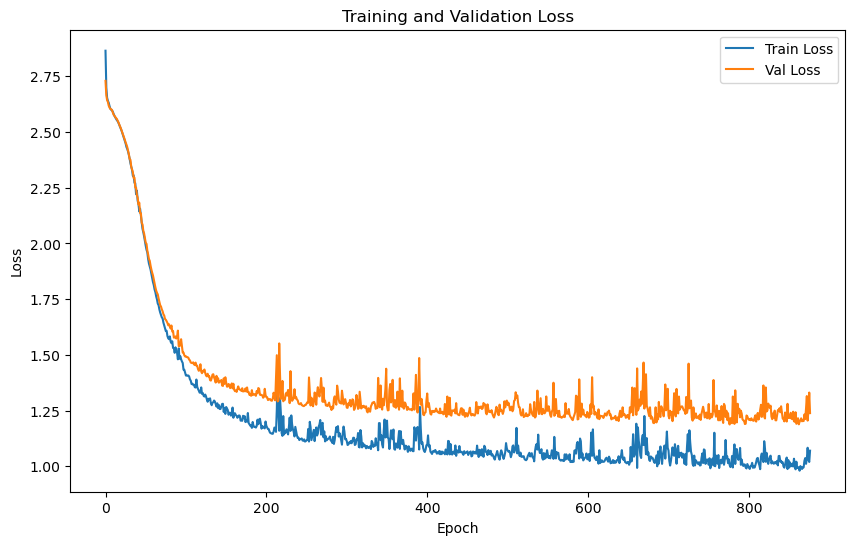

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.3601 | Test Accuracy: 43.25%


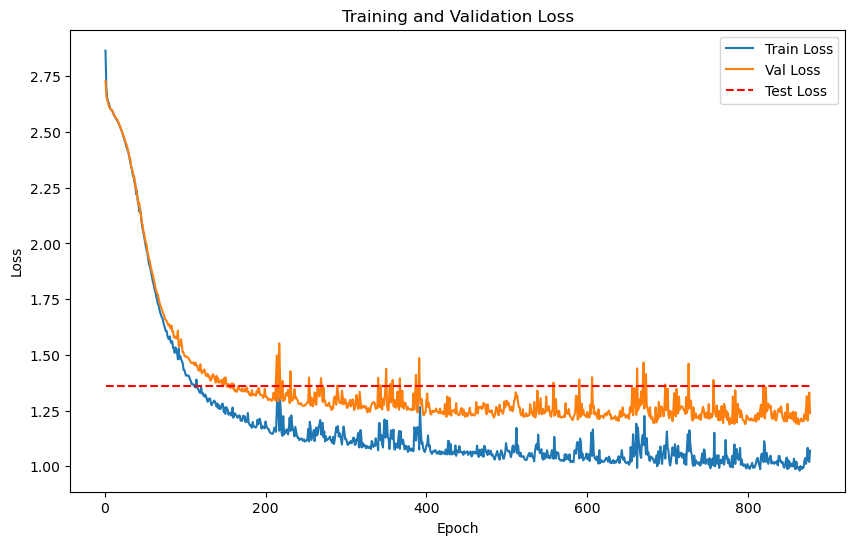

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)


Train embeddings shape: (140, 64), 
Train labels shape: (140,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3038, 64), 
Test labels shape: (3038,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10}
Training batch size: 140


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 7.7307
Epoch [1/2000], Avg Train Loss: 7.7307
Epoch [1/2000], Avg Val Loss: 3.4648
Validation loss improved from inf to 3.4648. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.6676
Epoch [2/2000], Avg Train Loss: 7.6676
Epoch [2/2000], Avg Val Loss: 3.4489
Validation loss improved from 3.4648 to 3.4489. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.4643
Epoch [3/2000], Avg Train Loss: 7.4643
Epoch [3/2000], Avg Val Loss: 3.4337
Validation loss improved from 3.4489 to 3.4337. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.3768
Epoch [4/2000], Avg Train Loss: 7.3768
Epoch [4/2000], Avg Val Loss: 3.4191
Validation loss improved from 3.4337 to 3.4191. Saving model...

LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 7.4904
Epoch [5/2000], Avg Train Loss: 7.4904
Epoch [5/2000], Avg Val Loss: 3.4053
Validation loss improved from 3.4191 to 3.4053. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.4368
Epoch [6/2000], Avg Train Loss: 7.4368
Epoch [6/2000], Avg Val Loss: 3.3922
Validation loss improved from 3.4053 to 3.3922. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 7.4722
Epoch [7/2000], Avg Train Loss: 7.4722
Epoch [7/2000], Avg Val Loss: 3.3798
Validation loss improved from 3.3922 to 3.3798. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 7.3776
Epoch [8/2000], Avg Train Loss: 7.3776
Epoch [8/2000], Avg Val Loss: 3.3680
Validation loss improved from 3.3798 to 3.3680. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 7.0928
Epoch [9/2000], Avg Train Loss: 7.0928
Epoch [9/2000], Avg Val Loss: 3.3569
Validation loss improved from 3.3680 to 3.3569. Saving m

Epoch [17/2000], Avg Val Loss: 3.2882
Validation loss improved from 3.2951 to 3.2882. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 6.3934
Epoch [18/2000], Avg Train Loss: 6.3934
Epoch [18/2000], Avg Val Loss: 3.2816
Validation loss improved from 3.2882 to 3.2816. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 6.4571
Epoch [19/2000], Avg Train Loss: 6.4571
Epoch [19/2000], Avg Val Loss: 3.2755
Validation loss improved from 3.2816 to 3.2755. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 6.3082
Epoch [20/2000], Avg Train Loss: 6.3082
Epoch [20/2000], Avg Val Loss: 3.2696
Validation loss improved from 3.2755 to 3.2696. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 6.5614
Epoch [21/2000], Avg Train Loss: 6.5614
Epoch [21/2000], Avg Val Loss: 3.2640
Validation loss improved from 3.2696 to 3.2640. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.1970
Epoch [23/2000], Avg Train Loss: 6.1970
Epoch [23/2000], Avg Val Loss: 3.2538
Validation loss improved from 3.2587 to 3.2538. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.0270
Epoch [24/2000], Avg Train Loss: 6.0270
Epoch [24/2000], Avg Val Loss: 3.2493
Validation loss improved from 3.2538 to 3.2493. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.0632
Epoch [25/2000], Avg Train Loss: 6.0632
Epoch [25/2000], Avg Val Loss: 3.2451
Validation loss improved from 3.2493 to 3.2451. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.1394
Epoch [26/2000], Avg Train Loss: 6.1394
Epoch [26/2000], Avg Val Loss: 3.2411
Validation loss improved from 3.2451 to 3.2411. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.1532
Epoch [27/2000], Avg Train Loss: 6.1532
Epoch [27/2000], Avg Val Loss: 3.2374
Validation loss improved from 3.2411 to 3.

Epoch [50/2000], Avg Val Loss: 3.1987
Validation loss improved from 3.1992 to 3.1987. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.3425
Epoch [51/2000], Avg Train Loss: 5.3425
Epoch [51/2000], Avg Val Loss: 3.1983
Validation loss improved from 3.1987 to 3.1983. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.1721
Epoch [52/2000], Avg Train Loss: 5.1721
Epoch [52/2000], Avg Val Loss: 3.1979
Validation loss improved from 3.1983 to 3.1979. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.2086
Epoch [53/2000], Avg Train Loss: 5.2086
Epoch [53/2000], Avg Val Loss: 3.1976
Validation loss improved from 3.1979 to 3.1976. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.1422
Epoch [54/2000], Avg Train Loss: 5.1422
Epoch [54/2000], Avg Val Loss: 3.1973
Validation loss improved from 3.1976 to 3.1973. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Trai

Epoch [61/2000], Avg Val Loss: 3.1959
Validation loss improved from 3.1960 to 3.1959. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.0428
Epoch [62/2000], Avg Train Loss: 5.0428
Epoch [62/2000], Avg Val Loss: 3.1958
Validation loss improved from 3.1959 to 3.1958. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.0695
Epoch [63/2000], Avg Train Loss: 5.0695
Epoch [63/2000], Avg Val Loss: 3.1957
Validation loss improved from 3.1958 to 3.1957. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.0920
Epoch [64/2000], Avg Train Loss: 5.0920
Epoch [64/2000], Avg Val Loss: 3.1956
Validation loss improved from 3.1957 to 3.1956. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 4.9072
Epoch [65/2000], Avg Train Loss: 4.9072
Epoch [65/2000], Avg Val Loss: 3.1955
Validation loss improved from 3.1956 to 3.1955. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.6017
Epoch [91/2000], Avg Train Loss: 4.6017
Epoch [91/2000], Avg Val Loss: 3.1928
Validation loss improved from 3.1929 to 3.1928. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 4.6833
Epoch [92/2000], Avg Train Loss: 4.6833
Epoch [92/2000], Avg Val Loss: 3.1927
Validation loss improved from 3.1928 to 3.1927. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 4.6575
Epoch [93/2000], Avg Train Loss: 4.6575
Epoch [93/2000], Avg Val Loss: 3.1925
Validation loss improved from 3.1927 to 3.1925. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 4.6073
Epoch [94/2000], Avg Train Loss: 4.6073
Epoch [94/2000], Avg Val Loss: 3.1924
Validation loss improved from 3.1925 to 3.1924. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 4.5071
Epoch [95/2000], Avg Train Loss: 4.5071
Epoch [95/2000], Avg Val Loss: 3.1922
Validation loss improved from 3.1924 to 3.

Epoch [106/2000], Avg Val Loss: 3.1892
Validation loss improved from 3.1895 to 3.1892. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.4439
Epoch [107/2000], Avg Train Loss: 4.4439
Epoch [107/2000], Avg Val Loss: 3.1888
Validation loss improved from 3.1892 to 3.1888. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.5149
Epoch [108/2000], Avg Train Loss: 4.5149
Epoch [108/2000], Avg Val Loss: 3.1884
Validation loss improved from 3.1888 to 3.1884. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.5692
Epoch [109/2000], Avg Train Loss: 4.5692
Epoch [109/2000], Avg Val Loss: 3.1880
Validation loss improved from 3.1884 to 3.1880. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 4.5234
Epoch [110/2000], Avg Train Loss: 4.5234
Epoch [110/2000], Avg Val Loss: 3.1877
Validation loss improved from 3.1880 to 3.1877. Saving model...

LOG: Epoch [111/2000] - Training
    Bat

Epoch [132/2000], Avg Val Loss: 3.1776
Validation loss improved from 3.1782 to 3.1776. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 4.4121
Epoch [133/2000], Avg Train Loss: 4.4121
Epoch [133/2000], Avg Val Loss: 3.1770
Validation loss improved from 3.1776 to 3.1770. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 4.4033
Epoch [134/2000], Avg Train Loss: 4.4033
Epoch [134/2000], Avg Val Loss: 3.1763
Validation loss improved from 3.1770 to 3.1763. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 4.4882
Epoch [135/2000], Avg Train Loss: 4.4882
Epoch [135/2000], Avg Val Loss: 3.1757
Validation loss improved from 3.1763 to 3.1757. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 4.4104
Epoch [136/2000], Avg Train Loss: 4.4104
Epoch [136/2000], Avg Val Loss: 3.1751
Validation loss improved from 3.1757 to 3.1751. Saving model...

LOG: Epoch [137/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2955
Epoch [149/2000], Avg Train Loss: 4.2955
Epoch [149/2000], Avg Val Loss: 3.1665
Validation loss improved from 3.1672 to 3.1665. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 4.3411
Epoch [150/2000], Avg Train Loss: 4.3411
Epoch [150/2000], Avg Val Loss: 3.1658
Validation loss improved from 3.1665 to 3.1658. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 4.2858
Epoch [151/2000], Avg Train Loss: 4.2858
Epoch [151/2000], Avg Val Loss: 3.1651
Validation loss improved from 3.1658 to 3.1651. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 4.2666
Epoch [152/2000], Avg Train Loss: 4.2666
Epoch [152/2000], Avg Val Loss: 3.1643
Validation loss improved from 3.1651 to 3.1643. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 4.2768
Epoch [153/2000], Avg Train Loss: 4.2768
Epoch [153/2000], Avg Val Loss: 3.1635
Validation loss improved fro

Epoch [174/2000], Avg Val Loss: 3.1462
Validation loss improved from 3.1471 to 3.1462. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 4.2376
Epoch [175/2000], Avg Train Loss: 4.2376
Epoch [175/2000], Avg Val Loss: 3.1454
Validation loss improved from 3.1462 to 3.1454. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 4.2720
Epoch [176/2000], Avg Train Loss: 4.2720
Epoch [176/2000], Avg Val Loss: 3.1446
Validation loss improved from 3.1454 to 3.1446. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 4.2152
Epoch [177/2000], Avg Train Loss: 4.2152
Epoch [177/2000], Avg Val Loss: 3.1437
Validation loss improved from 3.1446 to 3.1437. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 4.2291
Epoch [178/2000], Avg Train Loss: 4.2291
Epoch [178/2000], Avg Val Loss: 3.1428
Validation loss improved from 3.1437 to 3.1428. Saving model...

LOG: Epoch [179/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1686
Epoch [196/2000], Avg Train Loss: 4.1686
Epoch [196/2000], Avg Val Loss: 3.1258
Validation loss improved from 3.1268 to 3.1258. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 4.1701
Epoch [197/2000], Avg Train Loss: 4.1701
Epoch [197/2000], Avg Val Loss: 3.1248
Validation loss improved from 3.1258 to 3.1248. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 4.1968
Epoch [198/2000], Avg Train Loss: 4.1968
Epoch [198/2000], Avg Val Loss: 3.1238
Validation loss improved from 3.1248 to 3.1238. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 4.1938
Epoch [199/2000], Avg Train Loss: 4.1938
Epoch [199/2000], Avg Val Loss: 3.1228
Validation loss improved from 3.1238 to 3.1228. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 4.2385
Epoch [200/2000], Avg Train Loss: 4.2385
Epoch [200/2000], Avg Val Loss: 3.1219
Validation loss improved fro

Epoch [217/2000], Avg Val Loss: 3.1057
Validation loss improved from 3.1067 to 3.1057. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 4.0940
Epoch [218/2000], Avg Train Loss: 4.0940
Epoch [218/2000], Avg Val Loss: 3.1047
Validation loss improved from 3.1057 to 3.1047. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 4.1366
Epoch [219/2000], Avg Train Loss: 4.1366
Epoch [219/2000], Avg Val Loss: 3.1037
Validation loss improved from 3.1047 to 3.1037. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 4.1321
Epoch [220/2000], Avg Train Loss: 4.1321
Epoch [220/2000], Avg Val Loss: 3.1028
Validation loss improved from 3.1037 to 3.1028. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 4.1532
Epoch [221/2000], Avg Train Loss: 4.1532
Epoch [221/2000], Avg Val Loss: 3.1018
Validation loss improved from 3.1028 to 3.1018. Saving model...

LOG: Epoch [222/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1161
Epoch [237/2000], Avg Train Loss: 4.1161
Epoch [237/2000], Avg Val Loss: 3.0857
Validation loss improved from 3.0867 to 3.0857. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 4.0541
Epoch [238/2000], Avg Train Loss: 4.0541
Epoch [238/2000], Avg Val Loss: 3.0846
Validation loss improved from 3.0857 to 3.0846. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 4.0382
Epoch [239/2000], Avg Train Loss: 4.0382
Epoch [239/2000], Avg Val Loss: 3.0836
Validation loss improved from 3.0846 to 3.0836. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 4.0822
Epoch [240/2000], Avg Train Loss: 4.0822
Epoch [240/2000], Avg Val Loss: 3.0826
Validation loss improved from 3.0836 to 3.0826. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 4.0964
Epoch [241/2000], Avg Train Loss: 4.0964
Epoch [241/2000], Avg Val Loss: 3.0816
Validation loss improved fro

Epoch [261/2000], Avg Val Loss: 3.0607
Validation loss improved from 3.0617 to 3.0607. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 4.0131
Epoch [262/2000], Avg Train Loss: 4.0131
Epoch [262/2000], Avg Val Loss: 3.0596
Validation loss improved from 3.0607 to 3.0596. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 4.0285
Epoch [263/2000], Avg Train Loss: 4.0285
Epoch [263/2000], Avg Val Loss: 3.0586
Validation loss improved from 3.0596 to 3.0586. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 4.0716
Epoch [264/2000], Avg Train Loss: 4.0716
Epoch [264/2000], Avg Val Loss: 3.0576
Validation loss improved from 3.0586 to 3.0576. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 4.0236
Epoch [265/2000], Avg Train Loss: 4.0236
Epoch [265/2000], Avg Val Loss: 3.0565
Validation loss improved from 3.0576 to 3.0565. Saving model...

LOG: Epoch [266/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9793
Epoch [280/2000], Avg Train Loss: 3.9793
Epoch [280/2000], Avg Val Loss: 3.0410
Validation loss improved from 3.0421 to 3.0410. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 4.0317
Epoch [281/2000], Avg Train Loss: 4.0317
Epoch [281/2000], Avg Val Loss: 3.0400
Validation loss improved from 3.0410 to 3.0400. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 3.9684
Epoch [282/2000], Avg Train Loss: 3.9684
Epoch [282/2000], Avg Val Loss: 3.0390
Validation loss improved from 3.0400 to 3.0390. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 4.0333
Epoch [283/2000], Avg Train Loss: 4.0333
Epoch [283/2000], Avg Val Loss: 3.0380
Validation loss improved from 3.0390 to 3.0380. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 4.0146
Epoch [284/2000], Avg Train Loss: 4.0146
Epoch [284/2000], Avg Val Loss: 3.0371
Validation loss improved fro

Epoch [302/2000], Avg Val Loss: 3.0178
Validation loss improved from 3.0189 to 3.0178. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 3.9337
Epoch [303/2000], Avg Train Loss: 3.9337
Epoch [303/2000], Avg Val Loss: 3.0167
Validation loss improved from 3.0178 to 3.0167. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 3.9074
Epoch [304/2000], Avg Train Loss: 3.9074
Epoch [304/2000], Avg Val Loss: 3.0156
Validation loss improved from 3.0167 to 3.0156. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 3.9414
Epoch [305/2000], Avg Train Loss: 3.9414
Epoch [305/2000], Avg Val Loss: 3.0144
Validation loss improved from 3.0156 to 3.0144. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 3.9494
Epoch [306/2000], Avg Train Loss: 3.9494
Epoch [306/2000], Avg Val Loss: 3.0133
Validation loss improved from 3.0144 to 3.0133. Saving model...

LOG: Epoch [307/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9446
Epoch [321/2000], Avg Train Loss: 3.9446
Epoch [321/2000], Avg Val Loss: 2.9966
Validation loss improved from 2.9977 to 2.9966. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 3.9146
Epoch [322/2000], Avg Train Loss: 3.9146
Epoch [322/2000], Avg Val Loss: 2.9955
Validation loss improved from 2.9966 to 2.9955. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 3.8678
Epoch [323/2000], Avg Train Loss: 3.8678
Epoch [323/2000], Avg Val Loss: 2.9944
Validation loss improved from 2.9955 to 2.9944. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 3.9257
Epoch [324/2000], Avg Train Loss: 3.9257
Epoch [324/2000], Avg Val Loss: 2.9932
Validation loss improved from 2.9944 to 2.9932. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 3.9672
Epoch [325/2000], Avg Train Loss: 3.9672
Epoch [325/2000], Avg Val Loss: 2.9921
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9097
Epoch [346/2000], Avg Train Loss: 3.9097
Epoch [346/2000], Avg Val Loss: 2.9686
Validation loss improved from 2.9698 to 2.9686. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 3.8876
Epoch [347/2000], Avg Train Loss: 3.8876
Epoch [347/2000], Avg Val Loss: 2.9675
Validation loss improved from 2.9686 to 2.9675. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 3.8902
Epoch [348/2000], Avg Train Loss: 3.8902
Epoch [348/2000], Avg Val Loss: 2.9663
Validation loss improved from 2.9675 to 2.9663. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 3.9416
Epoch [349/2000], Avg Train Loss: 3.9416
Epoch [349/2000], Avg Val Loss: 2.9651
Validation loss improved from 2.9663 to 2.9651. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 3.9328
Epoch [350/2000], Avg Train Loss: 3.9328
Epoch [350/2000], Avg Val Loss: 2.9640
Validation loss improved fro

Epoch [361/2000], Avg Val Loss: 2.9510
Validation loss improved from 2.9521 to 2.9510. Saving model...

LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 3.8679
Epoch [362/2000], Avg Train Loss: 3.8679
Epoch [362/2000], Avg Val Loss: 2.9498
Validation loss improved from 2.9510 to 2.9498. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 3.9301
Epoch [363/2000], Avg Train Loss: 3.9301
Epoch [363/2000], Avg Val Loss: 2.9486
Validation loss improved from 2.9498 to 2.9486. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 3.8716
Epoch [364/2000], Avg Train Loss: 3.8716
Epoch [364/2000], Avg Val Loss: 2.9475
Validation loss improved from 2.9486 to 2.9475. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 3.8336
Epoch [365/2000], Avg Train Loss: 3.8336
Epoch [365/2000], Avg Val Loss: 2.9464
Validation loss improved from 2.9475 to 2.9464. Saving model...

LOG: Epoch [366/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8289
Epoch [390/2000], Avg Train Loss: 3.8289
Epoch [390/2000], Avg Val Loss: 2.9168
Validation loss improved from 2.9179 to 2.9168. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 3.7767
Epoch [391/2000], Avg Train Loss: 3.7767
Epoch [391/2000], Avg Val Loss: 2.9157
Validation loss improved from 2.9168 to 2.9157. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 3.8222
Epoch [392/2000], Avg Train Loss: 3.8222
Epoch [392/2000], Avg Val Loss: 2.9145
Validation loss improved from 2.9157 to 2.9145. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 3.8245
Epoch [393/2000], Avg Train Loss: 3.8245
Epoch [393/2000], Avg Val Loss: 2.9133
Validation loss improved from 2.9145 to 2.9133. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 3.7909
Epoch [394/2000], Avg Train Loss: 3.7909
Epoch [394/2000], Avg Val Loss: 2.9121
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8391
Epoch [405/2000], Avg Train Loss: 3.8391
Epoch [405/2000], Avg Val Loss: 2.8990
Validation loss improved from 2.9002 to 2.8990. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 3.7799
Epoch [406/2000], Avg Train Loss: 3.7799
Epoch [406/2000], Avg Val Loss: 2.8978
Validation loss improved from 2.8990 to 2.8978. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 3.8185
Epoch [407/2000], Avg Train Loss: 3.8185
Epoch [407/2000], Avg Val Loss: 2.8966
Validation loss improved from 2.8978 to 2.8966. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 3.7853
Epoch [408/2000], Avg Train Loss: 3.7853
Epoch [408/2000], Avg Val Loss: 2.8954
Validation loss improved from 2.8966 to 2.8954. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 3.8190
Epoch [409/2000], Avg Train Loss: 3.8190
Epoch [409/2000], Avg Val Loss: 2.8942
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7497
Epoch [434/2000], Avg Train Loss: 3.7497
Epoch [434/2000], Avg Val Loss: 2.8642
Validation loss improved from 2.8654 to 2.8642. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 3.7756
Epoch [435/2000], Avg Train Loss: 3.7756
Epoch [435/2000], Avg Val Loss: 2.8629
Validation loss improved from 2.8642 to 2.8629. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 3.7385
Epoch [436/2000], Avg Train Loss: 3.7385
Epoch [436/2000], Avg Val Loss: 2.8617
Validation loss improved from 2.8629 to 2.8617. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 3.8031
Epoch [437/2000], Avg Train Loss: 3.8031
Epoch [437/2000], Avg Val Loss: 2.8604
Validation loss improved from 2.8617 to 2.8604. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 3.7876
Epoch [438/2000], Avg Train Loss: 3.7876
Epoch [438/2000], Avg Val Loss: 2.8592
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7546
Epoch [448/2000], Avg Train Loss: 3.7546
Epoch [448/2000], Avg Val Loss: 2.8466
Validation loss improved from 2.8478 to 2.8466. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 3.7561
Epoch [449/2000], Avg Train Loss: 3.7561
Epoch [449/2000], Avg Val Loss: 2.8454
Validation loss improved from 2.8466 to 2.8454. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 3.7923
Epoch [450/2000], Avg Train Loss: 3.7923
Epoch [450/2000], Avg Val Loss: 2.8441
Validation loss improved from 2.8454 to 2.8441. Saving model...

LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 3.7748
Epoch [451/2000], Avg Train Loss: 3.7748
Epoch [451/2000], Avg Val Loss: 2.8428
Validation loss improved from 2.8441 to 2.8428. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 3.7585
Epoch [452/2000], Avg Train Loss: 3.7585
Epoch [452/2000], Avg Val Loss: 2.8416
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7350
Epoch [478/2000], Avg Train Loss: 3.7350
Epoch [478/2000], Avg Val Loss: 2.8091
Validation loss improved from 2.8103 to 2.8091. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 3.7533
Epoch [479/2000], Avg Train Loss: 3.7533
Epoch [479/2000], Avg Val Loss: 2.8080
Validation loss improved from 2.8091 to 2.8080. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 3.7103
Epoch [480/2000], Avg Train Loss: 3.7103
Epoch [480/2000], Avg Val Loss: 2.8068
Validation loss improved from 2.8080 to 2.8068. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 3.7494
Epoch [481/2000], Avg Train Loss: 3.7494
Epoch [481/2000], Avg Val Loss: 2.8057
Validation loss improved from 2.8068 to 2.8057. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 3.6910
Epoch [482/2000], Avg Train Loss: 3.6910
Epoch [482/2000], Avg Val Loss: 2.8046
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7008
Epoch [492/2000], Avg Train Loss: 3.7008
Epoch [492/2000], Avg Val Loss: 2.7924
Validation loss improved from 2.7936 to 2.7924. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 3.6802
Epoch [493/2000], Avg Train Loss: 3.6802
Epoch [493/2000], Avg Val Loss: 2.7912
Validation loss improved from 2.7924 to 2.7912. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 3.7012
Epoch [494/2000], Avg Train Loss: 3.7012
Epoch [494/2000], Avg Val Loss: 2.7899
Validation loss improved from 2.7912 to 2.7899. Saving model...

LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 3.7190
Epoch [495/2000], Avg Train Loss: 3.7190
Epoch [495/2000], Avg Val Loss: 2.7887
Validation loss improved from 2.7899 to 2.7887. Saving model...

LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 3.6840
Epoch [496/2000], Avg Train Loss: 3.6840
Epoch [496/2000], Avg Val Loss: 2.7874
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6675
Epoch [523/2000], Avg Train Loss: 3.6675
Epoch [523/2000], Avg Val Loss: 2.7535
Validation loss improved from 2.7547 to 2.7535. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 3.6386
Epoch [524/2000], Avg Train Loss: 3.6386
Epoch [524/2000], Avg Val Loss: 2.7523
Validation loss improved from 2.7535 to 2.7523. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 3.6171
Epoch [525/2000], Avg Train Loss: 3.6171
Epoch [525/2000], Avg Val Loss: 2.7511
Validation loss improved from 2.7523 to 2.7511. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 3.6214
Epoch [526/2000], Avg Train Loss: 3.6214
Epoch [526/2000], Avg Val Loss: 2.7499
Validation loss improved from 2.7511 to 2.7499. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 3.6554
Epoch [527/2000], Avg Train Loss: 3.6554
Epoch [527/2000], Avg Val Loss: 2.7487
Validation loss improved fro

Epoch [533/2000], Avg Val Loss: 2.7420
Validation loss improved from 2.7430 to 2.7420. Saving model...

LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 3.6351
Epoch [534/2000], Avg Train Loss: 3.6351
Epoch [534/2000], Avg Val Loss: 2.7409
Validation loss improved from 2.7420 to 2.7409. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 3.5907
Epoch [535/2000], Avg Train Loss: 3.5907
Epoch [535/2000], Avg Val Loss: 2.7398
Validation loss improved from 2.7409 to 2.7398. Saving model...

LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 3.5936
Epoch [536/2000], Avg Train Loss: 3.5936
Epoch [536/2000], Avg Val Loss: 2.7388
Validation loss improved from 2.7398 to 2.7388. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 3.6217
Epoch [537/2000], Avg Train Loss: 3.6217
Epoch [537/2000], Avg Val Loss: 2.7377
Validation loss improved from 2.7388 to 2.7377. Saving model...

LOG: Epoch [538/2000] - Training
    Bat

Epoch [570/2000], Avg Val Loss: 2.6974
Validation loss improved from 2.6985 to 2.6974. Saving model...

LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 3.6238
Epoch [571/2000], Avg Train Loss: 3.6238
Epoch [571/2000], Avg Val Loss: 2.6964
Validation loss improved from 2.6974 to 2.6964. Saving model...

LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 3.5968
Epoch [572/2000], Avg Train Loss: 3.5968
Epoch [572/2000], Avg Val Loss: 2.6954
Validation loss improved from 2.6964 to 2.6954. Saving model...

LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 3.5351
Epoch [573/2000], Avg Train Loss: 3.5351
Epoch [573/2000], Avg Val Loss: 2.6944
Validation loss improved from 2.6954 to 2.6944. Saving model...

LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 3.5460
Epoch [574/2000], Avg Train Loss: 3.5460
Epoch [574/2000], Avg Val Loss: 2.6934
Validation loss improved from 2.6944 to 2.6934. Saving model...

LOG: Epoch [575/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5731
Epoch [576/2000], Avg Train Loss: 3.5731
Epoch [576/2000], Avg Val Loss: 2.6914
Validation loss improved from 2.6924 to 2.6914. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 3.6111
Epoch [577/2000], Avg Train Loss: 3.6111
Epoch [577/2000], Avg Val Loss: 2.6905
Validation loss improved from 2.6914 to 2.6905. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 3.6167
Epoch [578/2000], Avg Train Loss: 3.6167
Epoch [578/2000], Avg Val Loss: 2.6895
Validation loss improved from 2.6905 to 2.6895. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 3.5742
Epoch [579/2000], Avg Train Loss: 3.5742
Epoch [579/2000], Avg Val Loss: 2.6887
Validation loss improved from 2.6895 to 2.6887. Saving model...

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 3.5232
Epoch [580/2000], Avg Train Loss: 3.5232
Epoch [580/2000], Avg Val Loss: 2.6878
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5682
Epoch [615/2000], Avg Train Loss: 3.5682
Epoch [615/2000], Avg Val Loss: 2.6567
Validation loss improved from 2.6574 to 2.6567. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 3.5199
Epoch [616/2000], Avg Train Loss: 3.5199
Epoch [616/2000], Avg Val Loss: 2.6559
Validation loss improved from 2.6567 to 2.6559. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 3.4662
Epoch [617/2000], Avg Train Loss: 3.4662
Epoch [617/2000], Avg Val Loss: 2.6551
Validation loss improved from 2.6559 to 2.6551. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 3.5024
Epoch [618/2000], Avg Train Loss: 3.5024
Epoch [618/2000], Avg Val Loss: 2.6543
Validation loss improved from 2.6551 to 2.6543. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 3.5163
Epoch [619/2000], Avg Train Loss: 3.5163
Epoch [619/2000], Avg Val Loss: 2.6535
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4686
Epoch [624/2000], Avg Train Loss: 3.4686
Epoch [624/2000], Avg Val Loss: 2.6490
Validation loss improved from 2.6500 to 2.6490. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 3.5306
Epoch [625/2000], Avg Train Loss: 3.5306
Epoch [625/2000], Avg Val Loss: 2.6481
Validation loss improved from 2.6490 to 2.6481. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 3.4946
Epoch [626/2000], Avg Train Loss: 3.4946
Epoch [626/2000], Avg Val Loss: 2.6471
Validation loss improved from 2.6481 to 2.6471. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 3.5621
Epoch [627/2000], Avg Train Loss: 3.5621
Epoch [627/2000], Avg Val Loss: 2.6462
Validation loss improved from 2.6471 to 2.6462. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 3.4869
Epoch [628/2000], Avg Train Loss: 3.4869
Epoch [628/2000], Avg Val Loss: 2.6452
Validation loss improved fro

Epoch [658/2000], Avg Val Loss: 2.6177
Validation loss improved from 2.6185 to 2.6177. Saving model...

LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 3.4754
Epoch [659/2000], Avg Train Loss: 3.4754
Epoch [659/2000], Avg Val Loss: 2.6169
Validation loss improved from 2.6177 to 2.6169. Saving model...

LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 3.5052
Epoch [660/2000], Avg Train Loss: 3.5052
Epoch [660/2000], Avg Val Loss: 2.6164
Validation loss improved from 2.6169 to 2.6164. Saving model...

LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 3.4564
Epoch [661/2000], Avg Train Loss: 3.4564
Epoch [661/2000], Avg Val Loss: 2.6158
Validation loss improved from 2.6164 to 2.6158. Saving model...

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 3.4104
Epoch [662/2000], Avg Train Loss: 3.4104
Epoch [662/2000], Avg Val Loss: 2.6152
Validation loss improved from 2.6158 to 2.6152. Saving model...

LOG: Epoch [663/2000] - Training
    Bat

Epoch [664/2000], Avg Val Loss: 2.6138
Validation loss improved from 2.6145 to 2.6138. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 3.4288
Epoch [665/2000], Avg Train Loss: 3.4288
Epoch [665/2000], Avg Val Loss: 2.6131
Validation loss improved from 2.6138 to 2.6131. Saving model...

LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 3.4104
Epoch [666/2000], Avg Train Loss: 3.4104
Epoch [666/2000], Avg Val Loss: 2.6124
Validation loss improved from 2.6131 to 2.6124. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 3.4768
Epoch [667/2000], Avg Train Loss: 3.4768
Epoch [667/2000], Avg Val Loss: 2.6117
Validation loss improved from 2.6124 to 2.6117. Saving model...

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 3.4454
Epoch [668/2000], Avg Train Loss: 3.4454
Epoch [668/2000], Avg Val Loss: 2.6110
Validation loss improved from 2.6117 to 2.6110. Saving model...

LOG: Epoch [669/2000] - Training
    Bat

Epoch [704/2000], Avg Train Loss: 3.3481


Epoch [704/2000], Avg Val Loss: 2.5897
Validation loss improved from 2.5904 to 2.5897. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 3.4103
Epoch [705/2000], Avg Train Loss: 3.4103
Epoch [705/2000], Avg Val Loss: 2.5890
Validation loss improved from 2.5897 to 2.5890. Saving model...

LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 3.3719
Epoch [706/2000], Avg Train Loss: 3.3719
Epoch [706/2000], Avg Val Loss: 2.5883
Validation loss improved from 2.5890 to 2.5883. Saving model...

LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 3.4081
Epoch [707/2000], Avg Train Loss: 3.4081
Epoch [707/2000], Avg Val Loss: 2.5878
Validation loss improved from 2.5883 to 2.5878. Saving model...

LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 3.3777
Epoch [708/2000], Avg Train Loss: 3.3777
Epoch [708/2000], Avg Val Loss: 2.5873
Validation loss improved from 2.5878 to 2.5873. Saving model...

LOG: Epoch [709/2000] - Training
    Ba

    Batch [1/1], Train Loss: 3.3946
Epoch [745/2000], Avg Train Loss: 3.3946
Epoch [745/2000], Avg Val Loss: 2.5666
Validation loss improved from 2.5673 to 2.5666. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 3.3767
Epoch [746/2000], Avg Train Loss: 3.3767
Epoch [746/2000], Avg Val Loss: 2.5659
Validation loss improved from 2.5666 to 2.5659. Saving model...

LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 3.2533
Epoch [747/2000], Avg Train Loss: 3.2533
Epoch [747/2000], Avg Val Loss: 2.5652
Validation loss improved from 2.5659 to 2.5652. Saving model...

LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 3.3833
Epoch [748/2000], Avg Train Loss: 3.3833
Epoch [748/2000], Avg Val Loss: 2.5647
Validation loss improved from 2.5652 to 2.5647. Saving model...

LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 3.3490
Epoch [749/2000], Avg Train Loss: 3.3490
Epoch [749/2000], Avg Val Loss: 2.5643
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3132
Epoch [790/2000], Avg Train Loss: 3.3132
Epoch [790/2000], Avg Val Loss: 2.5497
Validation loss improved from 2.5500 to 2.5497. Saving model...

LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 3.2804
Epoch [791/2000], Avg Train Loss: 3.2804
Epoch [791/2000], Avg Val Loss: 2.5494
Validation loss improved from 2.5497 to 2.5494. Saving model...

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 3.2604
Epoch [792/2000], Avg Train Loss: 3.2604
Epoch [792/2000], Avg Val Loss: 2.5491
Validation loss improved from 2.5494 to 2.5491. Saving model...

LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 3.2919
Epoch [793/2000], Avg Train Loss: 3.2919
Epoch [793/2000], Avg Val Loss: 2.5487
Validation loss improved from 2.5491 to 2.5487. Saving model...

LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 3.3216
Epoch [794/2000], Avg Train Loss: 3.3216
Epoch [794/2000], Avg Val Loss: 2.5483
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2095
Epoch [832/2000], Avg Train Loss: 3.2095
Epoch [832/2000], Avg Val Loss: 2.5328
Validation loss improved from 2.5331 to 2.5328. Saving model...

LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 3.2792
Epoch [833/2000], Avg Train Loss: 3.2792
Epoch [833/2000], Avg Val Loss: 2.5324
Validation loss improved from 2.5328 to 2.5324. Saving model...

LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 3.2668
Epoch [834/2000], Avg Train Loss: 3.2668
Epoch [834/2000], Avg Val Loss: 2.5320
Validation loss improved from 2.5324 to 2.5320. Saving model...

LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 3.2835
Epoch [835/2000], Avg Train Loss: 3.2835
Epoch [835/2000], Avg Val Loss: 2.5318
Validation loss improved from 2.5320 to 2.5318. Saving model...

LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 3.1894
Epoch [836/2000], Avg Train Loss: 3.1894
Epoch [836/2000], Avg Val Loss: 2.5314
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2301
Epoch [876/2000], Avg Train Loss: 3.2301
Epoch [876/2000], Avg Val Loss: 2.5140
Validation loss improved from 2.5143 to 2.5140. Saving model...

LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 3.2486
Epoch [877/2000], Avg Train Loss: 3.2486
Epoch [877/2000], Avg Val Loss: 2.5138
Validation loss improved from 2.5140 to 2.5138. Saving model...

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 3.2470
Epoch [878/2000], Avg Train Loss: 3.2470
Epoch [878/2000], Avg Val Loss: 2.5136
Validation loss improved from 2.5138 to 2.5136. Saving model...

LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 3.2153
Epoch [879/2000], Avg Train Loss: 3.2153
Epoch [879/2000], Avg Val Loss: 2.5133
Validation loss improved from 2.5136 to 2.5133. Saving model...

LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 3.2416
Epoch [880/2000], Avg Train Loss: 3.2416
Epoch [880/2000], Avg Val Loss: 2.5130
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1996
Epoch [921/2000], Avg Train Loss: 3.1996
Epoch [921/2000], Avg Val Loss: 2.5006
Validation loss improved from 2.5012 to 2.5006. Saving model...

LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 3.1990
Epoch [922/2000], Avg Train Loss: 3.1990
Epoch [922/2000], Avg Val Loss: 2.5001
Validation loss improved from 2.5006 to 2.5001. Saving model...

LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 3.2227
Epoch [923/2000], Avg Train Loss: 3.2227
Epoch [923/2000], Avg Val Loss: 2.4996
Validation loss improved from 2.5001 to 2.4996. Saving model...

LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 3.1522
Epoch [924/2000], Avg Train Loss: 3.1522
Epoch [924/2000], Avg Val Loss: 2.4991
Validation loss improved from 2.4996 to 2.4991. Saving model...

LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 3.1938
Epoch [925/2000], Avg Train Loss: 3.1938
Epoch [925/2000], Avg Val Loss: 2.4987
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0794
Epoch [965/2000], Avg Train Loss: 3.0794
Epoch [965/2000], Avg Val Loss: 2.4861
Validation loss improved from 2.4866 to 2.4861. Saving model...

LOG: Epoch [966/2000] - Training
    Batch [1/1], Train Loss: 3.1228
Epoch [966/2000], Avg Train Loss: 3.1228
Epoch [966/2000], Avg Val Loss: 2.4856
Validation loss improved from 2.4861 to 2.4856. Saving model...

LOG: Epoch [967/2000] - Training
    Batch [1/1], Train Loss: 3.1636
Epoch [967/2000], Avg Train Loss: 3.1636
Epoch [967/2000], Avg Val Loss: 2.4851
Validation loss improved from 2.4856 to 2.4851. Saving model...

LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 3.1386
Epoch [968/2000], Avg Train Loss: 3.1386
Epoch [968/2000], Avg Val Loss: 2.4847
Validation loss improved from 2.4851 to 2.4847. Saving model...

LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 3.1324
Epoch [969/2000], Avg Train Loss: 3.1324
Epoch [969/2000], Avg Val Loss: 2.4844
Validation loss improved fro

Epoch [1008/2000], Avg Val Loss: 2.4776
Validation loss improved from 2.4778 to 2.4776. Saving model...

LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 3.1632
Epoch [1009/2000], Avg Train Loss: 3.1632
Epoch [1009/2000], Avg Val Loss: 2.4774
Validation loss improved from 2.4776 to 2.4774. Saving model...

LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 3.1476
Epoch [1010/2000], Avg Train Loss: 3.1476
Epoch [1010/2000], Avg Val Loss: 2.4770
Validation loss improved from 2.4774 to 2.4770. Saving model...

LOG: Epoch [1011/2000] - Training
    Batch [1/1], Train Loss: 3.0760
Epoch [1011/2000], Avg Train Loss: 3.0760
Epoch [1011/2000], Avg Val Loss: 2.4767
Validation loss improved from 2.4770 to 2.4767. Saving model...

LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 3.1435
Epoch [1012/2000], Avg Train Loss: 3.1435
Epoch [1012/2000], Avg Val Loss: 2.4761
Validation loss improved from 2.4767 to 2.4761. Saving model...

LOG: Epoch [1013/2000] - Tr

    Batch [1/1], Train Loss: 3.0384
Epoch [1051/2000], Avg Train Loss: 3.0384
Epoch [1051/2000], Avg Val Loss: 2.4670
Validation loss improved from 2.4675 to 2.4670. Saving model...

LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 3.1421
Epoch [1052/2000], Avg Train Loss: 3.1421
Epoch [1052/2000], Avg Val Loss: 2.4667
Validation loss improved from 2.4670 to 2.4667. Saving model...

LOG: Epoch [1053/2000] - Training
    Batch [1/1], Train Loss: 3.0704
Epoch [1053/2000], Avg Train Loss: 3.0704
Epoch [1053/2000], Avg Val Loss: 2.4665
Validation loss improved from 2.4667 to 2.4665. Saving model...

LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 3.0739
Epoch [1054/2000], Avg Train Loss: 3.0739
Epoch [1054/2000], Avg Val Loss: 2.4664
Validation loss improved from 2.4665 to 2.4664. Saving model...

LOG: Epoch [1055/2000] - Training
    Batch [1/1], Train Loss: 3.1483
Epoch [1055/2000], Avg Train Loss: 3.1483
Epoch [1055/2000], Avg Val Loss: 2.4665
Validation los

    Batch [1/1], Train Loss: 3.0941
Epoch [1093/2000], Avg Train Loss: 3.0941
Epoch [1093/2000], Avg Val Loss: 2.4617
Validation loss improved from 2.4621 to 2.4617. Saving model...

LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 3.0878
Epoch [1094/2000], Avg Train Loss: 3.0878
Epoch [1094/2000], Avg Val Loss: 2.4614
Validation loss improved from 2.4617 to 2.4614. Saving model...

LOG: Epoch [1095/2000] - Training
    Batch [1/1], Train Loss: 3.0924
Epoch [1095/2000], Avg Train Loss: 3.0924
Epoch [1095/2000], Avg Val Loss: 2.4612
Validation loss improved from 2.4614 to 2.4612. Saving model...

LOG: Epoch [1096/2000] - Training
    Batch [1/1], Train Loss: 3.0648
Epoch [1096/2000], Avg Train Loss: 3.0648
Epoch [1096/2000], Avg Val Loss: 2.4612
Validation loss improved from 2.4612 to 2.4612. Saving model...

LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 3.0455
Epoch [1097/2000], Avg Train Loss: 3.0455
Epoch [1097/2000], Avg Val Loss: 2.4613
Validation los

    Batch [1/1], Train Loss: 3.0162
Epoch [1136/2000], Avg Train Loss: 3.0162
Epoch [1136/2000], Avg Val Loss: 2.4487
Validation loss improved from 2.4491 to 2.4487. Saving model...

LOG: Epoch [1137/2000] - Training
    Batch [1/1], Train Loss: 3.0095
Epoch [1137/2000], Avg Train Loss: 3.0095
Epoch [1137/2000], Avg Val Loss: 2.4485
Validation loss improved from 2.4487 to 2.4485. Saving model...

LOG: Epoch [1138/2000] - Training
    Batch [1/1], Train Loss: 3.0042
Epoch [1138/2000], Avg Train Loss: 3.0042
Epoch [1138/2000], Avg Val Loss: 2.4482
Validation loss improved from 2.4485 to 2.4482. Saving model...

LOG: Epoch [1139/2000] - Training
    Batch [1/1], Train Loss: 3.0281
Epoch [1139/2000], Avg Train Loss: 3.0281
Epoch [1139/2000], Avg Val Loss: 2.4481
Validation loss improved from 2.4482 to 2.4481. Saving model...

LOG: Epoch [1140/2000] - Training
    Batch [1/1], Train Loss: 3.0053
Epoch [1140/2000], Avg Train Loss: 3.0053
Epoch [1140/2000], Avg Val Loss: 2.4478
Validation los

    Batch [1/1], Train Loss: 3.0223
Epoch [1180/2000], Avg Train Loss: 3.0223
Epoch [1180/2000], Avg Val Loss: 2.4369
Validation loss improved from 2.4374 to 2.4369. Saving model...

LOG: Epoch [1181/2000] - Training
    Batch [1/1], Train Loss: 3.0120
Epoch [1181/2000], Avg Train Loss: 3.0120
Epoch [1181/2000], Avg Val Loss: 2.4365
Validation loss improved from 2.4369 to 2.4365. Saving model...

LOG: Epoch [1182/2000] - Training
    Batch [1/1], Train Loss: 3.0224
Epoch [1182/2000], Avg Train Loss: 3.0224
Epoch [1182/2000], Avg Val Loss: 2.4361
Validation loss improved from 2.4365 to 2.4361. Saving model...

LOG: Epoch [1183/2000] - Training
    Batch [1/1], Train Loss: 3.0390
Epoch [1183/2000], Avg Train Loss: 3.0390
Epoch [1183/2000], Avg Val Loss: 2.4357
Validation loss improved from 2.4361 to 2.4357. Saving model...

LOG: Epoch [1184/2000] - Training
    Batch [1/1], Train Loss: 3.0192
Epoch [1184/2000], Avg Train Loss: 3.0192
Epoch [1184/2000], Avg Val Loss: 2.4355
Validation los

    Batch [1/1], Train Loss: 3.0187
Epoch [1223/2000], Avg Train Loss: 3.0187
Epoch [1223/2000], Avg Val Loss: 2.4304
Validation loss improved from 2.4309 to 2.4304. Saving model...

LOG: Epoch [1224/2000] - Training
    Batch [1/1], Train Loss: 2.9561
Epoch [1224/2000], Avg Train Loss: 2.9561
Epoch [1224/2000], Avg Val Loss: 2.4298
Validation loss improved from 2.4304 to 2.4298. Saving model...

LOG: Epoch [1225/2000] - Training
    Batch [1/1], Train Loss: 2.9738
Epoch [1225/2000], Avg Train Loss: 2.9738
Epoch [1225/2000], Avg Val Loss: 2.4294
Validation loss improved from 2.4298 to 2.4294. Saving model...

LOG: Epoch [1226/2000] - Training
    Batch [1/1], Train Loss: 2.9652
Epoch [1226/2000], Avg Train Loss: 2.9652
Epoch [1226/2000], Avg Val Loss: 2.4290
Validation loss improved from 2.4294 to 2.4290. Saving model...

LOG: Epoch [1227/2000] - Training
    Batch [1/1], Train Loss: 3.0131
Epoch [1227/2000], Avg Train Loss: 3.0131
Epoch [1227/2000], Avg Val Loss: 2.4287
Validation los

    Batch [1/1], Train Loss: 2.9188
Epoch [1265/2000], Avg Train Loss: 2.9188
Epoch [1265/2000], Avg Val Loss: 2.4230
Validation loss improved from 2.4231 to 2.4230. Saving model...

LOG: Epoch [1266/2000] - Training
    Batch [1/1], Train Loss: 2.9663
Epoch [1266/2000], Avg Train Loss: 2.9663
Epoch [1266/2000], Avg Val Loss: 2.4229
Validation loss improved from 2.4230 to 2.4229. Saving model...

LOG: Epoch [1267/2000] - Training
    Batch [1/1], Train Loss: 2.9562
Epoch [1267/2000], Avg Train Loss: 2.9562
Epoch [1267/2000], Avg Val Loss: 2.4227
Validation loss improved from 2.4229 to 2.4227. Saving model...

LOG: Epoch [1268/2000] - Training
    Batch [1/1], Train Loss: 2.9923
Epoch [1268/2000], Avg Train Loss: 2.9923
Epoch [1268/2000], Avg Val Loss: 2.4227
Validation loss improved from 2.4227 to 2.4227. Saving model...

LOG: Epoch [1269/2000] - Training
    Batch [1/1], Train Loss: 2.9612
Epoch [1269/2000], Avg Train Loss: 2.9612
Epoch [1269/2000], Avg Val Loss: 2.4227
Validation los

    Batch [1/1], Train Loss: 2.9478
Epoch [1307/2000], Avg Train Loss: 2.9478
Epoch [1307/2000], Avg Val Loss: 2.4166
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1308/2000] - Training
    Batch [1/1], Train Loss: 2.9662
Epoch [1308/2000], Avg Train Loss: 2.9662
Epoch [1308/2000], Avg Val Loss: 2.4166
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1309/2000] - Training
    Batch [1/1], Train Loss: 2.9106
Epoch [1309/2000], Avg Train Loss: 2.9106
Epoch [1309/2000], Avg Val Loss: 2.4165
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1310/2000] - Training
    Batch [1/1], Train Loss: 2.9384
Epoch [1310/2000], Avg Train Loss: 2.9384
Epoch [1310/2000], Avg Val Loss: 2.4163
Validation loss improved from 2.4165 to 2.4163. Saving model...

LOG: Epoch [1311/2000] - Training
    Batch [1/1], Train Loss: 2.9529
Epoch [1311/2000], Avg Train Loss: 2.9529
Epoch [1311/2000], Avg Val Loss: 2.4162
Validation loss improved from 2.4163 to 2.4162. Saving mode

    Batch [1/1], Train Loss: 2.9289
Epoch [1349/2000], Avg Train Loss: 2.9289
Epoch [1349/2000], Avg Val Loss: 2.4097
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1350/2000] - Training
    Batch [1/1], Train Loss: 2.9751
Epoch [1350/2000], Avg Train Loss: 2.9751
Epoch [1350/2000], Avg Val Loss: 2.4099
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1351/2000] - Training
    Batch [1/1], Train Loss: 2.9373
Epoch [1351/2000], Avg Train Loss: 2.9373
Epoch [1351/2000], Avg Val Loss: 2.4100
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1352/2000] - Training
    Batch [1/1], Train Loss: 2.9137
Epoch [1352/2000], Avg Train Loss: 2.9137
Epoch [1352/2000], Avg Val Loss: 2.4100
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1353/2000] - Training
    Batch [1/1], Train Loss: 2.9194
Epoch [1353/2000], Avg Train Loss: 2.9194
Epoch [1353/2000], Avg Val Loss: 2.4099
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1354/20

    Batch [1/1], Train Loss: 2.8920
Epoch [1389/2000], Avg Train Loss: 2.8920
Epoch [1389/2000], Avg Val Loss: 2.4021
Validation loss improved from 2.4023 to 2.4021. Saving model...

LOG: Epoch [1390/2000] - Training
    Batch [1/1], Train Loss: 2.9063
Epoch [1390/2000], Avg Train Loss: 2.9063
Epoch [1390/2000], Avg Val Loss: 2.4019
Validation loss improved from 2.4021 to 2.4019. Saving model...

LOG: Epoch [1391/2000] - Training
    Batch [1/1], Train Loss: 2.9667
Epoch [1391/2000], Avg Train Loss: 2.9667
Epoch [1391/2000], Avg Val Loss: 2.4018
Validation loss improved from 2.4019 to 2.4018. Saving model...

LOG: Epoch [1392/2000] - Training
    Batch [1/1], Train Loss: 2.9068
Epoch [1392/2000], Avg Train Loss: 2.9068
Epoch [1392/2000], Avg Val Loss: 2.4016
Validation loss improved from 2.4018 to 2.4016. Saving model...

LOG: Epoch [1393/2000] - Training
    Batch [1/1], Train Loss: 2.8858
Epoch [1393/2000], Avg Train Loss: 2.8858
Epoch [1393/2000], Avg Val Loss: 2.4014
Validation los

    Batch [1/1], Train Loss: 2.8797
Epoch [1434/2000], Avg Train Loss: 2.8797
Epoch [1434/2000], Avg Val Loss: 2.3997
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1435/2000] - Training
    Batch [1/1], Train Loss: 2.9067
Epoch [1435/2000], Avg Train Loss: 2.9067
Epoch [1435/2000], Avg Val Loss: 2.3996
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1436/2000] - Training
    Batch [1/1], Train Loss: 2.8814
Epoch [1436/2000], Avg Train Loss: 2.8814
Epoch [1436/2000], Avg Val Loss: 2.3996
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1437/2000] - Training
    Batch [1/1], Train Loss: 2.8919
Epoch [1437/2000], Avg Train Loss: 2.8919
Epoch [1437/2000], Avg Val Loss: 2.3995
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1438/2000] - Training
    Batch [1/1], Train Loss: 2.9048
Epoch [1438/2000], Avg Train Loss: 2.9048
Epoch [1438/2000], Avg Val Loss: 2.3994
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1439/20

    Batch [1/1], Train Loss: 2.9068
Epoch [1476/2000], Avg Train Loss: 2.9068
Epoch [1476/2000], Avg Val Loss: 2.3959
Validation loss improved from 2.3961 to 2.3959. Saving model...

LOG: Epoch [1477/2000] - Training
    Batch [1/1], Train Loss: 2.8390
Epoch [1477/2000], Avg Train Loss: 2.8390
Epoch [1477/2000], Avg Val Loss: 2.3958
Validation loss improved from 2.3959 to 2.3958. Saving model...

LOG: Epoch [1478/2000] - Training
    Batch [1/1], Train Loss: 2.8824
Epoch [1478/2000], Avg Train Loss: 2.8824
Epoch [1478/2000], Avg Val Loss: 2.3956
Validation loss improved from 2.3958 to 2.3956. Saving model...

LOG: Epoch [1479/2000] - Training
    Batch [1/1], Train Loss: 2.8620
Epoch [1479/2000], Avg Train Loss: 2.8620
Epoch [1479/2000], Avg Val Loss: 2.3955
Validation loss improved from 2.3956 to 2.3955. Saving model...

LOG: Epoch [1480/2000] - Training
    Batch [1/1], Train Loss: 2.8686
Epoch [1480/2000], Avg Train Loss: 2.8686
Epoch [1480/2000], Avg Val Loss: 2.3954
Validation los

    Batch [1/1], Train Loss: 2.8108
Epoch [1523/2000], Avg Train Loss: 2.8108
Epoch [1523/2000], Avg Val Loss: 2.3872
Validation loss improved from 2.3873 to 2.3872. Saving model...

LOG: Epoch [1524/2000] - Training
    Batch [1/1], Train Loss: 2.8371
Epoch [1524/2000], Avg Train Loss: 2.8371
Epoch [1524/2000], Avg Val Loss: 2.3870
Validation loss improved from 2.3872 to 2.3870. Saving model...

LOG: Epoch [1525/2000] - Training
    Batch [1/1], Train Loss: 2.8901
Epoch [1525/2000], Avg Train Loss: 2.8901
Epoch [1525/2000], Avg Val Loss: 2.3870
Validation loss improved from 2.3870 to 2.3870. Saving model...

LOG: Epoch [1526/2000] - Training
    Batch [1/1], Train Loss: 2.8742
Epoch [1526/2000], Avg Train Loss: 2.8742
Epoch [1526/2000], Avg Val Loss: 2.3868
Validation loss improved from 2.3870 to 2.3868. Saving model...

LOG: Epoch [1527/2000] - Training
    Batch [1/1], Train Loss: 2.8419
Epoch [1527/2000], Avg Train Loss: 2.8419
Epoch [1527/2000], Avg Val Loss: 2.3865
Validation los

    Batch [1/1], Train Loss: 2.8845
Epoch [1568/2000], Avg Train Loss: 2.8845
Epoch [1568/2000], Avg Val Loss: 2.3858
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1569/2000] - Training
    Batch [1/1], Train Loss: 2.8526
Epoch [1569/2000], Avg Train Loss: 2.8526
Epoch [1569/2000], Avg Val Loss: 2.3859
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1570/2000] - Training
    Batch [1/1], Train Loss: 2.8010
Epoch [1570/2000], Avg Train Loss: 2.8010
Epoch [1570/2000], Avg Val Loss: 2.3859
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1571/2000] - Training
    Batch [1/1], Train Loss: 2.8059
Epoch [1571/2000], Avg Train Loss: 2.8059
Epoch [1571/2000], Avg Val Loss: 2.3859
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1572/2000] - Training
    Batch [1/1], Train Loss: 2.8552
Epoch [1572/2000], Avg Train Loss: 2.8552
Epoch [1572/2000], Avg Val Loss: 2.3860
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1573/20

    Batch [1/1], Train Loss: 2.8852
Epoch [1609/2000], Avg Train Loss: 2.8852
Epoch [1609/2000], Avg Val Loss: 2.3867
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1610/2000] - Training
    Batch [1/1], Train Loss: 2.8644
Epoch [1610/2000], Avg Train Loss: 2.8644
Epoch [1610/2000], Avg Val Loss: 2.3867
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1611/2000] - Training
    Batch [1/1], Train Loss: 2.8239
Epoch [1611/2000], Avg Train Loss: 2.8239
Epoch [1611/2000], Avg Val Loss: 2.3867
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1612/2000] - Training
    Batch [1/1], Train Loss: 2.7984
Epoch [1612/2000], Avg Train Loss: 2.7984
Epoch [1612/2000], Avg Val Loss: 2.3865
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1613/2000] - Training
    Batch [1/1], Train Loss: 2.8379
Epoch [1613/2000], Avg Train Loss: 2.8379
Epoch [1613/2000], Avg Val Loss: 2.3865
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1614/20

    Batch [1/1], Train Loss: 2.8664
Epoch [1650/2000], Avg Train Loss: 2.8664
Epoch [1650/2000], Avg Val Loss: 2.3839
Validation loss improved from 2.3840 to 2.3839. Saving model...

LOG: Epoch [1651/2000] - Training
    Batch [1/1], Train Loss: 2.7868
Epoch [1651/2000], Avg Train Loss: 2.7868
Epoch [1651/2000], Avg Val Loss: 2.3837
Validation loss improved from 2.3839 to 2.3837. Saving model...

LOG: Epoch [1652/2000] - Training
    Batch [1/1], Train Loss: 2.7926
Epoch [1652/2000], Avg Train Loss: 2.7926
Epoch [1652/2000], Avg Val Loss: 2.3835
Validation loss improved from 2.3837 to 2.3835. Saving model...

LOG: Epoch [1653/2000] - Training
    Batch [1/1], Train Loss: 2.8007
Epoch [1653/2000], Avg Train Loss: 2.8007
Epoch [1653/2000], Avg Val Loss: 2.3832
Validation loss improved from 2.3835 to 2.3832. Saving model...

LOG: Epoch [1654/2000] - Training
    Batch [1/1], Train Loss: 2.8225
Epoch [1654/2000], Avg Train Loss: 2.8225
Epoch [1654/2000], Avg Val Loss: 2.3829
Validation los

    Batch [1/1], Train Loss: 2.7987
Epoch [1692/2000], Avg Train Loss: 2.7987
Epoch [1692/2000], Avg Val Loss: 2.3788
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1693/2000] - Training
    Batch [1/1], Train Loss: 2.8143
Epoch [1693/2000], Avg Train Loss: 2.8143
Epoch [1693/2000], Avg Val Loss: 2.3791
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1694/2000] - Training
    Batch [1/1], Train Loss: 2.8123
Epoch [1694/2000], Avg Train Loss: 2.8123
Epoch [1694/2000], Avg Val Loss: 2.3794
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1695/2000] - Training
    Batch [1/1], Train Loss: 2.8159
Epoch [1695/2000], Avg Train Loss: 2.8159
Epoch [1695/2000], Avg Val Loss: 2.3797
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1696/2000] - Training
    Batch [1/1], Train Loss: 2.7951
Epoch [1696/2000], Avg Train Loss: 2.7951
Epoch [1696/2000], Avg Val Loss: 2.3798
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1697/2000] -

    Batch [1/1], Train Loss: 2.7696
Epoch [1734/2000], Avg Train Loss: 2.7696
Epoch [1734/2000], Avg Val Loss: 2.3804
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1735/2000] - Training
    Batch [1/1], Train Loss: 2.7979
Epoch [1735/2000], Avg Train Loss: 2.7979
Epoch [1735/2000], Avg Val Loss: 2.3805
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1736/2000] - Training
    Batch [1/1], Train Loss: 2.7588
Epoch [1736/2000], Avg Train Loss: 2.7588
Epoch [1736/2000], Avg Val Loss: 2.3806
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1737/2000] - Training
    Batch [1/1], Train Loss: 2.7761
Epoch [1737/2000], Avg Train Loss: 2.7761
Epoch [1737/2000], Avg Val Loss: 2.3808
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1738/2000] - Training
    Batch [1/1], Train Loss: 2.7986
Epoch [1738/2000], Avg Train Loss: 2.7986
Epoch [1738/2000], Avg Val Loss: 2.3809
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1739/20

    Batch [1/1], Train Loss: 2.7387
Epoch [1775/2000], Avg Train Loss: 2.7387
Epoch [1775/2000], Avg Val Loss: 2.3739
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1776/2000] - Training
    Batch [1/1], Train Loss: 2.7663
Epoch [1776/2000], Avg Train Loss: 2.7663
Epoch [1776/2000], Avg Val Loss: 2.3740
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1777/2000] - Training
    Batch [1/1], Train Loss: 2.7748
Epoch [1777/2000], Avg Train Loss: 2.7748
Epoch [1777/2000], Avg Val Loss: 2.3741
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1778/2000] - Training
    Batch [1/1], Train Loss: 2.7511
Epoch [1778/2000], Avg Train Loss: 2.7511
Epoch [1778/2000], Avg Val Loss: 2.3740
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1779/2000] - Training
    Batch [1/1], Train Loss: 2.7665
Epoch [1779/2000], Avg Train Loss: 2.7665
Epoch [1779/2000], Avg Val Loss: 2.3739
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1780/2000

    Batch [1/1], Train Loss: 2.8053
Epoch [1820/2000], Avg Train Loss: 2.8053
Epoch [1820/2000], Avg Val Loss: 2.3776
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1821/2000] - Training
    Batch [1/1], Train Loss: 2.7461
Epoch [1821/2000], Avg Train Loss: 2.7461
Epoch [1821/2000], Avg Val Loss: 2.3775
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1822/2000] - Training
    Batch [1/1], Train Loss: 2.7482
Epoch [1822/2000], Avg Train Loss: 2.7482
Epoch [1822/2000], Avg Val Loss: 2.3772
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1823/2000] - Training
    Batch [1/1], Train Loss: 2.7289
Epoch [1823/2000], Avg Train Loss: 2.7289
Epoch [1823/2000], Avg Val Loss: 2.3772
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1824/2000] - Training
    Batch [1/1], Train Loss: 2.7617
Epoch [1824/2000], Avg Train Loss: 2.7617
Epoch [1824/2000], Avg Val Loss: 2.3771
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1825/20

    Batch [1/1], Train Loss: 2.7108
Epoch [1861/2000], Avg Train Loss: 2.7108
Epoch [1861/2000], Avg Val Loss: 2.3764
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1862/2000] - Training
    Batch [1/1], Train Loss: 2.7429
Epoch [1862/2000], Avg Train Loss: 2.7429
Epoch [1862/2000], Avg Val Loss: 2.3766
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1863/2000] - Training
    Batch [1/1], Train Loss: 2.7493
Epoch [1863/2000], Avg Train Loss: 2.7493
Epoch [1863/2000], Avg Val Loss: 2.3769
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1864/2000] - Training
    Batch [1/1], Train Loss: 2.7774
Epoch [1864/2000], Avg Train Loss: 2.7774
Epoch [1864/2000], Avg Val Loss: 2.3771
Validation loss did not improve. Patience: 73/100

LOG: Epoch [1865/2000] - Training
    Batch [1/1], Train Loss: 2.7730
Epoch [1865/2000], Avg Train Loss: 2.7730
Epoch [1865/2000], Avg Val Loss: 2.3772
Validation loss did not improve. Patience: 74/100

LOG: Epoch [1866/20

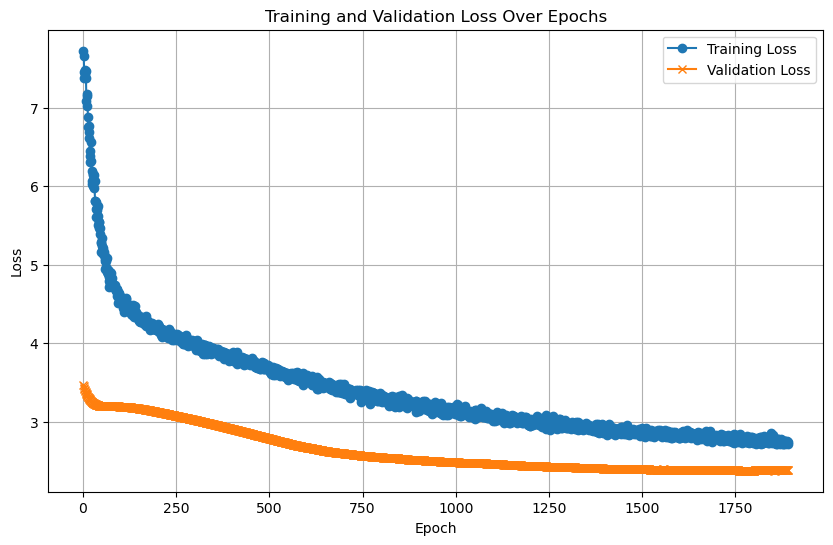

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/12], Loss: 5.9705

Test Loss: 5.3061


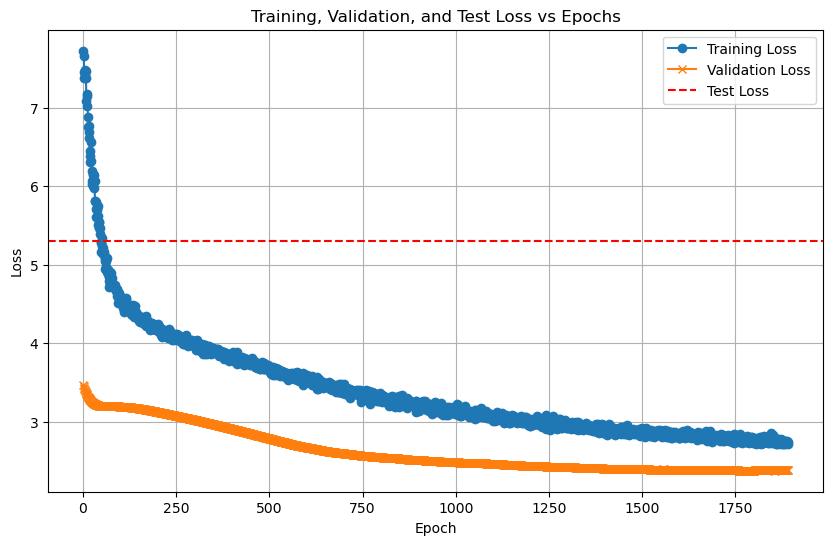

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...


LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 78.57%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5
           3       1.00      0.80      0.89         5
           4       0.83      1.00      0.91         5
           5       0.50      0.20      0.29         5
           6       0.83      1.00      0.91         5
           7       0.75      0.60      0.67         5
           8       0.57      0.80      0.67         5
           9       0.71      1.00      0.83         5
          10       0.67      0.80      0.73         5
          11       0.71      1.00      0.83         5
          12       0.80      0.80      0.80         5
          13       1.00      0.40      0.57         5

    accuracy                          

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6917  |  Val Loss: 2.6586
Validation loss improved from inf to 2.6586.
[Epoch 2/1000] Train Loss: 2.6587  |  Val Loss: 2.6389
Validation loss improved from 2.6586 to 2.6389.
[Epoch 3/1000] Train Loss: 2.6304  |  Val Loss: 2.6199
Validation loss improved from 2.6389 to 2.6199.
[Epoch 4/1000] Train Loss: 2.6033  |  Val Loss: 2.6027
Validation loss improved from 2.6199 to 2.6027.
[Epoch 5/1000] Train Loss: 2.5803  |  Val Loss: 2.5866
Validation loss improved from 2.6027 to 2.5866.
[Epoch 6/1000] Train Loss: 2.5548  |  Val Loss: 2.5717
Validation loss improved from 2.5866 to 2.5717.
[Epoch 7/1000] Train Loss: 2.5340  |  Val Loss: 2.5568
Validation loss improved from 2.5717 to 2.5568.
[Epoch 8/1000] Train Loss: 2.5148  |  Val Loss: 2.5427
Validation loss improved from 2.5568 to 2.5427.
[Epoch 9/1000] Train Loss: 2.4964  |  Val Loss: 2.5297
Validation loss improved from 2.5427 to 2.5297.
[Epoch 10/1000] Train Loss: 2.4785  |  Val Loss: 2.5176
Validation loss impr

[Epoch 21/1000] Train Loss: 2.3148  |  Val Loss: 2.3985
Validation loss improved from 2.4084 to 2.3985.
[Epoch 22/1000] Train Loss: 2.3016  |  Val Loss: 2.3883
Validation loss improved from 2.3985 to 2.3883.
[Epoch 23/1000] Train Loss: 2.2896  |  Val Loss: 2.3775
Validation loss improved from 2.3883 to 2.3775.
[Epoch 24/1000] Train Loss: 2.2765  |  Val Loss: 2.3670
Validation loss improved from 2.3775 to 2.3670.
[Epoch 25/1000] Train Loss: 2.2637  |  Val Loss: 2.3567
Validation loss improved from 2.3670 to 2.3567.
[Epoch 26/1000] Train Loss: 2.2512  |  Val Loss: 2.3464
Validation loss improved from 2.3567 to 2.3464.
[Epoch 27/1000] Train Loss: 2.2395  |  Val Loss: 2.3364
Validation loss improved from 2.3464 to 2.3364.
[Epoch 28/1000] Train Loss: 2.2276  |  Val Loss: 2.3269
Validation loss improved from 2.3364 to 2.3269.
[Epoch 29/1000] Train Loss: 2.2165  |  Val Loss: 2.3176
Validation loss improved from 2.3269 to 2.3176.


[Epoch 30/1000] Train Loss: 2.2058  |  Val Loss: 2.3085
Validation loss improved from 2.3176 to 2.3085.
[Epoch 31/1000] Train Loss: 2.1953  |  Val Loss: 2.2996
Validation loss improved from 2.3085 to 2.2996.
[Epoch 32/1000] Train Loss: 2.1851  |  Val Loss: 2.2909
Validation loss improved from 2.2996 to 2.2909.
[Epoch 33/1000] Train Loss: 2.1753  |  Val Loss: 2.2823
Validation loss improved from 2.2909 to 2.2823.
[Epoch 34/1000] Train Loss: 2.1652  |  Val Loss: 2.2738
Validation loss improved from 2.2823 to 2.2738.
[Epoch 35/1000] Train Loss: 2.1555  |  Val Loss: 2.2655
Validation loss improved from 2.2738 to 2.2655.
[Epoch 36/1000] Train Loss: 2.1454  |  Val Loss: 2.2573
Validation loss improved from 2.2655 to 2.2573.
[Epoch 37/1000] Train Loss: 2.1353  |  Val Loss: 2.2492
Validation loss improved from 2.2573 to 2.2492.
[Epoch 38/1000] Train Loss: 2.1257  |  Val Loss: 2.2410
Validation loss improved from 2.2492 to 2.2410.
[Epoch 39/1000] Train Loss: 2.1155  |  Val Loss: 2.2329
Validati

[Epoch 50/1000] Train Loss: 2.0020  |  Val Loss: 2.1382
Validation loss improved from 2.1470 to 2.1382.
[Epoch 51/1000] Train Loss: 1.9913  |  Val Loss: 2.1293
Validation loss improved from 2.1382 to 2.1293.
[Epoch 52/1000] Train Loss: 1.9808  |  Val Loss: 2.1206
Validation loss improved from 2.1293 to 2.1206.
[Epoch 53/1000] Train Loss: 1.9701  |  Val Loss: 2.1118
Validation loss improved from 2.1206 to 2.1118.
[Epoch 54/1000] Train Loss: 1.9588  |  Val Loss: 2.1029
Validation loss improved from 2.1118 to 2.1029.
[Epoch 55/1000] Train Loss: 1.9477  |  Val Loss: 2.0936
Validation loss improved from 2.1029 to 2.0936.
[Epoch 56/1000] Train Loss: 1.9371  |  Val Loss: 2.0843
Validation loss improved from 2.0936 to 2.0843.
[Epoch 57/1000] Train Loss: 1.9259  |  Val Loss: 2.0750
Validation loss improved from 2.0843 to 2.0750.
[Epoch 58/1000] Train Loss: 1.9154  |  Val Loss: 2.0658
Validation loss improved from 2.0750 to 2.0658.


[Epoch 59/1000] Train Loss: 1.9047  |  Val Loss: 2.0561
Validation loss improved from 2.0658 to 2.0561.
[Epoch 60/1000] Train Loss: 1.8940  |  Val Loss: 2.0462
Validation loss improved from 2.0561 to 2.0462.
[Epoch 61/1000] Train Loss: 1.8833  |  Val Loss: 2.0362
Validation loss improved from 2.0462 to 2.0362.
[Epoch 62/1000] Train Loss: 1.8722  |  Val Loss: 2.0264
Validation loss improved from 2.0362 to 2.0264.
[Epoch 63/1000] Train Loss: 1.8610  |  Val Loss: 2.0167
Validation loss improved from 2.0264 to 2.0167.
[Epoch 64/1000] Train Loss: 1.8500  |  Val Loss: 2.0066
Validation loss improved from 2.0167 to 2.0066.
[Epoch 65/1000] Train Loss: 1.8384  |  Val Loss: 1.9962
Validation loss improved from 2.0066 to 1.9962.
[Epoch 66/1000] Train Loss: 1.8271  |  Val Loss: 1.9857
Validation loss improved from 1.9962 to 1.9857.
[Epoch 67/1000] Train Loss: 1.8158  |  Val Loss: 1.9750
Validation loss improved from 1.9857 to 1.9750.
[Epoch 68/1000] Train Loss: 1.8043  |  Val Loss: 1.9647
Validati

[Epoch 82/1000] Train Loss: 1.6372  |  Val Loss: 1.8135
Validation loss improved from 1.8245 to 1.8135.
[Epoch 83/1000] Train Loss: 1.6250  |  Val Loss: 1.8023
Validation loss improved from 1.8135 to 1.8023.
[Epoch 84/1000] Train Loss: 1.6122  |  Val Loss: 1.7908
Validation loss improved from 1.8023 to 1.7908.
[Epoch 85/1000] Train Loss: 1.5998  |  Val Loss: 1.7790
Validation loss improved from 1.7908 to 1.7790.
[Epoch 86/1000] Train Loss: 1.5870  |  Val Loss: 1.7670
Validation loss improved from 1.7790 to 1.7670.
[Epoch 87/1000] Train Loss: 1.5742  |  Val Loss: 1.7548
Validation loss improved from 1.7670 to 1.7548.
[Epoch 88/1000] Train Loss: 1.5611  |  Val Loss: 1.7427
Validation loss improved from 1.7548 to 1.7427.
[Epoch 89/1000] Train Loss: 1.5485  |  Val Loss: 1.7305
Validation loss improved from 1.7427 to 1.7305.


[Epoch 90/1000] Train Loss: 1.5353  |  Val Loss: 1.7182
Validation loss improved from 1.7305 to 1.7182.
[Epoch 91/1000] Train Loss: 1.5225  |  Val Loss: 1.7062
Validation loss improved from 1.7182 to 1.7062.
[Epoch 92/1000] Train Loss: 1.5099  |  Val Loss: 1.6943
Validation loss improved from 1.7062 to 1.6943.
[Epoch 93/1000] Train Loss: 1.4970  |  Val Loss: 1.6826
Validation loss improved from 1.6943 to 1.6826.
[Epoch 94/1000] Train Loss: 1.4846  |  Val Loss: 1.6710
Validation loss improved from 1.6826 to 1.6710.
[Epoch 95/1000] Train Loss: 1.4715  |  Val Loss: 1.6598
Validation loss improved from 1.6710 to 1.6598.
[Epoch 96/1000] Train Loss: 1.4592  |  Val Loss: 1.6487
Validation loss improved from 1.6598 to 1.6487.
[Epoch 97/1000] Train Loss: 1.4467  |  Val Loss: 1.6375
Validation loss improved from 1.6487 to 1.6375.
[Epoch 98/1000] Train Loss: 1.4346  |  Val Loss: 1.6266
Validation loss improved from 1.6375 to 1.6266.
[Epoch 99/1000] Train Loss: 1.4224  |  Val Loss: 1.6162
Validati

[Epoch 112/1000] Train Loss: 1.2681  |  Val Loss: 1.4840
Validation loss improved from 1.4939 to 1.4840.
[Epoch 113/1000] Train Loss: 1.2563  |  Val Loss: 1.4744
Validation loss improved from 1.4840 to 1.4744.
[Epoch 114/1000] Train Loss: 1.2450  |  Val Loss: 1.4647
Validation loss improved from 1.4744 to 1.4647.
[Epoch 115/1000] Train Loss: 1.2335  |  Val Loss: 1.4551
Validation loss improved from 1.4647 to 1.4551.
[Epoch 116/1000] Train Loss: 1.2222  |  Val Loss: 1.4456
Validation loss improved from 1.4551 to 1.4456.
[Epoch 117/1000] Train Loss: 1.2111  |  Val Loss: 1.4367
Validation loss improved from 1.4456 to 1.4367.
[Epoch 118/1000] Train Loss: 1.1999  |  Val Loss: 1.4283
Validation loss improved from 1.4367 to 1.4283.


[Epoch 119/1000] Train Loss: 1.1889  |  Val Loss: 1.4200
Validation loss improved from 1.4283 to 1.4200.
[Epoch 120/1000] Train Loss: 1.1781  |  Val Loss: 1.4117
Validation loss improved from 1.4200 to 1.4117.
[Epoch 121/1000] Train Loss: 1.1671  |  Val Loss: 1.4032
Validation loss improved from 1.4117 to 1.4032.
[Epoch 122/1000] Train Loss: 1.1563  |  Val Loss: 1.3946
Validation loss improved from 1.4032 to 1.3946.
[Epoch 123/1000] Train Loss: 1.1455  |  Val Loss: 1.3860
Validation loss improved from 1.3946 to 1.3860.
[Epoch 124/1000] Train Loss: 1.1347  |  Val Loss: 1.3777
Validation loss improved from 1.3860 to 1.3777.
[Epoch 125/1000] Train Loss: 1.1241  |  Val Loss: 1.3696
Validation loss improved from 1.3777 to 1.3696.
[Epoch 126/1000] Train Loss: 1.1134  |  Val Loss: 1.3613
Validation loss improved from 1.3696 to 1.3613.
[Epoch 127/1000] Train Loss: 1.1031  |  Val Loss: 1.3530
Validation loss improved from 1.3613 to 1.3530.
[Epoch 128/1000] Train Loss: 1.0927  |  Val Loss: 1.344

[Epoch 139/1000] Train Loss: 0.9831  |  Val Loss: 1.2535
Validation loss improved from 1.2619 to 1.2535.
[Epoch 140/1000] Train Loss: 0.9736  |  Val Loss: 1.2453
Validation loss improved from 1.2535 to 1.2453.
[Epoch 141/1000] Train Loss: 0.9644  |  Val Loss: 1.2373
Validation loss improved from 1.2453 to 1.2373.
[Epoch 142/1000] Train Loss: 0.9554  |  Val Loss: 1.2289
Validation loss improved from 1.2373 to 1.2289.
[Epoch 143/1000] Train Loss: 0.9461  |  Val Loss: 1.2206
Validation loss improved from 1.2289 to 1.2206.
[Epoch 144/1000] Train Loss: 0.9366  |  Val Loss: 1.2124
Validation loss improved from 1.2206 to 1.2124.
[Epoch 145/1000] Train Loss: 0.9276  |  Val Loss: 1.2038
Validation loss improved from 1.2124 to 1.2038.
[Epoch 146/1000] Train Loss: 0.9183  |  Val Loss: 1.1958
Validation loss improved from 1.2038 to 1.1958.
[Epoch 147/1000] Train Loss: 0.9091  |  Val Loss: 1.1879
Validation loss improved from 1.1958 to 1.1879.


[Epoch 148/1000] Train Loss: 0.9002  |  Val Loss: 1.1802
Validation loss improved from 1.1879 to 1.1802.
[Epoch 149/1000] Train Loss: 0.8913  |  Val Loss: 1.1726
Validation loss improved from 1.1802 to 1.1726.
[Epoch 150/1000] Train Loss: 0.8827  |  Val Loss: 1.1650
Validation loss improved from 1.1726 to 1.1650.
[Epoch 151/1000] Train Loss: 0.8739  |  Val Loss: 1.1572
Validation loss improved from 1.1650 to 1.1572.
[Epoch 152/1000] Train Loss: 0.8655  |  Val Loss: 1.1495
Validation loss improved from 1.1572 to 1.1495.
[Epoch 153/1000] Train Loss: 0.8568  |  Val Loss: 1.1421
Validation loss improved from 1.1495 to 1.1421.
[Epoch 154/1000] Train Loss: 0.8483  |  Val Loss: 1.1345
Validation loss improved from 1.1421 to 1.1345.
[Epoch 155/1000] Train Loss: 0.8396  |  Val Loss: 1.1272
Validation loss improved from 1.1345 to 1.1272.
[Epoch 156/1000] Train Loss: 0.8312  |  Val Loss: 1.1202
Validation loss improved from 1.1272 to 1.1202.
[Epoch 157/1000] Train Loss: 0.8231  |  Val Loss: 1.113

[Epoch 168/1000] Train Loss: 0.7370  |  Val Loss: 1.0432
Validation loss improved from 1.0496 to 1.0432.
[Epoch 169/1000] Train Loss: 0.7295  |  Val Loss: 1.0368
Validation loss improved from 1.0432 to 1.0368.
[Epoch 170/1000] Train Loss: 0.7219  |  Val Loss: 1.0305
Validation loss improved from 1.0368 to 1.0305.
[Epoch 171/1000] Train Loss: 0.7144  |  Val Loss: 1.0243
Validation loss improved from 1.0305 to 1.0243.
[Epoch 172/1000] Train Loss: 0.7071  |  Val Loss: 1.0184
Validation loss improved from 1.0243 to 1.0184.
[Epoch 173/1000] Train Loss: 0.6994  |  Val Loss: 1.0125
Validation loss improved from 1.0184 to 1.0125.
[Epoch 174/1000] Train Loss: 0.6923  |  Val Loss: 1.0068
Validation loss improved from 1.0125 to 1.0068.
[Epoch 175/1000] Train Loss: 0.6853  |  Val Loss: 1.0013
Validation loss improved from 1.0068 to 1.0013.
[Epoch 176/1000] Train Loss: 0.6785  |  Val Loss: 0.9957
Validation loss improved from 1.0013 to 0.9957.
[Epoch 177/1000] Train Loss: 0.6714  |  Val Loss: 0.990

[Epoch 179/1000] Train Loss: 0.6579  |  Val Loss: 0.9797
Validation loss improved from 0.9849 to 0.9797.
[Epoch 180/1000] Train Loss: 0.6513  |  Val Loss: 0.9746
Validation loss improved from 0.9797 to 0.9746.
[Epoch 181/1000] Train Loss: 0.6448  |  Val Loss: 0.9690
Validation loss improved from 0.9746 to 0.9690.
[Epoch 182/1000] Train Loss: 0.6382  |  Val Loss: 0.9630
Validation loss improved from 0.9690 to 0.9630.
[Epoch 183/1000] Train Loss: 0.6320  |  Val Loss: 0.9573
Validation loss improved from 0.9630 to 0.9573.
[Epoch 184/1000] Train Loss: 0.6258  |  Val Loss: 0.9520
Validation loss improved from 0.9573 to 0.9520.
[Epoch 185/1000] Train Loss: 0.6195  |  Val Loss: 0.9472
Validation loss improved from 0.9520 to 0.9472.
[Epoch 186/1000] Train Loss: 0.6135  |  Val Loss: 0.9428
Validation loss improved from 0.9472 to 0.9428.
[Epoch 187/1000] Train Loss: 0.6072  |  Val Loss: 0.9385
Validation loss improved from 0.9428 to 0.9385.
[Epoch 188/1000] Train Loss: 0.6010  |  Val Loss: 0.934

[Epoch 196/1000] Train Loss: 0.5543  |  Val Loss: 0.9000
Validation loss improved from 0.9042 to 0.9000.
[Epoch 197/1000] Train Loss: 0.5490  |  Val Loss: 0.8956
Validation loss improved from 0.9000 to 0.8956.
[Epoch 198/1000] Train Loss: 0.5433  |  Val Loss: 0.8911
Validation loss improved from 0.8956 to 0.8911.
[Epoch 199/1000] Train Loss: 0.5381  |  Val Loss: 0.8870
Validation loss improved from 0.8911 to 0.8870.
[Epoch 200/1000] Train Loss: 0.5326  |  Val Loss: 0.8830
Validation loss improved from 0.8870 to 0.8830.
[Epoch 201/1000] Train Loss: 0.5273  |  Val Loss: 0.8787
Validation loss improved from 0.8830 to 0.8787.
[Epoch 202/1000] Train Loss: 0.5222  |  Val Loss: 0.8742
Validation loss improved from 0.8787 to 0.8742.
[Epoch 203/1000] Train Loss: 0.5171  |  Val Loss: 0.8700
Validation loss improved from 0.8742 to 0.8700.
[Epoch 204/1000] Train Loss: 0.5120  |  Val Loss: 0.8655
Validation loss improved from 0.8700 to 0.8655.
[Epoch 205/1000] Train Loss: 0.5071  |  Val Loss: 0.861

[Epoch 210/1000] Train Loss: 0.4819  |  Val Loss: 0.8435
Validation loss improved from 0.8473 to 0.8435.
[Epoch 211/1000] Train Loss: 0.4770  |  Val Loss: 0.8399
Validation loss improved from 0.8435 to 0.8399.
[Epoch 212/1000] Train Loss: 0.4722  |  Val Loss: 0.8361
Validation loss improved from 0.8399 to 0.8361.
[Epoch 213/1000] Train Loss: 0.4674  |  Val Loss: 0.8321
Validation loss improved from 0.8361 to 0.8321.
[Epoch 214/1000] Train Loss: 0.4627  |  Val Loss: 0.8279
Validation loss improved from 0.8321 to 0.8279.
[Epoch 215/1000] Train Loss: 0.4583  |  Val Loss: 0.8241
Validation loss improved from 0.8279 to 0.8241.
[Epoch 216/1000] Train Loss: 0.4535  |  Val Loss: 0.8206
Validation loss improved from 0.8241 to 0.8206.
[Epoch 217/1000] Train Loss: 0.4490  |  Val Loss: 0.8170
Validation loss improved from 0.8206 to 0.8170.
[Epoch 218/1000] Train Loss: 0.4447  |  Val Loss: 0.8134
Validation loss improved from 0.8170 to 0.8134.
[Epoch 219/1000] Train Loss: 0.4405  |  Val Loss: 0.810

[Epoch 226/1000] Train Loss: 0.4119  |  Val Loss: 0.7914
Validation loss improved from 0.7944 to 0.7914.
[Epoch 227/1000] Train Loss: 0.4080  |  Val Loss: 0.7884
Validation loss improved from 0.7914 to 0.7884.
[Epoch 228/1000] Train Loss: 0.4041  |  Val Loss: 0.7847
Validation loss improved from 0.7884 to 0.7847.
[Epoch 229/1000] Train Loss: 0.4003  |  Val Loss: 0.7811
Validation loss improved from 0.7847 to 0.7811.
[Epoch 230/1000] Train Loss: 0.3966  |  Val Loss: 0.7778
Validation loss improved from 0.7811 to 0.7778.
[Epoch 231/1000] Train Loss: 0.3925  |  Val Loss: 0.7748
Validation loss improved from 0.7778 to 0.7748.
[Epoch 232/1000] Train Loss: 0.3888  |  Val Loss: 0.7720
Validation loss improved from 0.7748 to 0.7720.
[Epoch 233/1000] Train Loss: 0.3850  |  Val Loss: 0.7698
Validation loss improved from 0.7720 to 0.7698.
[Epoch 234/1000] Train Loss: 0.3813  |  Val Loss: 0.7674
Validation loss improved from 0.7698 to 0.7674.
[Epoch 235/1000] Train Loss: 0.3776  |  Val Loss: 0.765

[Epoch 242/1000] Train Loss: 0.3521  |  Val Loss: 0.7478
Validation loss improved from 0.7512 to 0.7478.
[Epoch 243/1000] Train Loss: 0.3488  |  Val Loss: 0.7450
Validation loss improved from 0.7478 to 0.7450.
[Epoch 244/1000] Train Loss: 0.3455  |  Val Loss: 0.7425
Validation loss improved from 0.7450 to 0.7425.
[Epoch 245/1000] Train Loss: 0.3424  |  Val Loss: 0.7396
Validation loss improved from 0.7425 to 0.7396.
[Epoch 246/1000] Train Loss: 0.3394  |  Val Loss: 0.7367
Validation loss improved from 0.7396 to 0.7367.
[Epoch 247/1000] Train Loss: 0.3365  |  Val Loss: 0.7341
Validation loss improved from 0.7367 to 0.7341.
[Epoch 248/1000] Train Loss: 0.3334  |  Val Loss: 0.7318
Validation loss improved from 0.7341 to 0.7318.
[Epoch 249/1000] Train Loss: 0.3303  |  Val Loss: 0.7293
Validation loss improved from 0.7318 to 0.7293.
[Epoch 250/1000] Train Loss: 0.3272  |  Val Loss: 0.7270
Validation loss improved from 0.7293 to 0.7270.
[Epoch 251/1000] Train Loss: 0.3242  |  Val Loss: 0.724

[Epoch 255/1000] Train Loss: 0.3121  |  Val Loss: 0.7140
Validation loss improved from 0.7173 to 0.7140.
[Epoch 256/1000] Train Loss: 0.3094  |  Val Loss: 0.7114
Validation loss improved from 0.7140 to 0.7114.
[Epoch 257/1000] Train Loss: 0.3066  |  Val Loss: 0.7096
Validation loss improved from 0.7114 to 0.7096.
[Epoch 258/1000] Train Loss: 0.3039  |  Val Loss: 0.7082
Validation loss improved from 0.7096 to 0.7082.
[Epoch 259/1000] Train Loss: 0.3009  |  Val Loss: 0.7070
Validation loss improved from 0.7082 to 0.7070.
[Epoch 260/1000] Train Loss: 0.2984  |  Val Loss: 0.7061
Validation loss improved from 0.7070 to 0.7061.
[Epoch 261/1000] Train Loss: 0.2955  |  Val Loss: 0.7052
Validation loss improved from 0.7061 to 0.7052.
[Epoch 262/1000] Train Loss: 0.2927  |  Val Loss: 0.7042
Validation loss improved from 0.7052 to 0.7042.
[Epoch 263/1000] Train Loss: 0.2902  |  Val Loss: 0.7033
Validation loss improved from 0.7042 to 0.7033.
[Epoch 264/1000] Train Loss: 0.2874  |  Val Loss: 0.702

[Epoch 270/1000] Train Loss: 0.2727  |  Val Loss: 0.6972
Validation loss improved from 0.6982 to 0.6972.
[Epoch 271/1000] Train Loss: 0.2704  |  Val Loss: 0.6961
Validation loss improved from 0.6972 to 0.6961.
[Epoch 272/1000] Train Loss: 0.2681  |  Val Loss: 0.6943
Validation loss improved from 0.6961 to 0.6943.
[Epoch 273/1000] Train Loss: 0.2657  |  Val Loss: 0.6928
Validation loss improved from 0.6943 to 0.6928.
[Epoch 274/1000] Train Loss: 0.2634  |  Val Loss: 0.6907
Validation loss improved from 0.6928 to 0.6907.
[Epoch 275/1000] Train Loss: 0.2611  |  Val Loss: 0.6885
Validation loss improved from 0.6907 to 0.6885.
[Epoch 276/1000] Train Loss: 0.2587  |  Val Loss: 0.6862
Validation loss improved from 0.6885 to 0.6862.
[Epoch 277/1000] Train Loss: 0.2565  |  Val Loss: 0.6838
Validation loss improved from 0.6862 to 0.6838.
[Epoch 278/1000] Train Loss: 0.2544  |  Val Loss: 0.6807
Validation loss improved from 0.6838 to 0.6807.
[Epoch 279/1000] Train Loss: 0.2523  |  Val Loss: 0.677

[Epoch 282/1000] Train Loss: 0.2461  |  Val Loss: 0.6706
Validation loss improved from 0.6728 to 0.6706.
[Epoch 283/1000] Train Loss: 0.2443  |  Val Loss: 0.6690
Validation loss improved from 0.6706 to 0.6690.
[Epoch 284/1000] Train Loss: 0.2422  |  Val Loss: 0.6687
Validation loss improved from 0.6690 to 0.6687.
[Epoch 285/1000] Train Loss: 0.2400  |  Val Loss: 0.6687
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 286/1000] Train Loss: 0.2376  |  Val Loss: 0.6695
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 287/1000] Train Loss: 0.2358  |  Val Loss: 0.6709
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 288/1000] Train Loss: 0.2340  |  Val Loss: 0.6717
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 289/1000] Train Loss: 0.2320  |  Val Loss: 0.6720
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 290/1000] Train Loss: 0.2302  |  Val Loss: 0.6722
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 291/1000] Tr

[Epoch 301/1000] Train Loss: 0.2103  |  Val Loss: 0.6601
Validation loss improved from 0.6612 to 0.6601.
[Epoch 302/1000] Train Loss: 0.2087  |  Val Loss: 0.6590
Validation loss improved from 0.6601 to 0.6590.
[Epoch 303/1000] Train Loss: 0.2071  |  Val Loss: 0.6577
Validation loss improved from 0.6590 to 0.6577.
[Epoch 304/1000] Train Loss: 0.2055  |  Val Loss: 0.6567
Validation loss improved from 0.6577 to 0.6567.
[Epoch 305/1000] Train Loss: 0.2039  |  Val Loss: 0.6556
Validation loss improved from 0.6567 to 0.6556.
[Epoch 306/1000] Train Loss: 0.2023  |  Val Loss: 0.6546
Validation loss improved from 0.6556 to 0.6546.
[Epoch 307/1000] Train Loss: 0.2006  |  Val Loss: 0.6543
Validation loss improved from 0.6546 to 0.6543.
[Epoch 308/1000] Train Loss: 0.1990  |  Val Loss: 0.6542
Validation loss improved from 0.6543 to 0.6542.
[Epoch 309/1000] Train Loss: 0.1972  |  Val Loss: 0.6542
Validation loss improved from 0.6542 to 0.6542.
[Epoch 310/1000] Train Loss: 0.1956  |  Val Loss: 0.654

[Epoch 314/1000] Train Loss: 0.1896  |  Val Loss: 0.6534
Validation loss improved from 0.6538 to 0.6534.
[Epoch 315/1000] Train Loss: 0.1882  |  Val Loss: 0.6530
Validation loss improved from 0.6534 to 0.6530.
[Epoch 316/1000] Train Loss: 0.1868  |  Val Loss: 0.6530
Validation loss improved from 0.6530 to 0.6530.
[Epoch 317/1000] Train Loss: 0.1855  |  Val Loss: 0.6528
Validation loss improved from 0.6530 to 0.6528.
[Epoch 318/1000] Train Loss: 0.1839  |  Val Loss: 0.6516
Validation loss improved from 0.6528 to 0.6516.
[Epoch 319/1000] Train Loss: 0.1826  |  Val Loss: 0.6509
Validation loss improved from 0.6516 to 0.6509.
[Epoch 320/1000] Train Loss: 0.1811  |  Val Loss: 0.6504
Validation loss improved from 0.6509 to 0.6504.
[Epoch 321/1000] Train Loss: 0.1798  |  Val Loss: 0.6495
Validation loss improved from 0.6504 to 0.6495.
[Epoch 322/1000] Train Loss: 0.1784  |  Val Loss: 0.6492
Validation loss improved from 0.6495 to 0.6492.
[Epoch 323/1000] Train Loss: 0.1771  |  Val Loss: 0.648

[Epoch 330/1000] Train Loss: 0.1684  |  Val Loss: 0.6384
Validation loss improved from 0.6401 to 0.6384.
[Epoch 331/1000] Train Loss: 0.1672  |  Val Loss: 0.6367
Validation loss improved from 0.6384 to 0.6367.
[Epoch 332/1000] Train Loss: 0.1660  |  Val Loss: 0.6357
Validation loss improved from 0.6367 to 0.6357.
[Epoch 333/1000] Train Loss: 0.1649  |  Val Loss: 0.6347
Validation loss improved from 0.6357 to 0.6347.
[Epoch 334/1000] Train Loss: 0.1637  |  Val Loss: 0.6342
Validation loss improved from 0.6347 to 0.6342.
[Epoch 335/1000] Train Loss: 0.1626  |  Val Loss: 0.6341
Validation loss improved from 0.6342 to 0.6341.
[Epoch 336/1000] Train Loss: 0.1615  |  Val Loss: 0.6338
Validation loss improved from 0.6341 to 0.6338.
[Epoch 337/1000] Train Loss: 0.1603  |  Val Loss: 0.6336
Validation loss improved from 0.6338 to 0.6336.
[Epoch 338/1000] Train Loss: 0.1591  |  Val Loss: 0.6335
Validation loss improved from 0.6336 to 0.6335.
[Epoch 339/1000] Train Loss: 0.1579  |  Val Loss: 0.632

[Epoch 343/1000] Train Loss: 0.1532  |  Val Loss: 0.6308
Validation loss improved from 0.6309 to 0.6308.
[Epoch 344/1000] Train Loss: 0.1521  |  Val Loss: 0.6304
Validation loss improved from 0.6308 to 0.6304.
[Epoch 345/1000] Train Loss: 0.1510  |  Val Loss: 0.6302
Validation loss improved from 0.6304 to 0.6302.
[Epoch 346/1000] Train Loss: 0.1499  |  Val Loss: 0.6301
Validation loss improved from 0.6302 to 0.6301.
[Epoch 347/1000] Train Loss: 0.1488  |  Val Loss: 0.6299
Validation loss improved from 0.6301 to 0.6299.
[Epoch 348/1000] Train Loss: 0.1478  |  Val Loss: 0.6300
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 349/1000] Train Loss: 0.1467  |  Val Loss: 0.6303
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 350/1000] Train Loss: 0.1457  |  Val Loss: 0.6305
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 351/1000] Train Loss: 0.1447  |  Val Loss: 0.6307
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 352/1000] Train Loss: 0.

[Epoch 359/1000] Train Loss: 0.1371  |  Val Loss: 0.6265
Validation loss improved from 0.6270 to 0.6265.
[Epoch 360/1000] Train Loss: 0.1362  |  Val Loss: 0.6258
Validation loss improved from 0.6265 to 0.6258.
[Epoch 361/1000] Train Loss: 0.1353  |  Val Loss: 0.6245
Validation loss improved from 0.6258 to 0.6245.
[Epoch 362/1000] Train Loss: 0.1343  |  Val Loss: 0.6232
Validation loss improved from 0.6245 to 0.6232.
[Epoch 363/1000] Train Loss: 0.1335  |  Val Loss: 0.6223
Validation loss improved from 0.6232 to 0.6223.
[Epoch 364/1000] Train Loss: 0.1327  |  Val Loss: 0.6220
Validation loss improved from 0.6223 to 0.6220.
[Epoch 365/1000] Train Loss: 0.1317  |  Val Loss: 0.6214
Validation loss improved from 0.6220 to 0.6214.
[Epoch 366/1000] Train Loss: 0.1308  |  Val Loss: 0.6207
Validation loss improved from 0.6214 to 0.6207.
[Epoch 367/1000] Train Loss: 0.1299  |  Val Loss: 0.6205
Validation loss improved from 0.6207 to 0.6205.
[Epoch 368/1000] Train Loss: 0.1291  |  Val Loss: 0.619

[Epoch 373/1000] Train Loss: 0.1251  |  Val Loss: 0.6164
Validation loss improved from 0.6169 to 0.6164.
[Epoch 374/1000] Train Loss: 0.1245  |  Val Loss: 0.6159
Validation loss improved from 0.6164 to 0.6159.
[Epoch 375/1000] Train Loss: 0.1237  |  Val Loss: 0.6162
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 376/1000] Train Loss: 0.1229  |  Val Loss: 0.6165
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 377/1000] Train Loss: 0.1219  |  Val Loss: 0.6171
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 378/1000] Train Loss: 0.1210  |  Val Loss: 0.6180
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 379/1000] Train Loss: 0.1201  |  Val Loss: 0.6189
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 380/1000] Train Loss: 0.1194  |  Val Loss: 0.6197
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 381/1000] Train Loss: 0.1187  |  Val Loss: 0.6204
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 382/10

[Epoch 389/1000] Train Loss: 0.1135  |  Val Loss: 0.6174
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 390/1000] Train Loss: 0.1127  |  Val Loss: 0.6172
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 391/1000] Train Loss: 0.1120  |  Val Loss: 0.6170
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 392/1000] Train Loss: 0.1112  |  Val Loss: 0.6170
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 393/1000] Train Loss: 0.1104  |  Val Loss: 0.6176
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 394/1000] Train Loss: 0.1097  |  Val Loss: 0.6175
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 395/1000] Train Loss: 0.1091  |  Val Loss: 0.6174
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 396/1000] Train Loss: 0.1084  |  Val Loss: 0.6171
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 397/1000] Train Loss: 0.1078  |  Val Loss: 0.6168
!! Validation loss did NOT improve !! Patience:

[Epoch 405/1000] Train Loss: 0.1028  |  Val Loss: 0.6174
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 406/1000] Train Loss: 0.1021  |  Val Loss: 0.6181
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 407/1000] Train Loss: 0.1015  |  Val Loss: 0.6190
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 408/1000] Train Loss: 0.1008  |  Val Loss: 0.6196
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 409/1000] Train Loss: 0.1003  |  Val Loss: 0.6204
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 410/1000] Train Loss: 0.0995  |  Val Loss: 0.6207
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 411/1000] Train Loss: 0.0992  |  Val Loss: 0.6204
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 412/1000] Train Loss: 0.0984  |  Val Loss: 0.6194
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 413/1000] Train Loss: 0.0978  |  Val Loss: 0.6181
!! Validation loss did NOT improve !! Patience:

[Epoch 420/1000] Train Loss: 0.0938  |  Val Loss: 0.6178
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 421/1000] Train Loss: 0.0932  |  Val Loss: 0.6184
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 422/1000] Train Loss: 0.0925  |  Val Loss: 0.6187
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 423/1000] Train Loss: 0.0920  |  Val Loss: 0.6190
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 424/1000] Train Loss: 0.0915  |  Val Loss: 0.6195
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 425/1000] Train Loss: 0.0910  |  Val Loss: 0.6209
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 426/1000] Train Loss: 0.0904  |  Val Loss: 0.6219
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 427/1000] Train Loss: 0.0898  |  Val Loss: 0.6222
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 428/1000] Train Loss: 0.0892  |  Val Loss: 0.6222
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 435/1000] Train Loss: 0.0858  |  Val Loss: 0.6211
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 436/1000] Train Loss: 0.0853  |  Val Loss: 0.6215
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 437/1000] Train Loss: 0.0848  |  Val Loss: 0.6221
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 438/1000] Train Loss: 0.0843  |  Val Loss: 0.6229
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 439/1000] Train Loss: 0.0839  |  Val Loss: 0.6243
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 440/1000] Train Loss: 0.0835  |  Val Loss: 0.6254
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 441/1000] Train Loss: 0.0831  |  Val Loss: 0.6260
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 442/1000] Train Loss: 0.0825  |  Val Loss: 0.6262
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 443/1000] Train Loss: 0.0821  |  Val Loss: 0.6267
!! Validation loss did NOT improve !! Patience:

[Epoch 450/1000] Train Loss: 0.0793  |  Val Loss: 0.6259
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 451/1000] Train Loss: 0.0789  |  Val Loss: 0.6260
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 452/1000] Train Loss: 0.0785  |  Val Loss: 0.6263
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 453/1000] Train Loss: 0.0781  |  Val Loss: 0.6262
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 454/1000] Train Loss: 0.0777  |  Val Loss: 0.6258
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 455/1000] Train Loss: 0.0774  |  Val Loss: 0.6260
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 456/1000] Train Loss: 0.0770  |  Val Loss: 0.6266
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 457/1000] Train Loss: 0.0766  |  Val Loss: 0.6273
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 458/1000] Train Loss: 0.0763  |  Val Loss: 0.6278
!! Validation loss did NOT improve !! Patience:

[Epoch 466/1000] Train Loss: 0.0733  |  Val Loss: 0.6324
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 467/1000] Train Loss: 0.0730  |  Val Loss: 0.6330
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 468/1000] Train Loss: 0.0727  |  Val Loss: 0.6333
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 469/1000] Train Loss: 0.0723  |  Val Loss: 0.6335
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 470/1000] Train Loss: 0.0717  |  Val Loss: 0.6331
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 471/1000] Train Loss: 0.0712  |  Val Loss: 0.6328
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 472/1000] Train Loss: 0.0710  |  Val Loss: 0.6321
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 473/1000] Train Loss: 0.0707  |  Val Loss: 0.6315
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 474/1000] Train Loss: 0.0703  |  Val Loss: 0.6314
!! Validation loss did NOT improve !! Patience:

[Epoch 478/1000] Train Loss: 0.0688  |  Val Loss: 0.6294
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 479/1000] Train Loss: 0.0686  |  Val Loss: 0.6290
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 480/1000] Train Loss: 0.0684  |  Val Loss: 0.6288
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 481/1000] Train Loss: 0.0681  |  Val Loss: 0.6290
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 482/1000] Train Loss: 0.0677  |  Val Loss: 0.6291
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 483/1000] Train Loss: 0.0674  |  Val Loss: 0.6293
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 484/1000] Train Loss: 0.0669  |  Val Loss: 0.6295
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 485/1000] Train Loss: 0.0666  |  Val Loss: 0.6294
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 486/1000] Train Loss: 0.0663  |  Val Loss: 0.6290
!! Validation loss did NOT improve !! Patience:

[Epoch 495/1000] Train Loss: 0.0636  |  Val Loss: 0.6320
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 496/1000] Train Loss: 0.0633  |  Val Loss: 0.6328
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 497/1000] Train Loss: 0.0630  |  Val Loss: 0.6332
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 498/1000] Train Loss: 0.0627  |  Val Loss: 0.6337
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 499/1000] Train Loss: 0.0624  |  Val Loss: 0.6337
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 500/1000] Train Loss: 0.0623  |  Val Loss: 0.6337
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 501/1000] Train Loss: 0.0619  |  Val Loss: 0.6344
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 502/1000] Train Loss: 0.0616  |  Val Loss: 0.6353
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 503/1000] Train Loss: 0.0614  |  Val Loss: 0.6362
!! Validation loss did NOT improve !! Patience:

[Epoch 508/1000] Train Loss: 0.0602  |  Val Loss: 0.6409
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 509/1000] Train Loss: 0.0599  |  Val Loss: 0.6411
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 510/1000] Train Loss: 0.0595  |  Val Loss: 0.6413
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 511/1000] Train Loss: 0.0593  |  Val Loss: 0.6414
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 512/1000] Train Loss: 0.0590  |  Val Loss: 0.6416
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 513/1000] Train Loss: 0.0588  |  Val Loss: 0.6408
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 514/1000] Train Loss: 0.0585  |  Val Loss: 0.6399
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 515/1000] Train Loss: 0.0583  |  Val Loss: 0.6392
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 516/1000] Train Loss: 0.0581  |  Val Loss: 0.6394
!! Validation loss did NOT improve !! Patience:

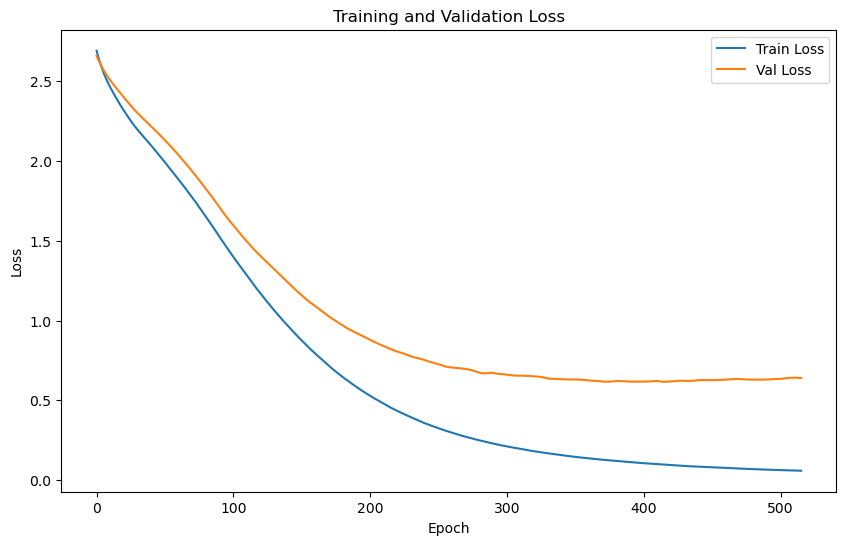

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.7446 | Test Accuracy: 82.29%


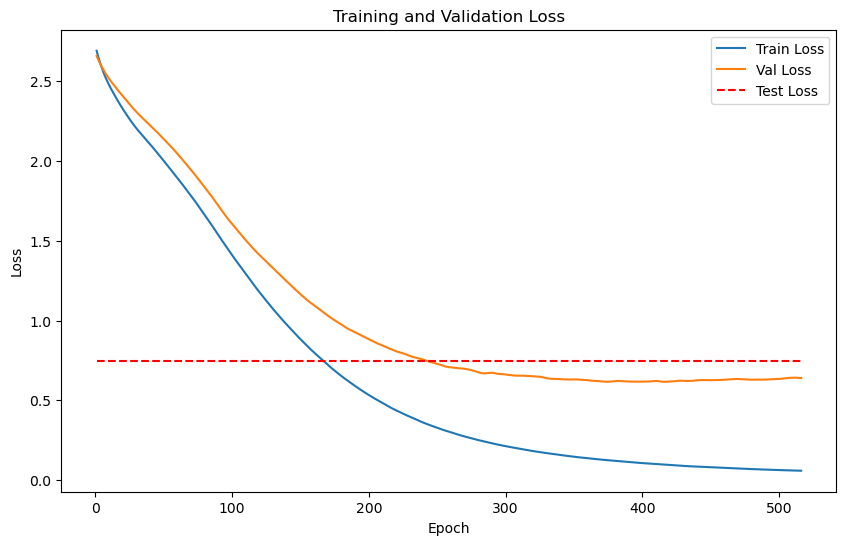

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)


Train embeddings shape: (140, 64), 
Train labels shape: (140,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3038, 64), 
Test labels shape: (3038,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10}
Training batch size: 140


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.2999
Epoch [1/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.3786

Validation loss improved from inf to 0.3786. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [2/2000] - Validation


    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.3007
Epoch [2/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.3788

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [3/2000] - Validation


    Batch [1/2], Val Loss: 0.4567
    Batch [2/2], Val Loss: 0.3005
Epoch [3/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.3786

Validation loss improved from 0.3786 to 0.3786. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [4/2000] - Validation


    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.3003
Epoch [4/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.3785

Validation loss improved from 0.3786 to 0.3785. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [5/2000] - Validation


    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.2990
Epoch [5/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.3777

Validation loss improved from 0.3785 to 0.3777. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [6/2000] - Validation


    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.2984
Epoch [6/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.3773

Validation loss improved from 0.3777 to 0.3773. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [7/2000] - Validation


    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.2994
Epoch [7/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.3778

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [8/2000] - Validation


    Batch [1/2], Val Loss: 0.4559
    Batch [2/2], Val Loss: 0.3018
Epoch [8/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.3788

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4560
    Batch [2/2], Val Loss: 0.3070
Epoch [9/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.3815

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4560
    Batch [2/2], Val Loss: 0.3113
Epoch [10/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.3837

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4559
    Batch [2/2], Val Loss: 0.3130
Epoch [11/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.3844

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4553
    Batch [2/2], Val Loss: 0.3116
Epoch [12/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.3835

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4554
    Batch [2/2], Val Loss: 0.3109
Epoch [13/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.3831

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4559
    Batch [2/2], Val Loss: 0.3105
Epoch [14/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.3832

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4555
    Batch [2/2], Val Loss: 0.3111
Epoch [15/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.3833

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4549
    Batch [2/2], Val Loss: 0.3117
Epoch [16/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.3833

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4530
    Batch [2/2], Val Loss: 0.3127
Epoch [17/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.3829

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4528
    Batch [2/2], Val Loss: 0.3153
Epoch [18/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.3840

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4536
    Batch [2/2], Val Loss: 0.3186
Epoch [19/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.3861

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.3185
Epoch [20/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.3863

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4545
    Batch [2/2], Val Loss: 0.3184
Epoch [21/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.3865

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4703
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4547
    Batch [2/2], Val Loss: 0.3162
Epoch [22/2000], Avg Train Loss: 0.4703, Avg Val Loss: 0.3855

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4547
    Batch [2/2], Val Loss: 0.3127
Epoch [23/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.3837

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.3113
Epoch [24/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.3829

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.3100
Epoch [25/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.3821

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.3054
Epoch [26/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.3793

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4744
LOG: Epoch [27/2000] - Validation


    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.3000
Epoch [27/2000], Avg Train Loss: 0.4744, Avg Val Loss: 0.3759

Validation loss improved from 0.3773 to 0.3759. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [28/2000] - Validation


    Batch [1/2], Val Loss: 0.4512
    Batch [2/2], Val Loss: 0.2951
Epoch [28/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.3731

Validation loss improved from 0.3759 to 0.3731. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.4507
    Batch [2/2], Val Loss: 0.2906
Epoch [29/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.3707

Validation loss improved from 0.3731 to 0.3707. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [30/2000] - Validation


    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.2886
Epoch [30/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.3694

Validation loss improved from 0.3707 to 0.3694. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [31/2000] - Validation


    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2869
Epoch [31/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.3685

Validation loss improved from 0.3694 to 0.3685. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [32/2000] - Validation


    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.2861
Epoch [32/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.3679

Validation loss improved from 0.3685 to 0.3679. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [33/2000] - Validation


    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2850
Epoch [33/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.3670

Validation loss improved from 0.3679 to 0.3670. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [34/2000] - Validation


    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.2833
Epoch [34/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.3659

Validation loss improved from 0.3670 to 0.3659. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [35/2000] - Validation


    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.2829
Epoch [35/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.3656

Validation loss improved from 0.3659 to 0.3656. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.2827
Epoch [36/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.3654

Validation loss improved from 0.3656 to 0.3654. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.2829
Epoch [37/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.3655

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4616
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.2832
Epoch [38/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.3655

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4477
    Batch [2/2], Val Loss: 0.2837
Epoch [39/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.3657

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4475
    Batch [2/2], Val Loss: 0.2845
Epoch [40/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.3660

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4471
    Batch [2/2], Val Loss: 0.2854
Epoch [41/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.3663

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4465
    Batch [2/2], Val Loss: 0.2866
Epoch [42/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.3666

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4459
    Batch [2/2], Val Loss: 0.2878
Epoch [43/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.3668

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4453
    Batch [2/2], Val Loss: 0.2893
Epoch [44/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.3673

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4445
    Batch [2/2], Val Loss: 0.2908
Epoch [45/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3677

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [46/2000] - Validation


    Batch [1/2], Val Loss: 0.4437
    Batch [2/2], Val Loss: 0.2924
Epoch [46/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.3680

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [47/2000] - Validation


    Batch [1/2], Val Loss: 0.4429
    Batch [2/2], Val Loss: 0.2942
Epoch [47/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.3686

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [48/2000] - Validation


    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.2960
Epoch [48/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.3690

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [49/2000] - Validation


    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.2974
Epoch [49/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.3693

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [50/2000] - Validation


    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.2987
Epoch [50/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.3697

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [51/2000] - Validation


    Batch [1/2], Val Loss: 0.4402
    Batch [2/2], Val Loss: 0.3002
Epoch [51/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.3702

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4399
    Batch [2/2], Val Loss: 0.3010
Epoch [52/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.3705

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4397
    Batch [2/2], Val Loss: 0.3018
Epoch [53/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.3707

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4395
    Batch [2/2], Val Loss: 0.3023
Epoch [54/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.3709

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4494
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4393
    Batch [2/2], Val Loss: 0.3027
Epoch [55/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.3710

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4391
    Batch [2/2], Val Loss: 0.3028
Epoch [56/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.3709

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4388
    Batch [2/2], Val Loss: 0.3027
Epoch [57/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.3708

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4383
    Batch [2/2], Val Loss: 0.3031
Epoch [58/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.3707

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4377
    Batch [2/2], Val Loss: 0.3029
Epoch [59/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.3703

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4371
    Batch [2/2], Val Loss: 0.3031
Epoch [60/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.3701

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4366
    Batch [2/2], Val Loss: 0.3033
Epoch [61/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.3699

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4360
    Batch [2/2], Val Loss: 0.3038
Epoch [62/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.3699

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4351
    Batch [2/2], Val Loss: 0.3036
Epoch [63/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.3694

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [64/2000] - Validation


    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.3033
Epoch [64/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.3688

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [65/2000] - Validation


    Batch [1/2], Val Loss: 0.4333
    Batch [2/2], Val Loss: 0.3030
Epoch [65/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.3681

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4323
    Batch [2/2], Val Loss: 0.3032
Epoch [66/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.3677

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.3034
Epoch [67/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3673

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4301
    Batch [2/2], Val Loss: 0.3034
Epoch [68/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.3667

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4291
    Batch [2/2], Val Loss: 0.3032
Epoch [69/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.3662

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4283
    Batch [2/2], Val Loss: 0.3032
Epoch [70/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.3658

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4275
    Batch [2/2], Val Loss: 0.3032
Epoch [71/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.3654

Validation loss improved from 0.3654 to 0.3654. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4268
    Batch [2/2], Val Loss: 0.3034
Epoch [72/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3651

Validation loss improved from 0.3654 to 0.3651. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4262
    Batch [2/2], Val Loss: 0.3035
Epoch [73/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.3648

Validation loss improved from 0.3651 to 0.3648. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.3037
Epoch [74/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.3646

Validation loss improved from 0.3648 to 0.3646. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.3039
Epoch [75/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3645

Validation loss improved from 0.3646 to 0.3645. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4248
    Batch [2/2], Val Loss: 0.3040
Epoch [76/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.3644

Validation loss improved from 0.3645 to 0.3644. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [77/2000] - Validation


    Batch [1/2], Val Loss: 0.4245
    Batch [2/2], Val Loss: 0.3042
Epoch [77/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.3643

Validation loss improved from 0.3644 to 0.3643. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [78/2000] - Validation


    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.3043
Epoch [78/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.3642

Validation loss improved from 0.3643 to 0.3642. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [79/2000] - Validation


    Batch [1/2], Val Loss: 0.4240
    Batch [2/2], Val Loss: 0.3044
Epoch [79/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.3642

Validation loss improved from 0.3642 to 0.3642. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [80/2000] - Validation


    Batch [1/2], Val Loss: 0.4237
    Batch [2/2], Val Loss: 0.3049
Epoch [80/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.3643

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [81/2000] - Validation


    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.3054
Epoch [81/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3644

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.3058
Epoch [82/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.3062
Epoch [83/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4226
    Batch [2/2], Val Loss: 0.3065
Epoch [84/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.3068
Epoch [85/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4221
    Batch [2/2], Val Loss: 0.3070
Epoch [86/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4219
    Batch [2/2], Val Loss: 0.3072
Epoch [87/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.3074
Epoch [88/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4215
    Batch [2/2], Val Loss: 0.3074
Epoch [89/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3644

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4214
    Batch [2/2], Val Loss: 0.3076
Epoch [90/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4214
    Batch [2/2], Val Loss: 0.3078
Epoch [91/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4213
    Batch [2/2], Val Loss: 0.3078
Epoch [92/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4212
    Batch [2/2], Val Loss: 0.3079
Epoch [93/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4211
    Batch [2/2], Val Loss: 0.3080
Epoch [94/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4210
    Batch [2/2], Val Loss: 0.3080
Epoch [95/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4209
    Batch [2/2], Val Loss: 0.3080
Epoch [96/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.3644

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.3080
Epoch [97/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.3644

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.3080
Epoch [98/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.3644

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4206
    Batch [2/2], Val Loss: 0.3080
Epoch [99/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.3643

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4205
    Batch [2/2], Val Loss: 0.3080
Epoch [100/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.3643

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4204
    Batch [2/2], Val Loss: 0.3080
Epoch [101/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3642

Validation loss improved from 0.3642 to 0.3642. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4204
    Batch [2/2], Val Loss: 0.3080
Epoch [102/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.3642

Validation loss improved from 0.3642 to 0.3642. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4203
    Batch [2/2], Val Loss: 0.3081
Epoch [103/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.3642

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4202
    Batch [2/2], Val Loss: 0.3081
Epoch [104/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.3642

Validation loss improved from 0.3642 to 0.3642. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4201
    Batch [2/2], Val Loss: 0.3083
Epoch [105/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3642

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.3084
Epoch [106/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3642

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3085
Epoch [107/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.3642

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3087
Epoch [108/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3643

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3088
Epoch [109/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.3643

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [110/2000] - Validation


    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3090
Epoch [110/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.3644

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [111/2000] - Validation


    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.3090
Epoch [111/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [112/2000] - Validation


    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.3090
Epoch [112/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.3090
Epoch [113/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.3090
Epoch [114/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.3090
Epoch [115/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.3091
Epoch [116/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3091
Epoch [117/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [118/2000] - Validation


    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3092
Epoch [118/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [119/2000] - Validation


    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3092
Epoch [119/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.4328
LOG: Epoch [120/2000] - Validation


    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3094
Epoch [120/2000], Avg Train Loss: 0.4328, Avg Val Loss: 0.3647

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3095
Epoch [121/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3647

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.3096
Epoch [122/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.3647

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [123/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3095
Epoch [123/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [124/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3096
Epoch [124/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [125/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3096
Epoch [125/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [126/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3096
Epoch [126/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.3096
Epoch [127/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.3647

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3096
Epoch [128/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.3095
Epoch [129/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.3647

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.3094
Epoch [130/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.3647

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.3095
Epoch [131/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.3647

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.3095
Epoch [132/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.3647

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.3096
Epoch [133/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.3096
Epoch [134/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [135/2000] - Validation


    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.3097
Epoch [135/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [136/2000] - Validation


    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3097
Epoch [136/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [137/2000] - Validation


    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3097
Epoch [137/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [138/2000] - Validation


    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3098
Epoch [138/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [139/2000] - Validation


    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3098
Epoch [139/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [140/2000] - Validation


    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3098
Epoch [140/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [141/2000] - Validation


    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3098
Epoch [141/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [142/2000] - Validation


    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3098
Epoch [142/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3098
Epoch [143/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3098
Epoch [144/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.3098
Epoch [145/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.3098
Epoch [146/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.3098
Epoch [147/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.3098
Epoch [148/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.3099
Epoch [149/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.3099
Epoch [150/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.3099
Epoch [151/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [152/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [153/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [154/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [155/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [156/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [157/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4343
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [158/2000], Avg Train Loss: 0.4343, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [159/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [160/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [161/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [161/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [162/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [162/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [163/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [163/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [164/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [164/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [165/2000] - Validation


    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [165/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [166/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [167/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [168/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.3099
Epoch [169/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [170/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [171/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [172/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [173/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [174/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [175/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [176/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [177/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [178/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [179/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [180/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [181/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [182/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [183/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [184/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [185/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [186/2000] - Validation


    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [186/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [187/2000] - Validation


    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [187/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [188/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [189/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [190/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [191/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [192/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [193/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [194/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [195/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [196/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [197/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [198/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [199/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [200/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [201/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [202/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [203/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.3099
Epoch [204/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.3648

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 204!!
No improvement for 100 epochs


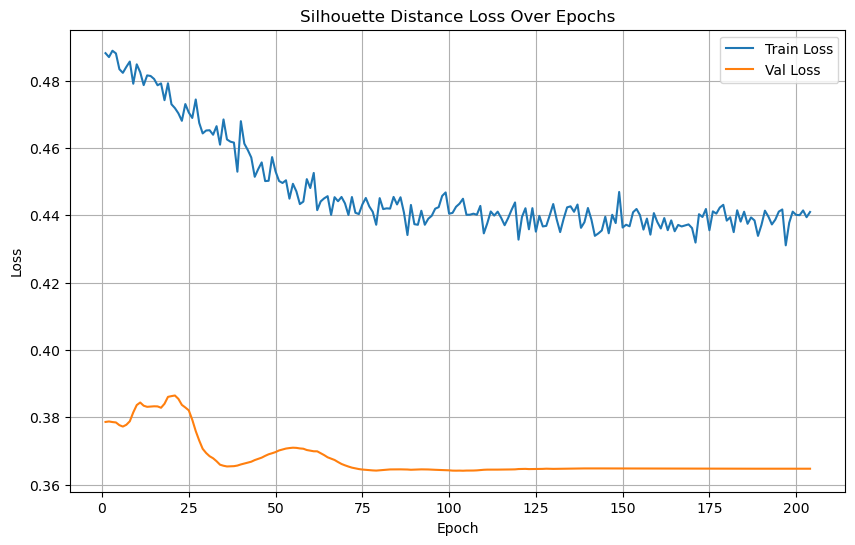

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/48], Loss: 0.3195


Test Batch [20/48], Loss: 0.2974
Test Batch [30/48], Loss: 0.3520
Test Batch [40/48], Loss: 0.5000

Test Loss: 0.3148


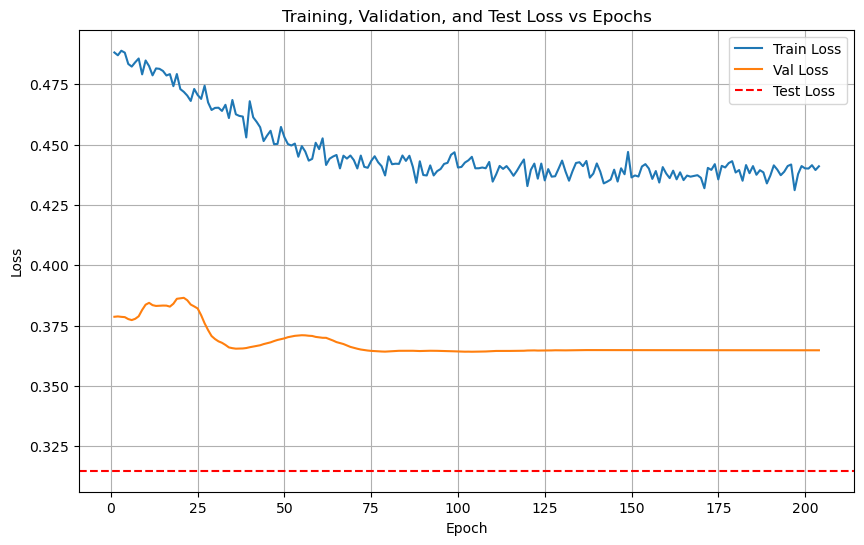

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/48 for test dataset.
  Processed batch 20/48 for test dataset.


  Processed batch 30/48 for test dataset.
  Processed batch 40/48 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 90.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       1.00      0.80      0.89         5
           4       0.71      1.00      0.83         5
           5       0.80      0.80      0.80         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00      0.80      0.89         5
           9       0.83      1.00      0.91         5
          10       0.83      1.00      0.91         5
          11       0.83      1.00      0.91         5
          12       1.00      0.80      0.89         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6848  |  Val Loss: 2.6549
Validation loss improved from inf to 2.6549.
[Epoch 2/1000] Train Loss: 2.6731  |  Val Loss: 2.6461
Validation loss improved from 2.6549 to 2.6461.
[Epoch 3/1000] Train Loss: 2.6616  |  Val Loss: 2.6376
Validation loss improved from 2.6461 to 2.6376.
[Epoch 4/1000] Train Loss: 2.6511  |  Val Loss: 2.6293
Validation loss improved from 2.6376 to 2.6293.
[Epoch 5/1000] Train Loss: 2.6394  |  Val Loss: 2.6213
Validation loss improved from 2.6293 to 2.6213.
[Epoch 6/1000] Train Loss: 2.6298  |  Val Loss: 2.6130
Validation loss improved from 2.6213 to 2.6130.
[Epoch 7/1000] Train Loss: 2.6196  |  Val Loss: 2.6049
Validation loss improved from 2.6130 to 2.6049.
[Epoch 8/1000] Train Loss: 2.6098  |  Val Loss: 2.5972
Validation loss improved from 2.6049 to 2.5972.
[Epoch 9/1000] Train Loss: 2.6004  |  Val Loss: 2.5896
Validation loss improved from 2.5972 to 2.5896.
[Epoch 10/1000] Train Loss: 2.5916  |  Val Loss: 2.5823
Validation loss impr

[Epoch 19/1000] Train Loss: 2.5086  |  Val Loss: 2.5171
Validation loss improved from 2.5242 to 2.5171.
[Epoch 20/1000] Train Loss: 2.5000  |  Val Loss: 2.5104
Validation loss improved from 2.5171 to 2.5104.
[Epoch 21/1000] Train Loss: 2.4916  |  Val Loss: 2.5037
Validation loss improved from 2.5104 to 2.5037.
[Epoch 22/1000] Train Loss: 2.4831  |  Val Loss: 2.4971
Validation loss improved from 2.5037 to 2.4971.
[Epoch 23/1000] Train Loss: 2.4752  |  Val Loss: 2.4905
Validation loss improved from 2.4971 to 2.4905.
[Epoch 24/1000] Train Loss: 2.4666  |  Val Loss: 2.4838
Validation loss improved from 2.4905 to 2.4838.
[Epoch 25/1000] Train Loss: 2.4583  |  Val Loss: 2.4770
Validation loss improved from 2.4838 to 2.4770.
[Epoch 26/1000] Train Loss: 2.4498  |  Val Loss: 2.4701
Validation loss improved from 2.4770 to 2.4701.


[Epoch 27/1000] Train Loss: 2.4415  |  Val Loss: 2.4627
Validation loss improved from 2.4701 to 2.4627.
[Epoch 28/1000] Train Loss: 2.4326  |  Val Loss: 2.4552
Validation loss improved from 2.4627 to 2.4552.
[Epoch 29/1000] Train Loss: 2.4236  |  Val Loss: 2.4479
Validation loss improved from 2.4552 to 2.4479.
[Epoch 30/1000] Train Loss: 2.4150  |  Val Loss: 2.4407
Validation loss improved from 2.4479 to 2.4407.
[Epoch 31/1000] Train Loss: 2.4061  |  Val Loss: 2.4333
Validation loss improved from 2.4407 to 2.4333.
[Epoch 32/1000] Train Loss: 2.3970  |  Val Loss: 2.4258
Validation loss improved from 2.4333 to 2.4258.
[Epoch 33/1000] Train Loss: 2.3880  |  Val Loss: 2.4185
Validation loss improved from 2.4258 to 2.4185.
[Epoch 34/1000] Train Loss: 2.3788  |  Val Loss: 2.4113
Validation loss improved from 2.4185 to 2.4113.
[Epoch 35/1000] Train Loss: 2.3702  |  Val Loss: 2.4039
Validation loss improved from 2.4113 to 2.4039.
[Epoch 36/1000] Train Loss: 2.3612  |  Val Loss: 2.3966
Validati

[Epoch 48/1000] Train Loss: 2.2532  |  Val Loss: 2.3050
Validation loss improved from 2.3127 to 2.3050.
[Epoch 49/1000] Train Loss: 2.2441  |  Val Loss: 2.2974
Validation loss improved from 2.3050 to 2.2974.
[Epoch 50/1000] Train Loss: 2.2348  |  Val Loss: 2.2898
Validation loss improved from 2.2974 to 2.2898.
[Epoch 51/1000] Train Loss: 2.2255  |  Val Loss: 2.2819
Validation loss improved from 2.2898 to 2.2819.
[Epoch 52/1000] Train Loss: 2.2158  |  Val Loss: 2.2739
Validation loss improved from 2.2819 to 2.2739.
[Epoch 53/1000] Train Loss: 2.2065  |  Val Loss: 2.2658
Validation loss improved from 2.2739 to 2.2658.


[Epoch 54/1000] Train Loss: 2.1969  |  Val Loss: 2.2576
Validation loss improved from 2.2658 to 2.2576.
[Epoch 55/1000] Train Loss: 2.1871  |  Val Loss: 2.2497
Validation loss improved from 2.2576 to 2.2497.
[Epoch 56/1000] Train Loss: 2.1777  |  Val Loss: 2.2417
Validation loss improved from 2.2497 to 2.2417.
[Epoch 57/1000] Train Loss: 2.1683  |  Val Loss: 2.2337
Validation loss improved from 2.2417 to 2.2337.
[Epoch 58/1000] Train Loss: 2.1587  |  Val Loss: 2.2255
Validation loss improved from 2.2337 to 2.2255.
[Epoch 59/1000] Train Loss: 2.1491  |  Val Loss: 2.2171
Validation loss improved from 2.2255 to 2.2171.
[Epoch 60/1000] Train Loss: 2.1394  |  Val Loss: 2.2087
Validation loss improved from 2.2171 to 2.2087.
[Epoch 61/1000] Train Loss: 2.1297  |  Val Loss: 2.2003
Validation loss improved from 2.2087 to 2.2003.
[Epoch 62/1000] Train Loss: 2.1198  |  Val Loss: 2.1917
Validation loss improved from 2.2003 to 2.1917.
[Epoch 63/1000] Train Loss: 2.1103  |  Val Loss: 2.1833
Validati

[Epoch 77/1000] Train Loss: 1.9721  |  Val Loss: 2.0658
Validation loss improved from 2.0741 to 2.0658.
[Epoch 78/1000] Train Loss: 1.9622  |  Val Loss: 2.0573
Validation loss improved from 2.0658 to 2.0573.
[Epoch 79/1000] Train Loss: 1.9524  |  Val Loss: 2.0486
Validation loss improved from 2.0573 to 2.0486.
[Epoch 80/1000] Train Loss: 1.9423  |  Val Loss: 2.0400
Validation loss improved from 2.0486 to 2.0400.
[Epoch 81/1000] Train Loss: 1.9325  |  Val Loss: 2.0314
Validation loss improved from 2.0400 to 2.0314.
[Epoch 82/1000] Train Loss: 1.9222  |  Val Loss: 2.0229
Validation loss improved from 2.0314 to 2.0229.
[Epoch 83/1000] Train Loss: 1.9123  |  Val Loss: 2.0142
Validation loss improved from 2.0229 to 2.0142.


[Epoch 84/1000] Train Loss: 1.9024  |  Val Loss: 2.0054
Validation loss improved from 2.0142 to 2.0054.
[Epoch 85/1000] Train Loss: 1.8923  |  Val Loss: 1.9964
Validation loss improved from 2.0054 to 1.9964.
[Epoch 86/1000] Train Loss: 1.8818  |  Val Loss: 1.9874
Validation loss improved from 1.9964 to 1.9874.
[Epoch 87/1000] Train Loss: 1.8715  |  Val Loss: 1.9784
Validation loss improved from 1.9874 to 1.9784.
[Epoch 88/1000] Train Loss: 1.8609  |  Val Loss: 1.9694
Validation loss improved from 1.9784 to 1.9694.
[Epoch 89/1000] Train Loss: 1.8504  |  Val Loss: 1.9603
Validation loss improved from 1.9694 to 1.9603.
[Epoch 90/1000] Train Loss: 1.8397  |  Val Loss: 1.9511
Validation loss improved from 1.9603 to 1.9511.
[Epoch 91/1000] Train Loss: 1.8293  |  Val Loss: 1.9417
Validation loss improved from 1.9511 to 1.9417.
[Epoch 92/1000] Train Loss: 1.8184  |  Val Loss: 1.9323
Validation loss improved from 1.9417 to 1.9323.
[Epoch 93/1000] Train Loss: 1.8076  |  Val Loss: 1.9227
Validati

[Epoch 108/1000] Train Loss: 1.6401  |  Val Loss: 1.7770
Validation loss improved from 1.7870 to 1.7770.
[Epoch 109/1000] Train Loss: 1.6288  |  Val Loss: 1.7668
Validation loss improved from 1.7770 to 1.7668.
[Epoch 110/1000] Train Loss: 1.6174  |  Val Loss: 1.7566
Validation loss improved from 1.7668 to 1.7566.
[Epoch 111/1000] Train Loss: 1.6061  |  Val Loss: 1.7466
Validation loss improved from 1.7566 to 1.7466.
[Epoch 112/1000] Train Loss: 1.5945  |  Val Loss: 1.7371
Validation loss improved from 1.7466 to 1.7371.
[Epoch 113/1000] Train Loss: 1.5831  |  Val Loss: 1.7274
Validation loss improved from 1.7371 to 1.7274.
[Epoch 114/1000] Train Loss: 1.5719  |  Val Loss: 1.7178
Validation loss improved from 1.7274 to 1.7178.
[Epoch 115/1000] Train Loss: 1.5607  |  Val Loss: 1.7076
Validation loss improved from 1.7178 to 1.7076.
[Epoch 116/1000] Train Loss: 1.5492  |  Val Loss: 1.6971
Validation loss improved from 1.7076 to 1.6971.
[Epoch 117/1000] Train Loss: 1.5374  |  Val Loss: 1.686

[Epoch 118/1000] Train Loss: 1.5256  |  Val Loss: 1.6756
Validation loss improved from 1.6864 to 1.6756.
[Epoch 119/1000] Train Loss: 1.5138  |  Val Loss: 1.6647
Validation loss improved from 1.6756 to 1.6647.
[Epoch 120/1000] Train Loss: 1.5021  |  Val Loss: 1.6539
Validation loss improved from 1.6647 to 1.6539.
[Epoch 121/1000] Train Loss: 1.4904  |  Val Loss: 1.6434
Validation loss improved from 1.6539 to 1.6434.
[Epoch 122/1000] Train Loss: 1.4790  |  Val Loss: 1.6326
Validation loss improved from 1.6434 to 1.6326.
[Epoch 123/1000] Train Loss: 1.4674  |  Val Loss: 1.6220
Validation loss improved from 1.6326 to 1.6220.
[Epoch 124/1000] Train Loss: 1.4560  |  Val Loss: 1.6113
Validation loss improved from 1.6220 to 1.6113.
[Epoch 125/1000] Train Loss: 1.4438  |  Val Loss: 1.6008
Validation loss improved from 1.6113 to 1.6008.
[Epoch 126/1000] Train Loss: 1.4321  |  Val Loss: 1.5901
Validation loss improved from 1.6008 to 1.5901.
[Epoch 127/1000] Train Loss: 1.4206  |  Val Loss: 1.579

[Epoch 140/1000] Train Loss: 1.2722  |  Val Loss: 1.4452
Validation loss improved from 1.4554 to 1.4452.
[Epoch 141/1000] Train Loss: 1.2606  |  Val Loss: 1.4349
Validation loss improved from 1.4452 to 1.4349.
[Epoch 142/1000] Train Loss: 1.2499  |  Val Loss: 1.4248
Validation loss improved from 1.4349 to 1.4248.
[Epoch 143/1000] Train Loss: 1.2388  |  Val Loss: 1.4147
Validation loss improved from 1.4248 to 1.4147.
[Epoch 144/1000] Train Loss: 1.2279  |  Val Loss: 1.4047
Validation loss improved from 1.4147 to 1.4047.
[Epoch 145/1000] Train Loss: 1.2168  |  Val Loss: 1.3949
Validation loss improved from 1.4047 to 1.3949.
[Epoch 146/1000] Train Loss: 1.2060  |  Val Loss: 1.3848
Validation loss improved from 1.3949 to 1.3848.
[Epoch 147/1000] Train Loss: 1.1956  |  Val Loss: 1.3745
Validation loss improved from 1.3848 to 1.3745.


[Epoch 148/1000] Train Loss: 1.1845  |  Val Loss: 1.3646
Validation loss improved from 1.3745 to 1.3646.
[Epoch 149/1000] Train Loss: 1.1742  |  Val Loss: 1.3547
Validation loss improved from 1.3646 to 1.3547.
[Epoch 150/1000] Train Loss: 1.1635  |  Val Loss: 1.3451
Validation loss improved from 1.3547 to 1.3451.
[Epoch 151/1000] Train Loss: 1.1535  |  Val Loss: 1.3358
Validation loss improved from 1.3451 to 1.3358.
[Epoch 152/1000] Train Loss: 1.1433  |  Val Loss: 1.3269
Validation loss improved from 1.3358 to 1.3269.
[Epoch 153/1000] Train Loss: 1.1332  |  Val Loss: 1.3182
Validation loss improved from 1.3269 to 1.3182.
[Epoch 154/1000] Train Loss: 1.1233  |  Val Loss: 1.3092
Validation loss improved from 1.3182 to 1.3092.
[Epoch 155/1000] Train Loss: 1.1135  |  Val Loss: 1.2997
Validation loss improved from 1.3092 to 1.2997.
[Epoch 156/1000] Train Loss: 1.1036  |  Val Loss: 1.2907
Validation loss improved from 1.2997 to 1.2907.
[Epoch 157/1000] Train Loss: 1.0939  |  Val Loss: 1.282

[Epoch 168/1000] Train Loss: 0.9930  |  Val Loss: 1.1936
Validation loss improved from 1.2012 to 1.1936.
[Epoch 169/1000] Train Loss: 0.9843  |  Val Loss: 1.1855
Validation loss improved from 1.1936 to 1.1855.
[Epoch 170/1000] Train Loss: 0.9760  |  Val Loss: 1.1771
Validation loss improved from 1.1855 to 1.1771.
[Epoch 171/1000] Train Loss: 0.9674  |  Val Loss: 1.1695
Validation loss improved from 1.1771 to 1.1695.
[Epoch 172/1000] Train Loss: 0.9595  |  Val Loss: 1.1618
Validation loss improved from 1.1695 to 1.1618.
[Epoch 173/1000] Train Loss: 0.9509  |  Val Loss: 1.1536
Validation loss improved from 1.1618 to 1.1536.
[Epoch 174/1000] Train Loss: 0.9425  |  Val Loss: 1.1455
Validation loss improved from 1.1536 to 1.1455.
[Epoch 175/1000] Train Loss: 0.9341  |  Val Loss: 1.1375
Validation loss improved from 1.1455 to 1.1375.
[Epoch 176/1000] Train Loss: 0.9259  |  Val Loss: 1.1296
Validation loss improved from 1.1375 to 1.1296.
[Epoch 177/1000] Train Loss: 0.9176  |  Val Loss: 1.122

[Epoch 179/1000] Train Loss: 0.9014  |  Val Loss: 1.1084
Validation loss improved from 1.1156 to 1.1084.
[Epoch 180/1000] Train Loss: 0.8933  |  Val Loss: 1.1014
Validation loss improved from 1.1084 to 1.1014.
[Epoch 181/1000] Train Loss: 0.8859  |  Val Loss: 1.0944
Validation loss improved from 1.1014 to 1.0944.
[Epoch 182/1000] Train Loss: 0.8780  |  Val Loss: 1.0877
Validation loss improved from 1.0944 to 1.0877.
[Epoch 183/1000] Train Loss: 0.8705  |  Val Loss: 1.0807
Validation loss improved from 1.0877 to 1.0807.
[Epoch 184/1000] Train Loss: 0.8631  |  Val Loss: 1.0737
Validation loss improved from 1.0807 to 1.0737.
[Epoch 185/1000] Train Loss: 0.8552  |  Val Loss: 1.0668
Validation loss improved from 1.0737 to 1.0668.
[Epoch 186/1000] Train Loss: 0.8479  |  Val Loss: 1.0601
Validation loss improved from 1.0668 to 1.0601.
[Epoch 187/1000] Train Loss: 0.8406  |  Val Loss: 1.0537
Validation loss improved from 1.0601 to 1.0537.
[Epoch 188/1000] Train Loss: 0.8333  |  Val Loss: 1.047

[Epoch 195/1000] Train Loss: 0.7833  |  Val Loss: 1.0127
Validation loss improved from 1.0189 to 1.0127.
[Epoch 196/1000] Train Loss: 0.7764  |  Val Loss: 1.0061
Validation loss improved from 1.0127 to 1.0061.
[Epoch 197/1000] Train Loss: 0.7695  |  Val Loss: 0.9993
Validation loss improved from 1.0061 to 0.9993.
[Epoch 198/1000] Train Loss: 0.7627  |  Val Loss: 0.9919
Validation loss improved from 0.9993 to 0.9919.
[Epoch 199/1000] Train Loss: 0.7561  |  Val Loss: 0.9845
Validation loss improved from 0.9919 to 0.9845.
[Epoch 200/1000] Train Loss: 0.7496  |  Val Loss: 0.9780
Validation loss improved from 0.9845 to 0.9780.
[Epoch 201/1000] Train Loss: 0.7434  |  Val Loss: 0.9716
Validation loss improved from 0.9780 to 0.9716.
[Epoch 202/1000] Train Loss: 0.7371  |  Val Loss: 0.9663
Validation loss improved from 0.9716 to 0.9663.
[Epoch 203/1000] Train Loss: 0.7310  |  Val Loss: 0.9618
Validation loss improved from 0.9663 to 0.9618.
[Epoch 204/1000] Train Loss: 0.7248  |  Val Loss: 0.957

[Epoch 206/1000] Train Loss: 0.7126  |  Val Loss: 0.9484
Validation loss improved from 0.9530 to 0.9484.
[Epoch 207/1000] Train Loss: 0.7066  |  Val Loss: 0.9438
Validation loss improved from 0.9484 to 0.9438.
[Epoch 208/1000] Train Loss: 0.7012  |  Val Loss: 0.9393
Validation loss improved from 0.9438 to 0.9393.
[Epoch 209/1000] Train Loss: 0.6953  |  Val Loss: 0.9341
Validation loss improved from 0.9393 to 0.9341.
[Epoch 210/1000] Train Loss: 0.6896  |  Val Loss: 0.9279
Validation loss improved from 0.9341 to 0.9279.
[Epoch 211/1000] Train Loss: 0.6838  |  Val Loss: 0.9226
Validation loss improved from 0.9279 to 0.9226.
[Epoch 212/1000] Train Loss: 0.6780  |  Val Loss: 0.9170
Validation loss improved from 0.9226 to 0.9170.
[Epoch 213/1000] Train Loss: 0.6720  |  Val Loss: 0.9101
Validation loss improved from 0.9170 to 0.9101.
[Epoch 214/1000] Train Loss: 0.6660  |  Val Loss: 0.9033
Validation loss improved from 0.9101 to 0.9033.
[Epoch 215/1000] Train Loss: 0.6604  |  Val Loss: 0.897

[Epoch 227/1000] Train Loss: 0.5980  |  Val Loss: 0.8423
Validation loss improved from 0.8470 to 0.8423.
[Epoch 228/1000] Train Loss: 0.5934  |  Val Loss: 0.8377
Validation loss improved from 0.8423 to 0.8377.
[Epoch 229/1000] Train Loss: 0.5887  |  Val Loss: 0.8329
Validation loss improved from 0.8377 to 0.8329.
[Epoch 230/1000] Train Loss: 0.5843  |  Val Loss: 0.8278
Validation loss improved from 0.8329 to 0.8278.
[Epoch 231/1000] Train Loss: 0.5801  |  Val Loss: 0.8233
Validation loss improved from 0.8278 to 0.8233.
[Epoch 232/1000] Train Loss: 0.5760  |  Val Loss: 0.8202
Validation loss improved from 0.8233 to 0.8202.
[Epoch 233/1000] Train Loss: 0.5714  |  Val Loss: 0.8182
Validation loss improved from 0.8202 to 0.8182.
[Epoch 234/1000] Train Loss: 0.5673  |  Val Loss: 0.8163
Validation loss improved from 0.8182 to 0.8163.
[Epoch 235/1000] Train Loss: 0.5625  |  Val Loss: 0.8138
Validation loss improved from 0.8163 to 0.8138.


[Epoch 236/1000] Train Loss: 0.5585  |  Val Loss: 0.8106
Validation loss improved from 0.8138 to 0.8106.
[Epoch 237/1000] Train Loss: 0.5547  |  Val Loss: 0.8073
Validation loss improved from 0.8106 to 0.8073.
[Epoch 238/1000] Train Loss: 0.5509  |  Val Loss: 0.8038
Validation loss improved from 0.8073 to 0.8038.
[Epoch 239/1000] Train Loss: 0.5469  |  Val Loss: 0.8006
Validation loss improved from 0.8038 to 0.8006.
[Epoch 240/1000] Train Loss: 0.5422  |  Val Loss: 0.7982
Validation loss improved from 0.8006 to 0.7982.
[Epoch 241/1000] Train Loss: 0.5380  |  Val Loss: 0.7957
Validation loss improved from 0.7982 to 0.7957.
[Epoch 242/1000] Train Loss: 0.5335  |  Val Loss: 0.7930
Validation loss improved from 0.7957 to 0.7930.
[Epoch 243/1000] Train Loss: 0.5292  |  Val Loss: 0.7903
Validation loss improved from 0.7930 to 0.7903.
[Epoch 244/1000] Train Loss: 0.5250  |  Val Loss: 0.7874
Validation loss improved from 0.7903 to 0.7874.
[Epoch 245/1000] Train Loss: 0.5209  |  Val Loss: 0.783

[Epoch 258/1000] Train Loss: 0.4738  |  Val Loss: 0.7525
Validation loss improved from 0.7535 to 0.7525.
[Epoch 259/1000] Train Loss: 0.4705  |  Val Loss: 0.7505
Validation loss improved from 0.7525 to 0.7505.
[Epoch 260/1000] Train Loss: 0.4671  |  Val Loss: 0.7480
Validation loss improved from 0.7505 to 0.7480.
[Epoch 261/1000] Train Loss: 0.4636  |  Val Loss: 0.7451
Validation loss improved from 0.7480 to 0.7451.
[Epoch 262/1000] Train Loss: 0.4603  |  Val Loss: 0.7425
Validation loss improved from 0.7451 to 0.7425.
[Epoch 263/1000] Train Loss: 0.4573  |  Val Loss: 0.7400
Validation loss improved from 0.7425 to 0.7400.
[Epoch 264/1000] Train Loss: 0.4539  |  Val Loss: 0.7365
Validation loss improved from 0.7400 to 0.7365.
[Epoch 265/1000] Train Loss: 0.4507  |  Val Loss: 0.7329
Validation loss improved from 0.7365 to 0.7329.
[Epoch 266/1000] Train Loss: 0.4471  |  Val Loss: 0.7299
Validation loss improved from 0.7329 to 0.7299.
[Epoch 267/1000] Train Loss: 0.4444  |  Val Loss: 0.727

[Epoch 268/1000] Train Loss: 0.4414  |  Val Loss: 0.7239
Validation loss improved from 0.7270 to 0.7239.
[Epoch 269/1000] Train Loss: 0.4383  |  Val Loss: 0.7207
Validation loss improved from 0.7239 to 0.7207.
[Epoch 270/1000] Train Loss: 0.4356  |  Val Loss: 0.7179
Validation loss improved from 0.7207 to 0.7179.
[Epoch 271/1000] Train Loss: 0.4326  |  Val Loss: 0.7142
Validation loss improved from 0.7179 to 0.7142.
[Epoch 272/1000] Train Loss: 0.4292  |  Val Loss: 0.7097
Validation loss improved from 0.7142 to 0.7097.
[Epoch 273/1000] Train Loss: 0.4257  |  Val Loss: 0.7049
Validation loss improved from 0.7097 to 0.7049.
[Epoch 274/1000] Train Loss: 0.4223  |  Val Loss: 0.7007
Validation loss improved from 0.7049 to 0.7007.
[Epoch 275/1000] Train Loss: 0.4187  |  Val Loss: 0.6974
Validation loss improved from 0.7007 to 0.6974.
[Epoch 276/1000] Train Loss: 0.4161  |  Val Loss: 0.6944
Validation loss improved from 0.6974 to 0.6944.
[Epoch 277/1000] Train Loss: 0.4135  |  Val Loss: 0.691

[Epoch 285/1000] Train Loss: 0.3923  |  Val Loss: 0.6741
Validation loss improved from 0.6756 to 0.6741.
[Epoch 286/1000] Train Loss: 0.3895  |  Val Loss: 0.6735
Validation loss improved from 0.6741 to 0.6735.
[Epoch 287/1000] Train Loss: 0.3866  |  Val Loss: 0.6727
Validation loss improved from 0.6735 to 0.6727.
[Epoch 288/1000] Train Loss: 0.3842  |  Val Loss: 0.6715
Validation loss improved from 0.6727 to 0.6715.
[Epoch 289/1000] Train Loss: 0.3815  |  Val Loss: 0.6699
Validation loss improved from 0.6715 to 0.6699.
[Epoch 290/1000] Train Loss: 0.3792  |  Val Loss: 0.6687
Validation loss improved from 0.6699 to 0.6687.
[Epoch 291/1000] Train Loss: 0.3769  |  Val Loss: 0.6688
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 292/1000] Train Loss: 0.3742  |  Val Loss: 0.6685
Validation loss improved from 0.6687 to 0.6685.
[Epoch 293/1000] Train Loss: 0.3719  |  Val Loss: 0.6677
Validation loss improved from 0.6685 to 0.6677.
[Epoch 294/1000] Train Loss: 0.3693  |  Val Loss:

[Epoch 295/1000] Train Loss: 0.3670  |  Val Loss: 0.6657
Validation loss improved from 0.6669 to 0.6657.
[Epoch 296/1000] Train Loss: 0.3644  |  Val Loss: 0.6634
Validation loss improved from 0.6657 to 0.6634.
[Epoch 297/1000] Train Loss: 0.3624  |  Val Loss: 0.6613
Validation loss improved from 0.6634 to 0.6613.
[Epoch 298/1000] Train Loss: 0.3600  |  Val Loss: 0.6597
Validation loss improved from 0.6613 to 0.6597.
[Epoch 299/1000] Train Loss: 0.3579  |  Val Loss: 0.6584
Validation loss improved from 0.6597 to 0.6584.
[Epoch 300/1000] Train Loss: 0.3557  |  Val Loss: 0.6567
Validation loss improved from 0.6584 to 0.6567.
[Epoch 301/1000] Train Loss: 0.3531  |  Val Loss: 0.6542
Validation loss improved from 0.6567 to 0.6542.
[Epoch 302/1000] Train Loss: 0.3507  |  Val Loss: 0.6527
Validation loss improved from 0.6542 to 0.6527.
[Epoch 303/1000] Train Loss: 0.3485  |  Val Loss: 0.6509
Validation loss improved from 0.6527 to 0.6509.
[Epoch 304/1000] Train Loss: 0.3460  |  Val Loss: 0.649

[Epoch 312/1000] Train Loss: 0.3282  |  Val Loss: 0.6349
Validation loss improved from 0.6376 to 0.6349.
[Epoch 313/1000] Train Loss: 0.3261  |  Val Loss: 0.6318
Validation loss improved from 0.6349 to 0.6318.
[Epoch 314/1000] Train Loss: 0.3241  |  Val Loss: 0.6293
Validation loss improved from 0.6318 to 0.6293.
[Epoch 315/1000] Train Loss: 0.3221  |  Val Loss: 0.6284
Validation loss improved from 0.6293 to 0.6284.
[Epoch 316/1000] Train Loss: 0.3199  |  Val Loss: 0.6272
Validation loss improved from 0.6284 to 0.6272.
[Epoch 317/1000] Train Loss: 0.3178  |  Val Loss: 0.6251
Validation loss improved from 0.6272 to 0.6251.
[Epoch 318/1000] Train Loss: 0.3157  |  Val Loss: 0.6232
Validation loss improved from 0.6251 to 0.6232.
[Epoch 319/1000] Train Loss: 0.3136  |  Val Loss: 0.6215
Validation loss improved from 0.6232 to 0.6215.
[Epoch 320/1000] Train Loss: 0.3116  |  Val Loss: 0.6210
Validation loss improved from 0.6215 to 0.6210.
[Epoch 321/1000] Train Loss: 0.3098  |  Val Loss: 0.621

[Epoch 323/1000] Train Loss: 0.3058  |  Val Loss: 0.6194
Validation loss improved from 0.6204 to 0.6194.
[Epoch 324/1000] Train Loss: 0.3041  |  Val Loss: 0.6193
Validation loss improved from 0.6194 to 0.6193.
[Epoch 325/1000] Train Loss: 0.3024  |  Val Loss: 0.6202
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 326/1000] Train Loss: 0.3004  |  Val Loss: 0.6193
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 327/1000] Train Loss: 0.2986  |  Val Loss: 0.6174
Validation loss improved from 0.6193 to 0.6174.
[Epoch 328/1000] Train Loss: 0.2967  |  Val Loss: 0.6161
Validation loss improved from 0.6174 to 0.6161.
[Epoch 329/1000] Train Loss: 0.2950  |  Val Loss: 0.6156
Validation loss improved from 0.6161 to 0.6156.
[Epoch 330/1000] Train Loss: 0.2932  |  Val Loss: 0.6150
Validation loss improved from 0.6156 to 0.6150.
[Epoch 331/1000] Train Loss: 0.2915  |  Val Loss: 0.6147
Validation loss improved from 0.6150 to 0.6147.
[Epoch 332/1000] Train Loss: 0.2897  |  Val

[Epoch 338/1000] Train Loss: 0.2793  |  Val Loss: 0.6082
Validation loss improved from 0.6100 to 0.6082.
[Epoch 339/1000] Train Loss: 0.2780  |  Val Loss: 0.6070
Validation loss improved from 0.6082 to 0.6070.
[Epoch 340/1000] Train Loss: 0.2764  |  Val Loss: 0.6050
Validation loss improved from 0.6070 to 0.6050.
[Epoch 341/1000] Train Loss: 0.2748  |  Val Loss: 0.6034
Validation loss improved from 0.6050 to 0.6034.
[Epoch 342/1000] Train Loss: 0.2728  |  Val Loss: 0.6023
Validation loss improved from 0.6034 to 0.6023.
[Epoch 343/1000] Train Loss: 0.2712  |  Val Loss: 0.6004
Validation loss improved from 0.6023 to 0.6004.
[Epoch 344/1000] Train Loss: 0.2693  |  Val Loss: 0.5996
Validation loss improved from 0.6004 to 0.5996.
[Epoch 345/1000] Train Loss: 0.2677  |  Val Loss: 0.5996
Validation loss improved from 0.5996 to 0.5996.
[Epoch 346/1000] Train Loss: 0.2663  |  Val Loss: 0.5990
Validation loss improved from 0.5996 to 0.5990.
[Epoch 347/1000] Train Loss: 0.2648  |  Val Loss: 0.597

[Epoch 352/1000] Train Loss: 0.2568  |  Val Loss: 0.5844
Validation loss improved from 0.5865 to 0.5844.
[Epoch 353/1000] Train Loss: 0.2556  |  Val Loss: 0.5829
Validation loss improved from 0.5844 to 0.5829.
[Epoch 354/1000] Train Loss: 0.2540  |  Val Loss: 0.5807
Validation loss improved from 0.5829 to 0.5807.
[Epoch 355/1000] Train Loss: 0.2526  |  Val Loss: 0.5793
Validation loss improved from 0.5807 to 0.5793.
[Epoch 356/1000] Train Loss: 0.2512  |  Val Loss: 0.5784
Validation loss improved from 0.5793 to 0.5784.
[Epoch 357/1000] Train Loss: 0.2497  |  Val Loss: 0.5777
Validation loss improved from 0.5784 to 0.5777.
[Epoch 358/1000] Train Loss: 0.2480  |  Val Loss: 0.5770
Validation loss improved from 0.5777 to 0.5770.
[Epoch 359/1000] Train Loss: 0.2463  |  Val Loss: 0.5762
Validation loss improved from 0.5770 to 0.5762.
[Epoch 360/1000] Train Loss: 0.2448  |  Val Loss: 0.5762
Validation loss improved from 0.5762 to 0.5762.
[Epoch 361/1000] Train Loss: 0.2432  |  Val Loss: 0.575

[Epoch 367/1000] Train Loss: 0.2355  |  Val Loss: 0.5692
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 368/1000] Train Loss: 0.2343  |  Val Loss: 0.5709
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 369/1000] Train Loss: 0.2328  |  Val Loss: 0.5713
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 370/1000] Train Loss: 0.2317  |  Val Loss: 0.5710
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 371/1000] Train Loss: 0.2303  |  Val Loss: 0.5703
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 372/1000] Train Loss: 0.2292  |  Val Loss: 0.5702
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 373/1000] Train Loss: 0.2279  |  Val Loss: 0.5686
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 374/1000] Train Loss: 0.2266  |  Val Loss: 0.5668
Validation loss improved from 0.5680 to 0.5668.
[Epoch 375/1000] Train Loss: 0.2252  |  Val Loss: 0.5639
Validation loss improved from 0.5668 to 0.5639.
[Epoch 376/10

[Epoch 386/1000] Train Loss: 0.2124  |  Val Loss: 0.5672
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 387/1000] Train Loss: 0.2111  |  Val Loss: 0.5665
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 388/1000] Train Loss: 0.2099  |  Val Loss: 0.5654
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 389/1000] Train Loss: 0.2088  |  Val Loss: 0.5637
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 390/1000] Train Loss: 0.2075  |  Val Loss: 0.5611
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 391/1000] Train Loss: 0.2062  |  Val Loss: 0.5584
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 392/1000] Train Loss: 0.2050  |  Val Loss: 0.5553
Validation loss improved from 0.5559 to 0.5553.
[Epoch 393/1000] Train Loss: 0.2039  |  Val Loss: 0.5522
Validation loss improved from 0.5553 to 0.5522.
[Epoch 394/1000] Train Loss: 0.2028  |  Val Loss: 0.5506
Validation loss improved from 0.5522 to 0.5506.
[Epoch 395/1000] T

[Epoch 399/1000] Train Loss: 0.1977  |  Val Loss: 0.5470
Validation loss improved from 0.5471 to 0.5470.
[Epoch 400/1000] Train Loss: 0.1966  |  Val Loss: 0.5462
Validation loss improved from 0.5470 to 0.5462.
[Epoch 401/1000] Train Loss: 0.1955  |  Val Loss: 0.5454
Validation loss improved from 0.5462 to 0.5454.
[Epoch 402/1000] Train Loss: 0.1944  |  Val Loss: 0.5446
Validation loss improved from 0.5454 to 0.5446.
[Epoch 403/1000] Train Loss: 0.1932  |  Val Loss: 0.5447
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 404/1000] Train Loss: 0.1923  |  Val Loss: 0.5444
Validation loss improved from 0.5446 to 0.5444.
[Epoch 405/1000] Train Loss: 0.1912  |  Val Loss: 0.5428
Validation loss improved from 0.5444 to 0.5428.
[Epoch 406/1000] Train Loss: 0.1901  |  Val Loss: 0.5433
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 407/1000] Train Loss: 0.1895  |  Val Loss: 0.5445
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 408/1000] Train Loss: 0.1886  

[Epoch 414/1000] Train Loss: 0.1830  |  Val Loss: 0.5391
Validation loss improved from 0.5405 to 0.5391.
[Epoch 415/1000] Train Loss: 0.1819  |  Val Loss: 0.5382
Validation loss improved from 0.5391 to 0.5382.
[Epoch 416/1000] Train Loss: 0.1807  |  Val Loss: 0.5384
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 417/1000] Train Loss: 0.1797  |  Val Loss: 0.5399
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 418/1000] Train Loss: 0.1786  |  Val Loss: 0.5400
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 419/1000] Train Loss: 0.1776  |  Val Loss: 0.5391
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 420/1000] Train Loss: 0.1765  |  Val Loss: 0.5378
Validation loss improved from 0.5382 to 0.5378.
[Epoch 421/1000] Train Loss: 0.1755  |  Val Loss: 0.5363
Validation loss improved from 0.5378 to 0.5363.
[Epoch 422/1000] Train Loss: 0.1746  |  Val Loss: 0.5341
Validation loss improved from 0.5363 to 0.5341.
[Epoch 423/1000] Train Loss: 0.

[Epoch 426/1000] Train Loss: 0.1709  |  Val Loss: 0.5285
Validation loss improved from 0.5297 to 0.5285.
[Epoch 427/1000] Train Loss: 0.1700  |  Val Loss: 0.5281
Validation loss improved from 0.5285 to 0.5281.
[Epoch 428/1000] Train Loss: 0.1691  |  Val Loss: 0.5289
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 429/1000] Train Loss: 0.1682  |  Val Loss: 0.5294
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 430/1000] Train Loss: 0.1675  |  Val Loss: 0.5301
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 431/1000] Train Loss: 0.1665  |  Val Loss: 0.5332
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 432/1000] Train Loss: 0.1660  |  Val Loss: 0.5376
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 433/1000] Train Loss: 0.1653  |  Val Loss: 0.5404
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 434/1000] Train Loss: 0.1650  |  Val Loss: 0.5422
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 435/10

[Epoch 442/1000] Train Loss: 0.1575  |  Val Loss: 0.5270
Validation loss improved from 0.5278 to 0.5270.
[Epoch 443/1000] Train Loss: 0.1568  |  Val Loss: 0.5255
Validation loss improved from 0.5270 to 0.5255.
[Epoch 444/1000] Train Loss: 0.1560  |  Val Loss: 0.5252
Validation loss improved from 0.5255 to 0.5252.
[Epoch 445/1000] Train Loss: 0.1552  |  Val Loss: 0.5255
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 446/1000] Train Loss: 0.1544  |  Val Loss: 0.5259
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 447/1000] Train Loss: 0.1536  |  Val Loss: 0.5267
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 448/1000] Train Loss: 0.1531  |  Val Loss: 0.5280
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 449/1000] Train Loss: 0.1524  |  Val Loss: 0.5289
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 450/1000] Train Loss: 0.1516  |  Val Loss: 0.5293
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 451/1000] Tr

[Epoch 453/1000] Train Loss: 0.1496  |  Val Loss: 0.5300
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 454/1000] Train Loss: 0.1488  |  Val Loss: 0.5293
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 455/1000] Train Loss: 0.1480  |  Val Loss: 0.5277
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 456/1000] Train Loss: 0.1472  |  Val Loss: 0.5273
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 457/1000] Train Loss: 0.1465  |  Val Loss: 0.5267
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 458/1000] Train Loss: 0.1456  |  Val Loss: 0.5270
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 459/1000] Train Loss: 0.1447  |  Val Loss: 0.5280
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 460/1000] Train Loss: 0.1441  |  Val Loss: 0.5281
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 461/1000] Train Loss: 0.1433  |  Val Loss: 0.5278
!! Validation loss did NOT improve !! Patience: 

[Epoch 473/1000] Train Loss: 0.1353  |  Val Loss: 0.5146
Validation loss improved from 0.5151 to 0.5146.
[Epoch 474/1000] Train Loss: 0.1347  |  Val Loss: 0.5126
Validation loss improved from 0.5146 to 0.5126.
[Epoch 475/1000] Train Loss: 0.1343  |  Val Loss: 0.5111
Validation loss improved from 0.5126 to 0.5111.
[Epoch 476/1000] Train Loss: 0.1340  |  Val Loss: 0.5094
Validation loss improved from 0.5111 to 0.5094.
[Epoch 477/1000] Train Loss: 0.1337  |  Val Loss: 0.5090
Validation loss improved from 0.5094 to 0.5090.
[Epoch 478/1000] Train Loss: 0.1328  |  Val Loss: 0.5110
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 479/1000] Train Loss: 0.1316  |  Val Loss: 0.5141
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 480/1000] Train Loss: 0.1309  |  Val Loss: 0.5182
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 481/1000] Train Loss: 0.1297  |  Val Loss: 0.5206
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 482/1000] Train Loss: 0.1291  |  Val Loss: 0.5225
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 483/1000] Train Loss: 0.1286  |  Val Loss: 0.5237
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 484/1000] Train Loss: 0.1279  |  Val Loss: 0.5236
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 485/1000] Train Loss: 0.1275  |  Val Loss: 0.5228
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 486/1000] Train Loss: 0.1270  |  Val Loss: 0.5214
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 487/1000] Train Loss: 0.1263  |  Val Loss: 0.5203
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 488/1000] Train Loss: 0.1256  |  Val Loss: 0.5184
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 489/1000] Train Loss: 0.1250  |  Val Loss: 0.5173
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 490/1000] Train Loss: 0.1243  |  Val Loss: 0.5173
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 503/1000] Train Loss: 0.1175  |  Val Loss: 0.5320
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 504/1000] Train Loss: 0.1169  |  Val Loss: 0.5316
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 505/1000] Train Loss: 0.1162  |  Val Loss: 0.5305
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 506/1000] Train Loss: 0.1154  |  Val Loss: 0.5285
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 507/1000] Train Loss: 0.1147  |  Val Loss: 0.5274
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 508/1000] Train Loss: 0.1141  |  Val Loss: 0.5266
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 509/1000] Train Loss: 0.1134  |  Val Loss: 0.5255
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 510/1000] Train Loss: 0.1128  |  Val Loss: 0.5241
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 511/1000] Train Loss: 0.1122  |  Val Loss: 0.5226
!! Validation loss did NOT improve !! Patience:

[Epoch 512/1000] Train Loss: 0.1115  |  Val Loss: 0.5216
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 513/1000] Train Loss: 0.1110  |  Val Loss: 0.5214
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 514/1000] Train Loss: 0.1105  |  Val Loss: 0.5214
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 515/1000] Train Loss: 0.1097  |  Val Loss: 0.5194
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 516/1000] Train Loss: 0.1094  |  Val Loss: 0.5171
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 517/1000] Train Loss: 0.1089  |  Val Loss: 0.5156
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 518/1000] Train Loss: 0.1086  |  Val Loss: 0.5144
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 519/1000] Train Loss: 0.1081  |  Val Loss: 0.5131
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 520/1000] Train Loss: 0.1075  |  Val Loss: 0.5123
!! Validation loss did NOT improve !! Patience:

[Epoch 531/1000] Train Loss: 0.1021  |  Val Loss: 0.5166
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 532/1000] Train Loss: 0.1016  |  Val Loss: 0.5173
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 533/1000] Train Loss: 0.1012  |  Val Loss: 0.5185
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 534/1000] Train Loss: 0.1008  |  Val Loss: 0.5193
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 535/1000] Train Loss: 0.1003  |  Val Loss: 0.5189
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 536/1000] Train Loss: 0.0998  |  Val Loss: 0.5168
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 537/1000] Train Loss: 0.0994  |  Val Loss: 0.5145
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 538/1000] Train Loss: 0.0988  |  Val Loss: 0.5146
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 539/1000] Train Loss: 0.0985  |  Val Loss: 0.5150
!! Validation loss did NOT improve !! Patience:

[Epoch 542/1000] Train Loss: 0.0971  |  Val Loss: 0.5140
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 543/1000] Train Loss: 0.0965  |  Val Loss: 0.5154
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 544/1000] Train Loss: 0.0962  |  Val Loss: 0.5178
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 545/1000] Train Loss: 0.0958  |  Val Loss: 0.5184
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 546/1000] Train Loss: 0.0954  |  Val Loss: 0.5182
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 547/1000] Train Loss: 0.0949  |  Val Loss: 0.5172
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 548/1000] Train Loss: 0.0943  |  Val Loss: 0.5157
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 549/1000] Train Loss: 0.0939  |  Val Loss: 0.5134
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 550/1000] Train Loss: 0.0934  |  Val Loss: 0.5119
!! Validation loss did NOT improve !! Patience:

[Epoch 561/1000] Train Loss: 0.0887  |  Val Loss: 0.5117
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 562/1000] Train Loss: 0.0882  |  Val Loss: 0.5124
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 563/1000] Train Loss: 0.0878  |  Val Loss: 0.5143
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 564/1000] Train Loss: 0.0875  |  Val Loss: 0.5168
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 565/1000] Train Loss: 0.0870  |  Val Loss: 0.5182
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 566/1000] Train Loss: 0.0866  |  Val Loss: 0.5194
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 567/1000] Train Loss: 0.0860  |  Val Loss: 0.5199
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 568/1000] Train Loss: 0.0858  |  Val Loss: 0.5218
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 569/1000] Train Loss: 0.0854  |  Val Loss: 0.5237
!! Validation loss did NOT improve !! Patience: 15

[Epoch 571/1000] Train Loss: 0.0849  |  Val Loss: 0.5283
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 572/1000] Train Loss: 0.0846  |  Val Loss: 0.5272
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 573/1000] Train Loss: 0.0840  |  Val Loss: 0.5256
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 574/1000] Train Loss: 0.0835  |  Val Loss: 0.5240
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 575/1000] Train Loss: 0.0830  |  Val Loss: 0.5224
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 576/1000] Train Loss: 0.0826  |  Val Loss: 0.5212
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 577/1000] Train Loss: 0.0823  |  Val Loss: 0.5189
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 578/1000] Train Loss: 0.0818  |  Val Loss: 0.5177
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 579/1000] Train Loss: 0.0813  |  Val Loss: 0.5176
!! Validation loss did NOT improve !! Patience:

[Epoch 590/1000] Train Loss: 0.0773  |  Val Loss: 0.5216
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 591/1000] Train Loss: 0.0768  |  Val Loss: 0.5203
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 592/1000] Train Loss: 0.0765  |  Val Loss: 0.5172
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 593/1000] Train Loss: 0.0762  |  Val Loss: 0.5145
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 594/1000] Train Loss: 0.0765  |  Val Loss: 0.5129
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 595/1000] Train Loss: 0.0761  |  Val Loss: 0.5126
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 596/1000] Train Loss: 0.0760  |  Val Loss: 0.5127
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 597/1000] Train Loss: 0.0756  |  Val Loss: 0.5133
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 598/1000] Train Loss: 0.0752  |  Val Loss: 0.5146
!! Validation loss did NOT improve !! Patience:

[Epoch 601/1000] Train Loss: 0.0735  |  Val Loss: 0.5191
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 602/1000] Train Loss: 0.0731  |  Val Loss: 0.5211
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 603/1000] Train Loss: 0.0729  |  Val Loss: 0.5228
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 604/1000] Train Loss: 0.0725  |  Val Loss: 0.5227
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 605/1000] Train Loss: 0.0723  |  Val Loss: 0.5219
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 606/1000] Train Loss: 0.0720  |  Val Loss: 0.5215
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 607/1000] Train Loss: 0.0716  |  Val Loss: 0.5214
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 608/1000] Train Loss: 0.0713  |  Val Loss: 0.5215
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 609/1000] Train Loss: 0.0709  |  Val Loss: 0.5212
!! Validation loss did NOT improve !! Patience:

[Epoch 622/1000] Train Loss: 0.0671  |  Val Loss: 0.5156
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 623/1000] Train Loss: 0.0668  |  Val Loss: 0.5150
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 624/1000] Train Loss: 0.0663  |  Val Loss: 0.5171
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 625/1000] Train Loss: 0.0657  |  Val Loss: 0.5220
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 626/1000] Train Loss: 0.0658  |  Val Loss: 0.5280
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 627/1000] Train Loss: 0.0659  |  Val Loss: 0.5314
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 628/1000] Train Loss: 0.0662  |  Val Loss: 0.5329
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 629/1000] Train Loss: 0.0662  |  Val Loss: 0.5323
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 630/1000] Train Loss: 0.0655  |  Val Loss: 0.5276
!! Validation loss did NOT improve !! Patience:

[Epoch 632/1000] Train Loss: 0.0642  |  Val Loss: 0.5193
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 633/1000] Train Loss: 0.0637  |  Val Loss: 0.5180
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 634/1000] Train Loss: 0.0635  |  Val Loss: 0.5173
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 635/1000] Train Loss: 0.0629  |  Val Loss: 0.5177
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 636/1000] Train Loss: 0.0627  |  Val Loss: 0.5188
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 637/1000] Train Loss: 0.0624  |  Val Loss: 0.5198
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 638/1000] Train Loss: 0.0621  |  Val Loss: 0.5200
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 639/1000] Train Loss: 0.0619  |  Val Loss: 0.5201
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 640/1000] Train Loss: 0.0614  |  Val Loss: 0.5222
!! Validation loss did NOT improve !! Patience:

[Epoch 653/1000] Train Loss: 0.0581  |  Val Loss: 0.5246
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 654/1000] Train Loss: 0.0579  |  Val Loss: 0.5250
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 654 !!
No improvement for 100 epochs.


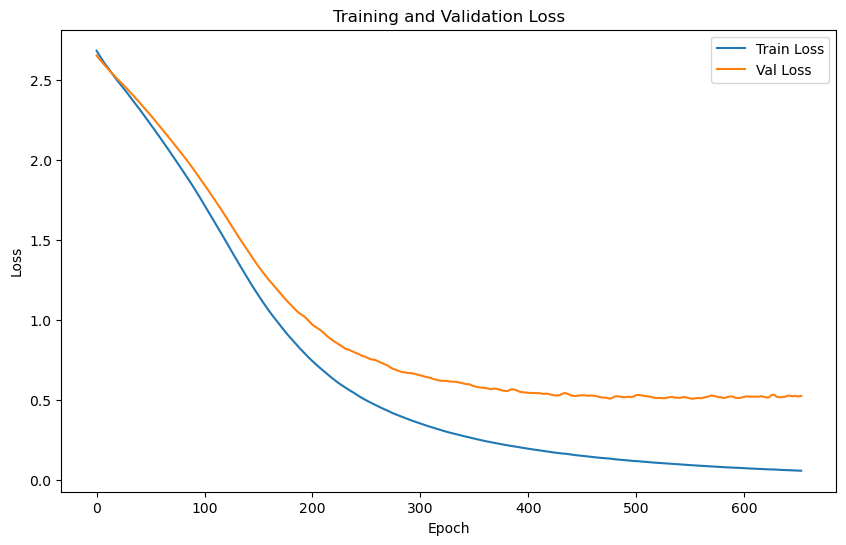

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.6182 | Test Accuracy: 80.15%


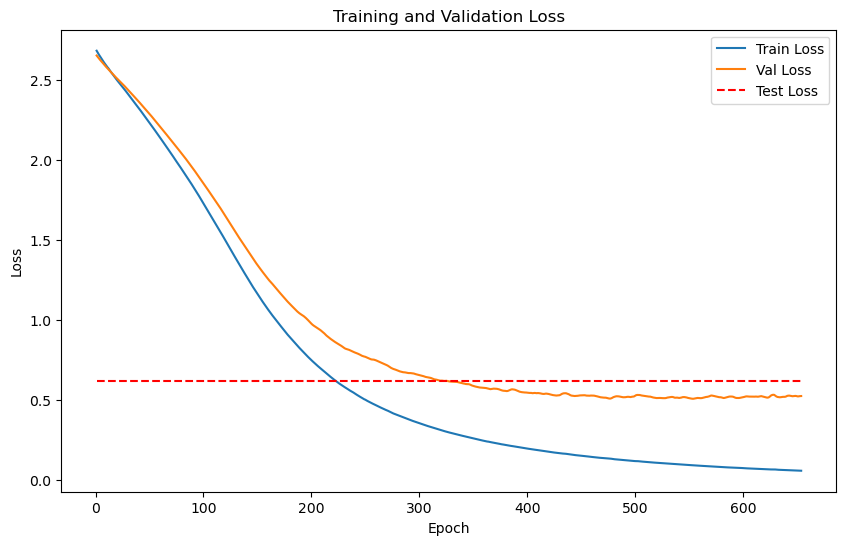

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


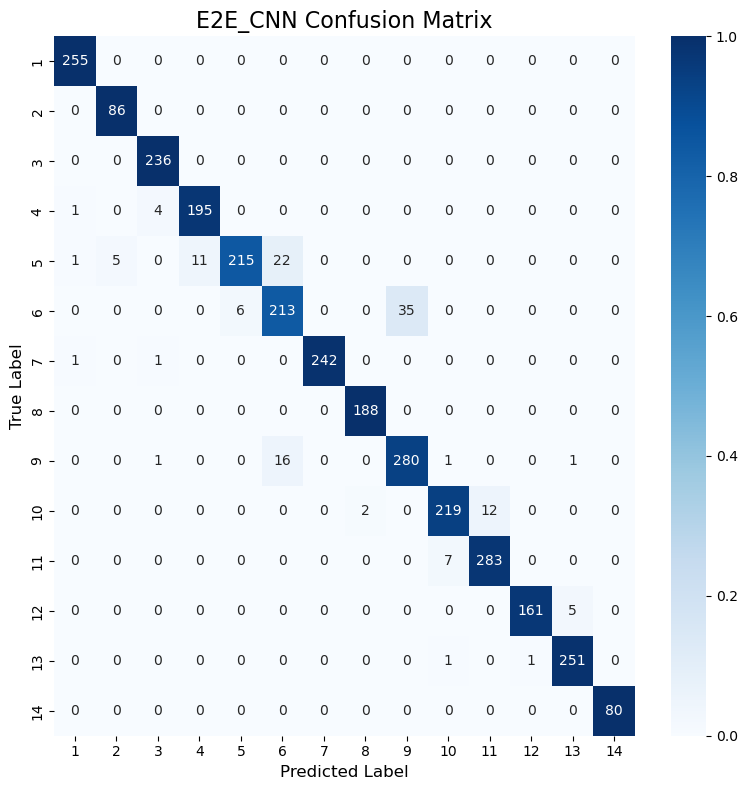

Classification Accuracy: 95.59%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


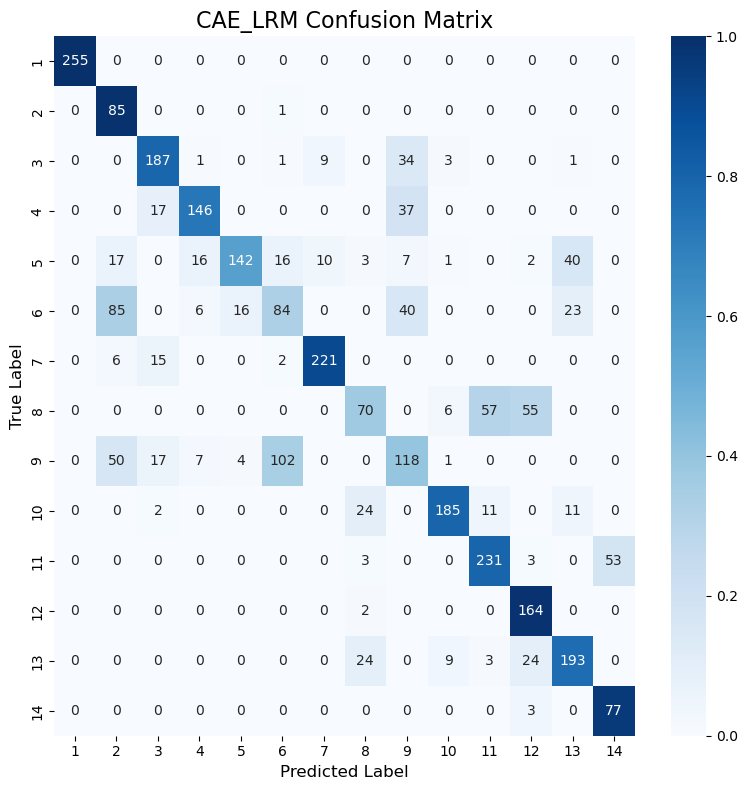

Classification Accuracy: 71.03%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


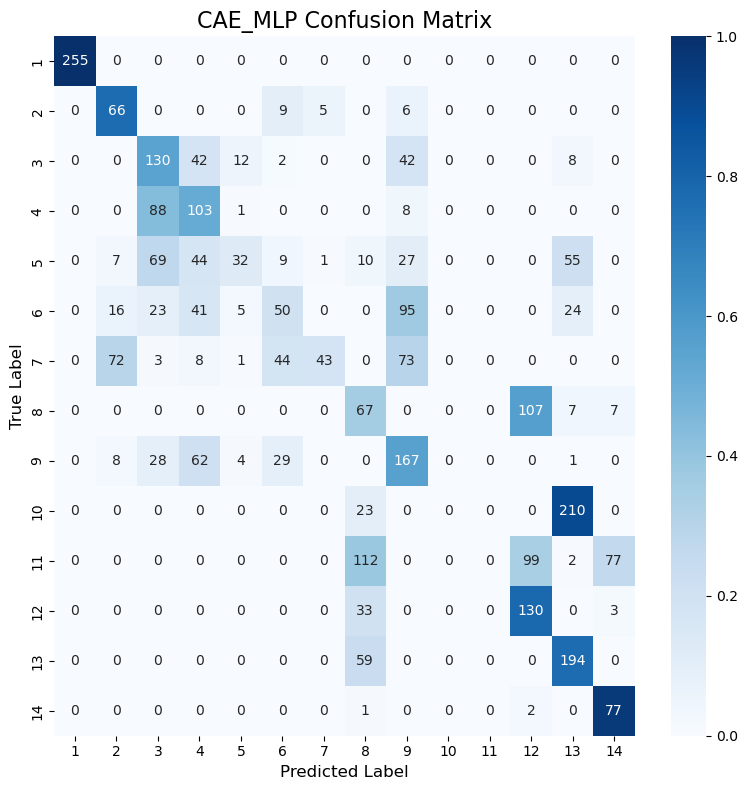

Classification Accuracy: 43.25%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


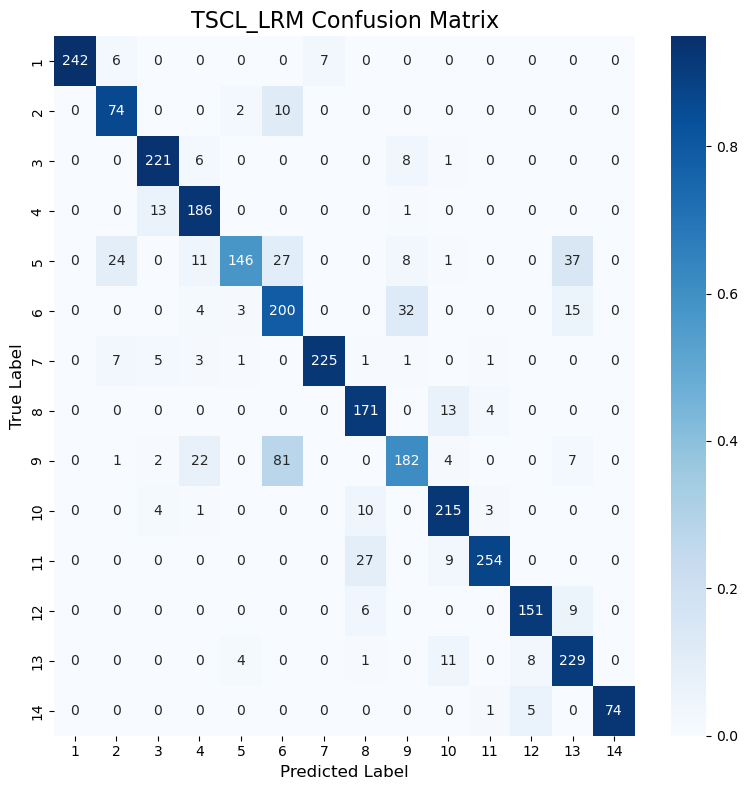

Classification Accuracy: 84.60%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


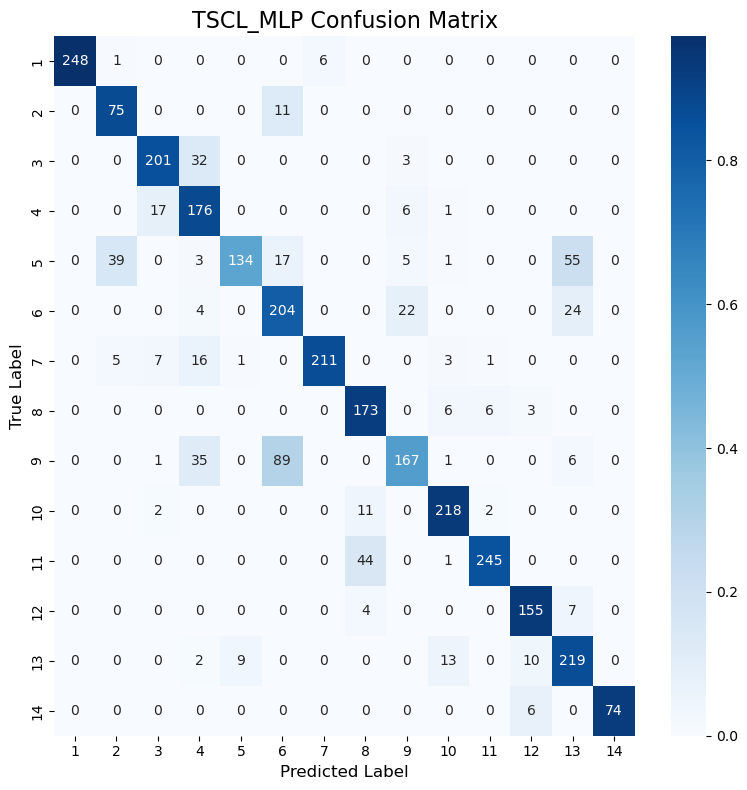

Classification Accuracy: 82.29%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


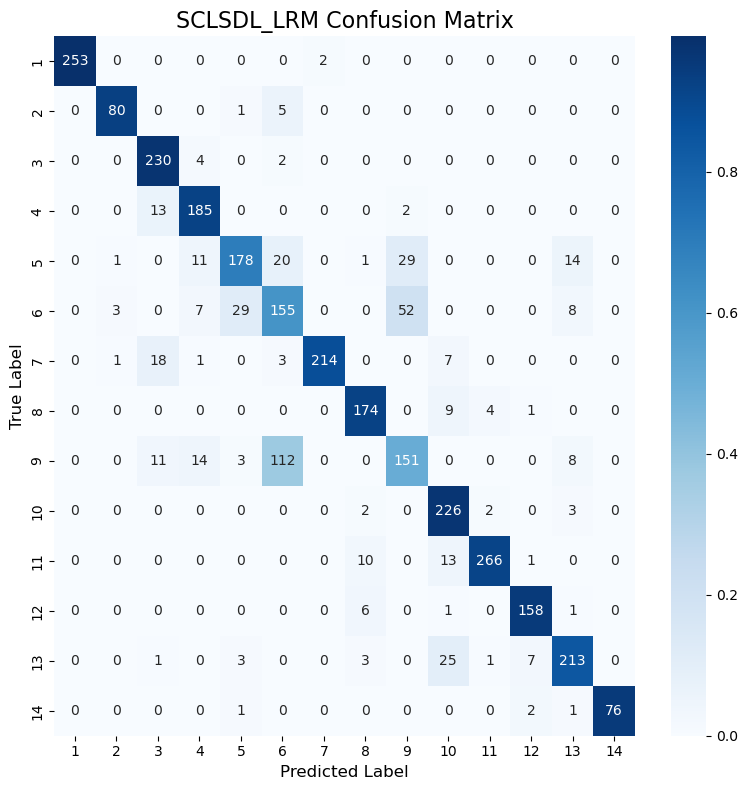

Classification Accuracy: 84.23%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


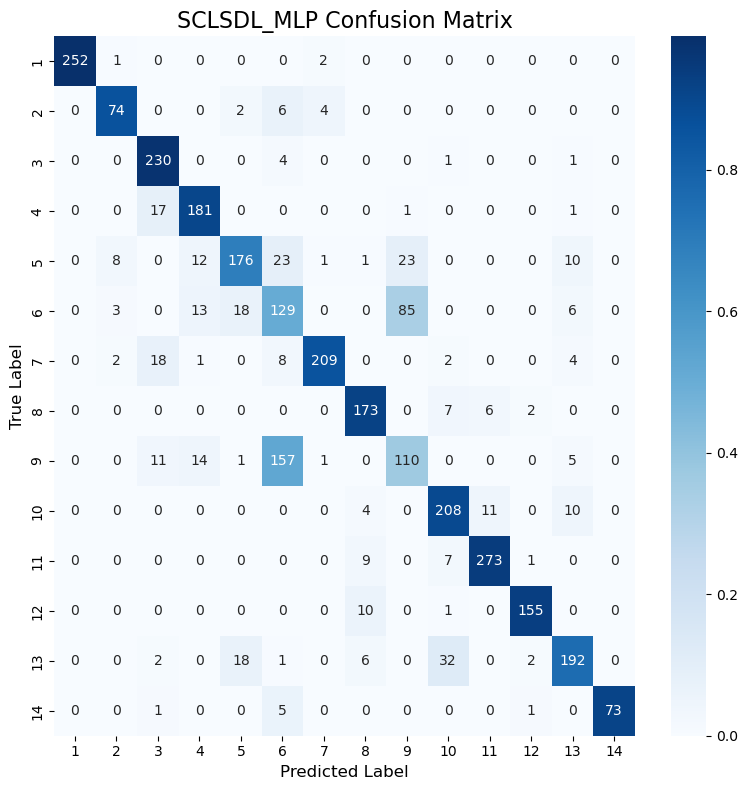

Classification Accuracy: 80.15%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          95.59
1    LRM (CAE)          71.03
2    MLP (CAE)          43.25
3     TSCL LRM          84.60
4     TSCL MLP          82.29
5  SCL_SDL LRM          84.23
6  SCL_SDL MLP          80.15

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          95.59
3     TSCL LRM          84.60
5  SCL_SDL LRM          84.23
4     TSCL MLP          82.29
6  SCL_SDL MLP          80.15
1    LRM (CAE)          71.03
2    MLP (CAE)          43.25
